In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import DataFrame
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import math

## Data Processing

In [2]:
country_info_path = "../data/country_info.csv"
distances_path = "../data/distances.csv"
votes_path = "../data/votes.csv"

# create voting matrix V and distance matrix D 

## distance matrix D
# organize in order according to country_info file (left -> right, up -> down)
country_info_df = pd.read_csv(country_info_path)

distances_df = pd.read_csv(distances_path)
distances_array = np.array(distances_df)
distances_list = distances_array[:, 1:].tolist()

country_with_distances, country_code_with_distance = distances_array[:, 0].tolist(), []
dict_from_name_to_code = country_info_df.set_index('capital')['code'].to_dict()
for c in country_with_distances:
    if c not in dict_from_name_to_code:
        continue
    country_code_with_distance.append(dict_from_name_to_code[c])

map_name_to_idx, map_code_to_idx, map_capital_to_idx = {}, {}, {}
country_info_array = np.array(country_info_df) 
country_info_list, country_info_list_align = country_info_array.tolist(), []
for c in country_info_list:
    if c[1] not in country_code_with_distance:
        continue
    country_info_list_align.append(c)
for idx, country in enumerate(country_info_list_align):
    if country[1] not in country_code_with_distance:
        continue
    map_name_to_idx[country[0]], map_code_to_idx[country[1]], map_capital_to_idx[country[2]]  = idx, idx, idx

old_order = distances_array[:, 0]
map_old_order_to_idx = {capital:idx for idx, capital in enumerate(old_order)}
country_num = len(old_order)

# (i, j) -> (i', j') in old_order -> distance(i', j') in distances_list
distances_list_in_new_order = [[
    distances_list[map_old_order_to_idx[country_info_list_align[j][2]]][map_old_order_to_idx[country_info_list_align[i][2]]] 
    for j in range(country_num)] for i in range(country_num)]
distance_matrix = distances_list_in_new_order

# normalize
# def normalize_2d_list(matrix):
#    normalized_matrix = []
#    for row in matrix:
#        row_sum = sum(row)
#        if row_sum == 0:
#            normalized_matrix.append([0] * len(row))
#        else:
#            normalized_row = [element / row_sum for element in row]
#            normalized_matrix.append(normalized_row)
#    return normalized_matrix

# distance_matrix_norm = normalize_2d_list(distance_matrix)


## voting matrix V
# votes_matrix_total, votes_matrix_jury, votes_matrix_tele

# omit other countries wld
votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix_total = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_jury = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_tele = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    # if vote[0] != 2023 or vote[1] != 'final':  # only consider 2023, final and total points
    # continue
    from_country_code, to_country_code, total_points = vote[2], vote[3], vote[-3]
    if from_country_code not in country_code_with_distance or to_country_code not in country_code_with_distance:
        continue
    votes_matrix_total[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += total_points
    if not math.isnan(vote[-2]):
        votes_matrix_tele[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-2]
    if not math.isnan(vote[-1]):
        votes_matrix_jury[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-1]



## Clustering 

Input two sets of data where each row corresponds one-to-one. Perform clustering on the first set of data to obtain clustering labels. Then, use the same labels to classify both sets of data. Perform PCA to reduce the dimensionality to two dimensions for both sets and visualize the results. We compare the results obtained by KMeans/Spectral Clustering with random  clustering.

In [3]:
def clustering_one_and_visualize_by_pca(D, V, num_clusters, method='KMeans'):
    # Preprocess data: Impute missing values and normalize
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    D_imputed = imputer.fit_transform(D)
    V_imputed = imputer.transform(V)  # Use the same transformation for V
    
    D_scaled = scaler.fit_transform(D_imputed)
    V_scaled = scaler.transform(V_imputed)  # Use the same transformation for V

    # Clustering
    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=42)
    elif method == 'SpectralClustering':
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=42, assign_labels="discretize")
    
    labels = clustering.fit_predict(D_scaled)  # Only fit on D

    # Random labels for comparison
    random_labels = np.random.randint(num_clusters, size=len(D))

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    D_pca = pca.fit_transform(D_scaled)
    V_pca = pca.transform(V_scaled)  # Use the same PCA transformation for V

    # Visualization of original clustering
    plt.figure(figsize=(24, 12))

    plt.subplot(2, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Distance Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    # Visualization of random clustering
    plt.subplot(2, 2, 3)
    for cluster in range(num_clusters):
        cluster_points = D_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Distance Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 4)
    for cluster in range(num_clusters):
        cluster_points = V_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluation
    silhouette_score_D = silhouette_score(D_scaled, labels)
    silhouette_score_V = silhouette_score(V_scaled, labels)
    silhouette_score_D_random = silhouette_score(D_scaled, random_labels)
    silhouette_score_V_random = silhouette_score(V_scaled, random_labels)

    print(f"The silhouette score for Distance Matrix (Original) is: {silhouette_score_D}")
    print(f"The silhouette score for Voting Matrix (Original) is: {silhouette_score_V}")
    print(f"The silhouette score for Distance Matrix data (Random) is: {silhouette_score_D_random}")
    print(f"The silhouette score for Voting Matrix data (Random) is: {silhouette_score_V_random}")

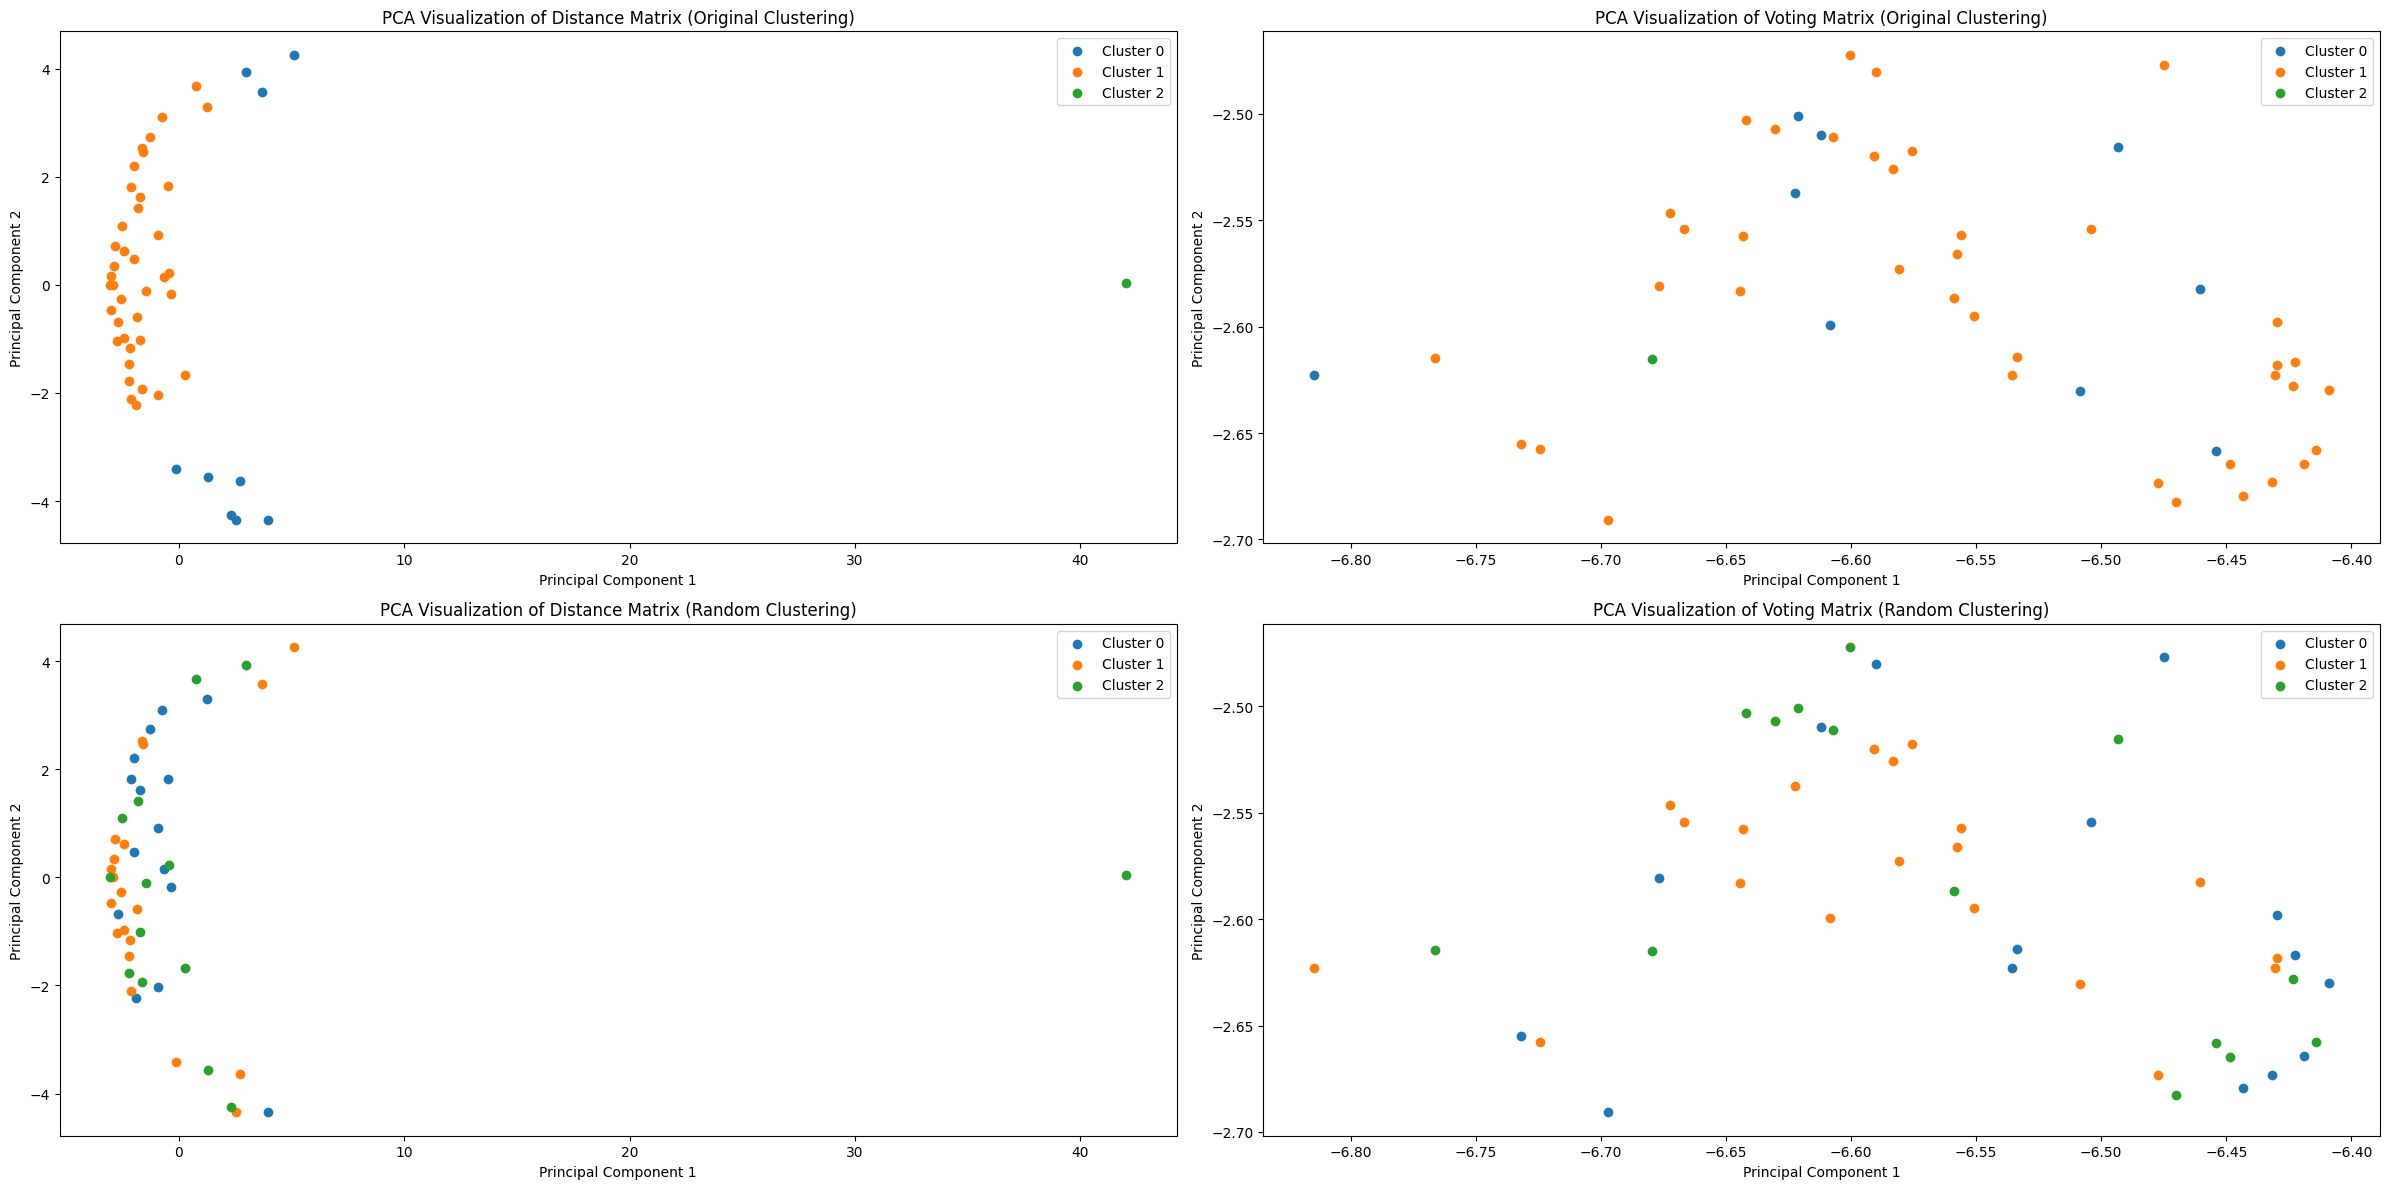

The silhouette score for Distance Matrix (Original) is: 0.43565657070273434
The silhouette score for Voting Matrix (Original) is: -0.17771193949949488
The silhouette score for Distance Matrix data (Random) is: -0.09667521352189211
The silhouette score for Voting Matrix data (Random) is: -0.0222526674613482


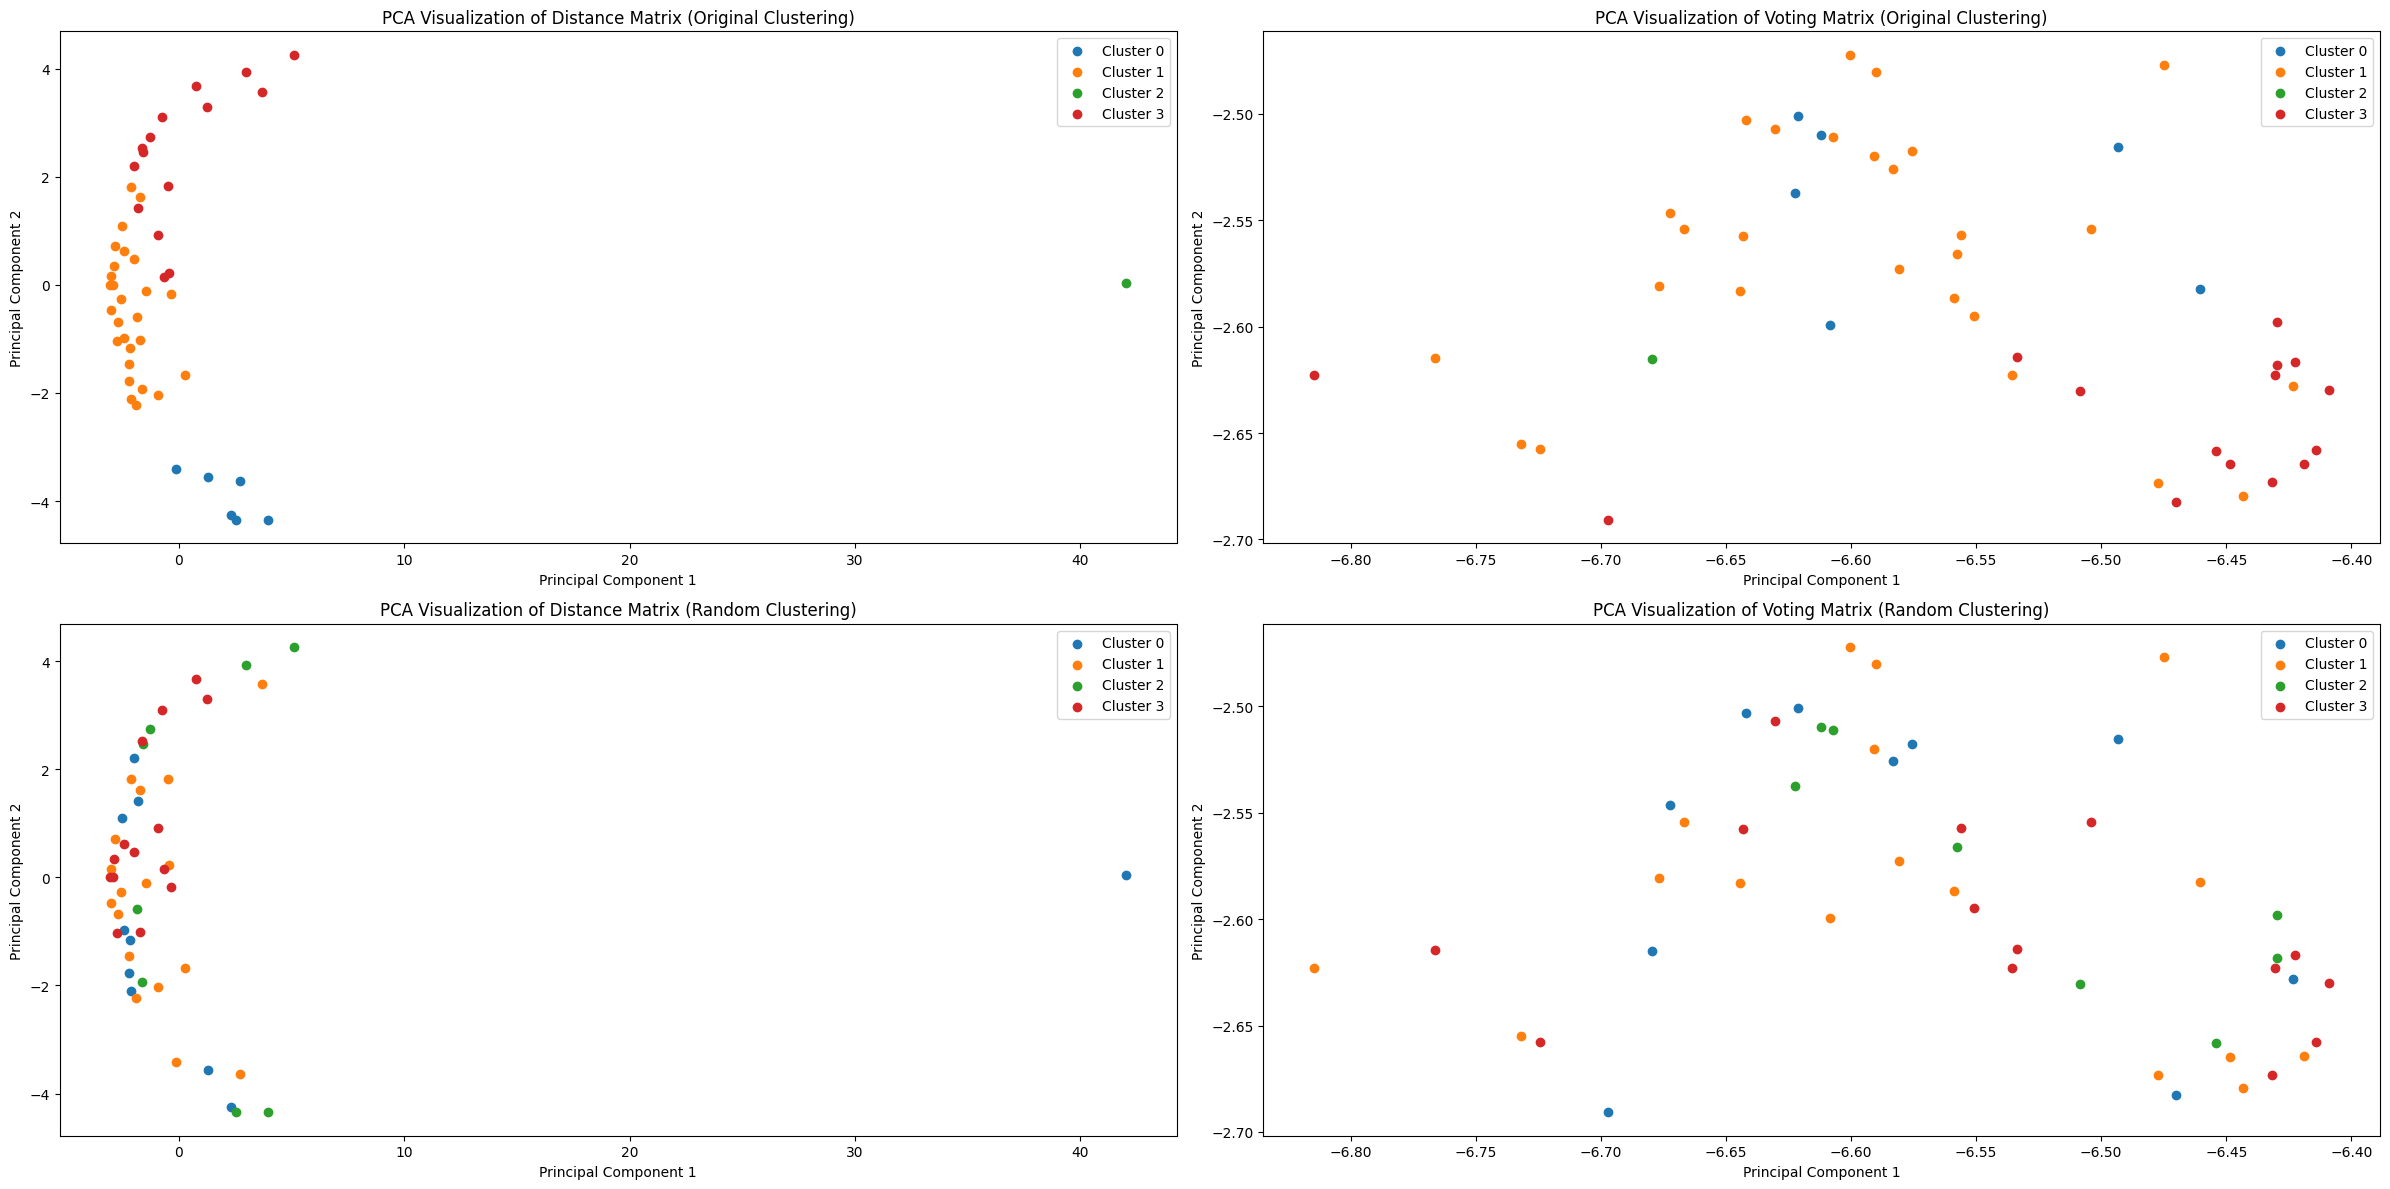

The silhouette score for Distance Matrix (Original) is: 0.34688942107354964
The silhouette score for Voting Matrix (Original) is: -0.12752122182890333
The silhouette score for Distance Matrix data (Random) is: -0.14766349988168243
The silhouette score for Voting Matrix data (Random) is: -0.05684519885548762


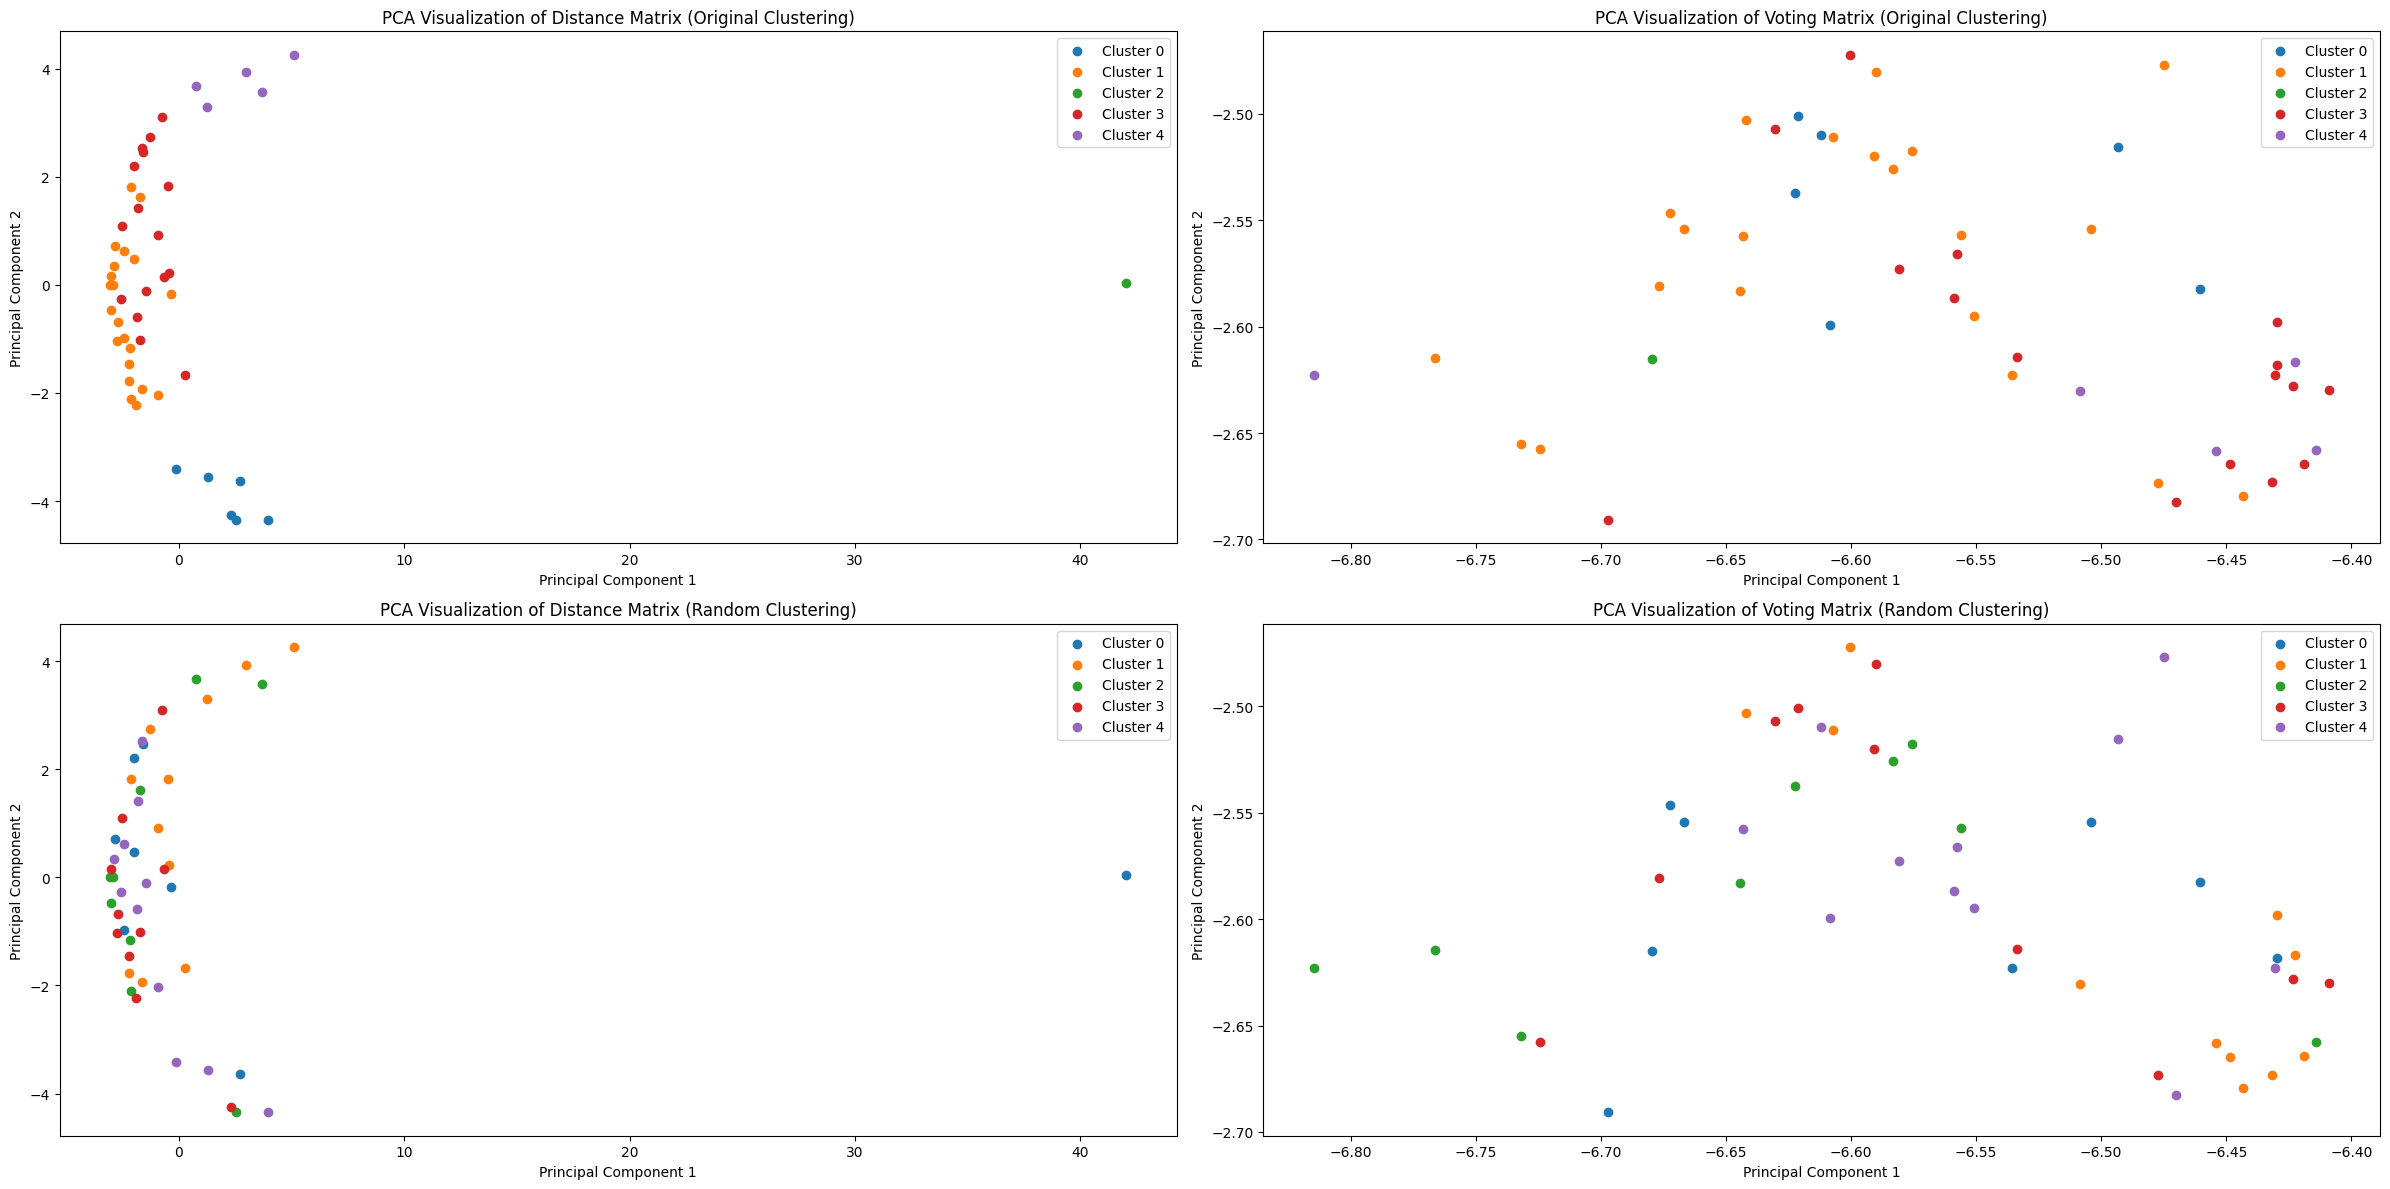

The silhouette score for Distance Matrix (Original) is: 0.36277287117431434
The silhouette score for Voting Matrix (Original) is: -0.16048517383961808
The silhouette score for Distance Matrix data (Random) is: -0.1770250771014393
The silhouette score for Voting Matrix data (Random) is: -0.08061904543501348


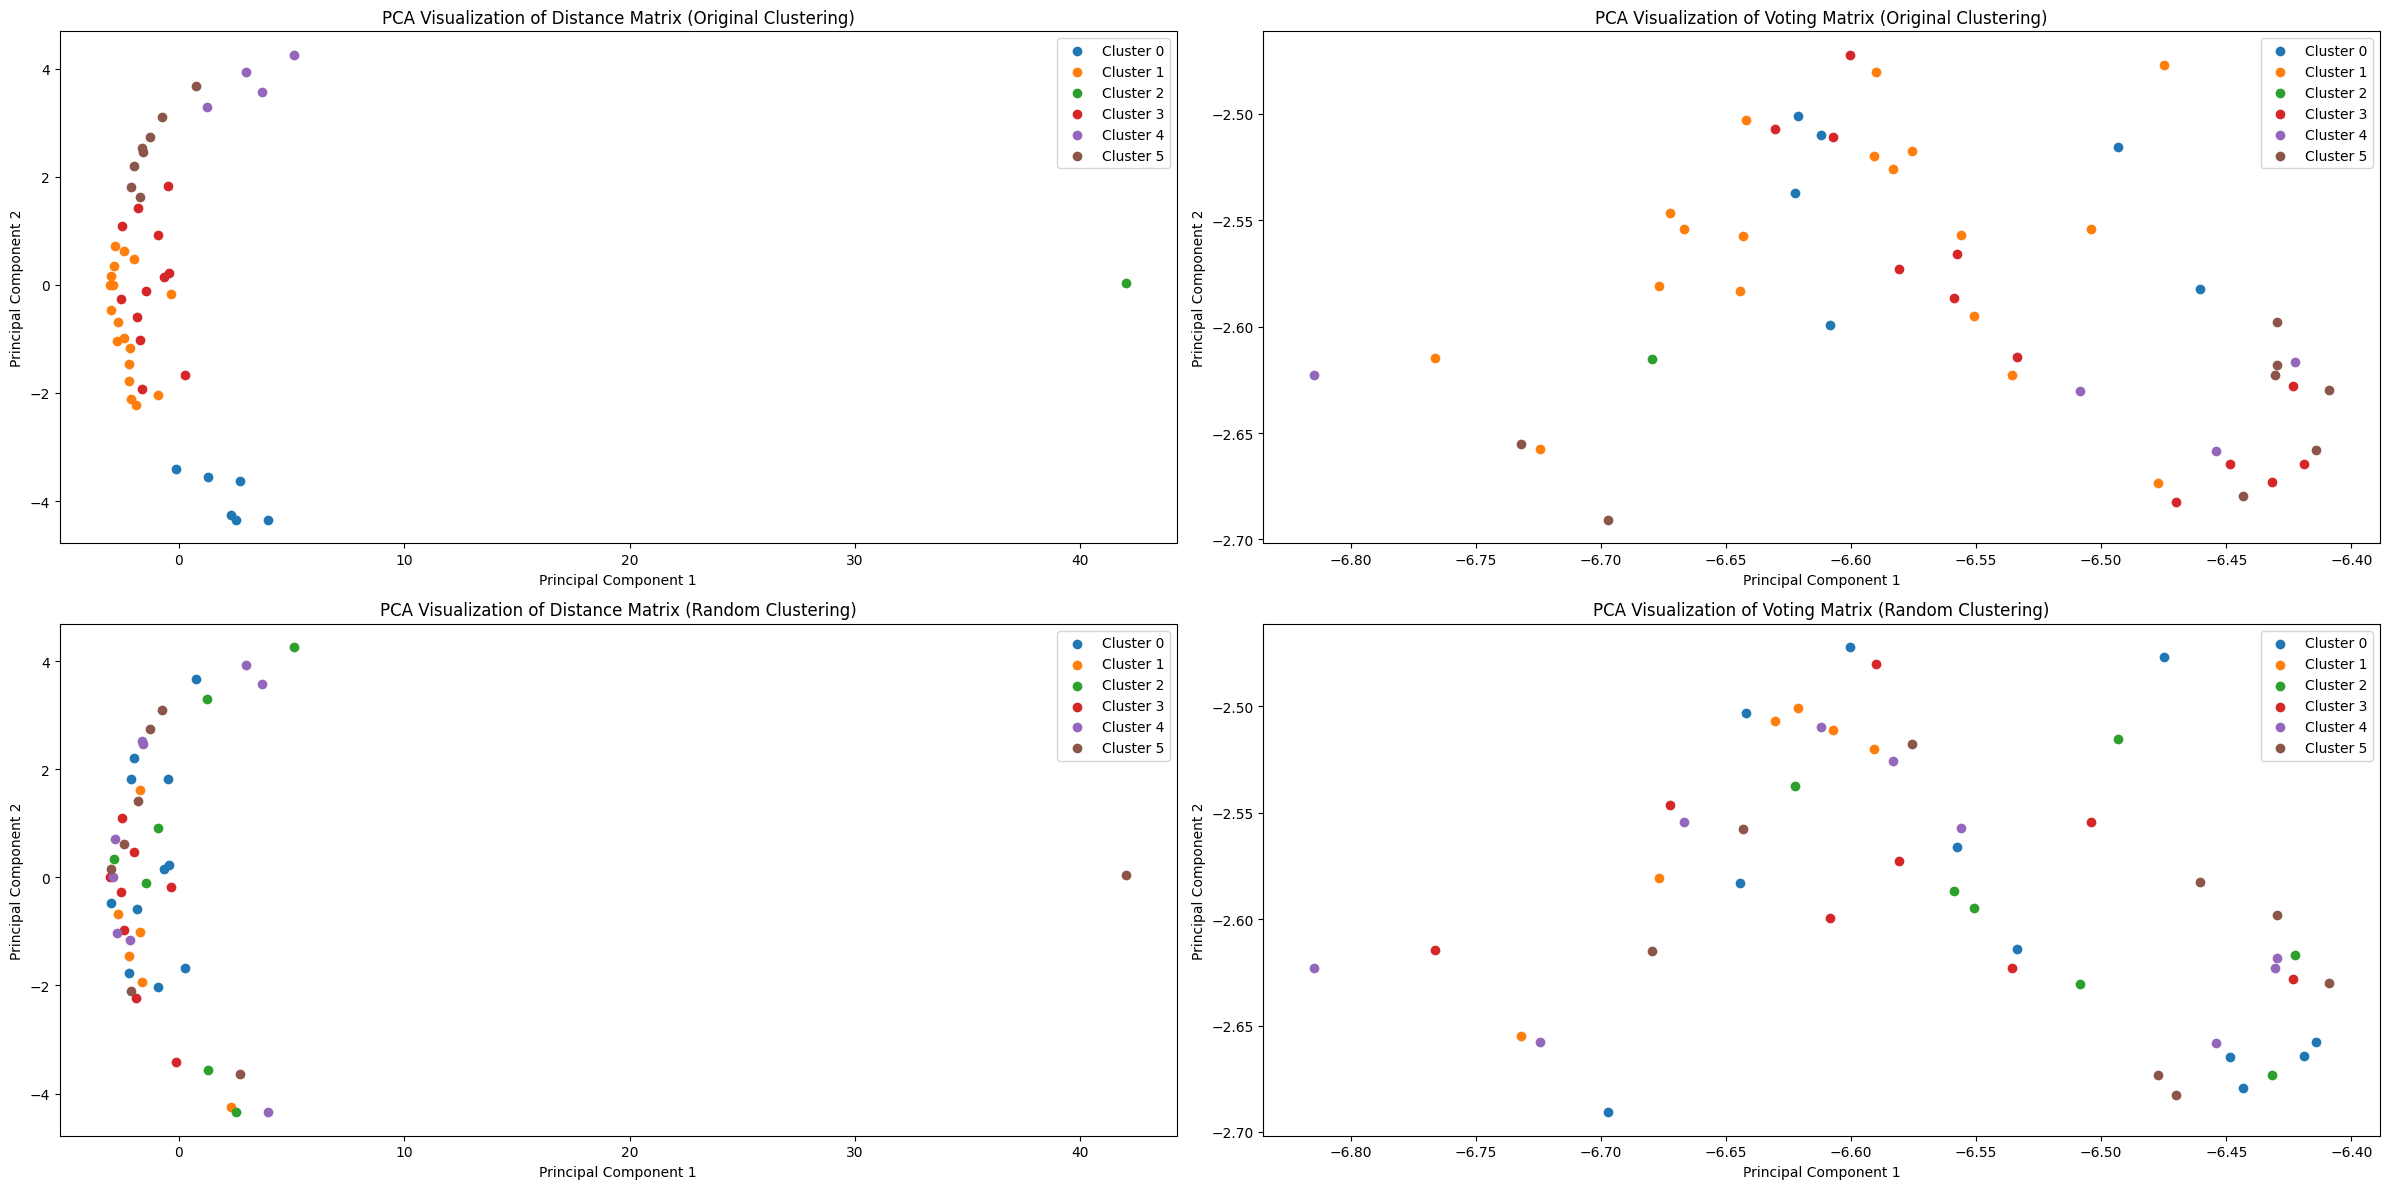

The silhouette score for Distance Matrix (Original) is: 0.4079721815423443
The silhouette score for Voting Matrix (Original) is: -0.16120256456293874
The silhouette score for Distance Matrix data (Random) is: -0.22352443330123906
The silhouette score for Voting Matrix data (Random) is: -0.11961940432952362


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


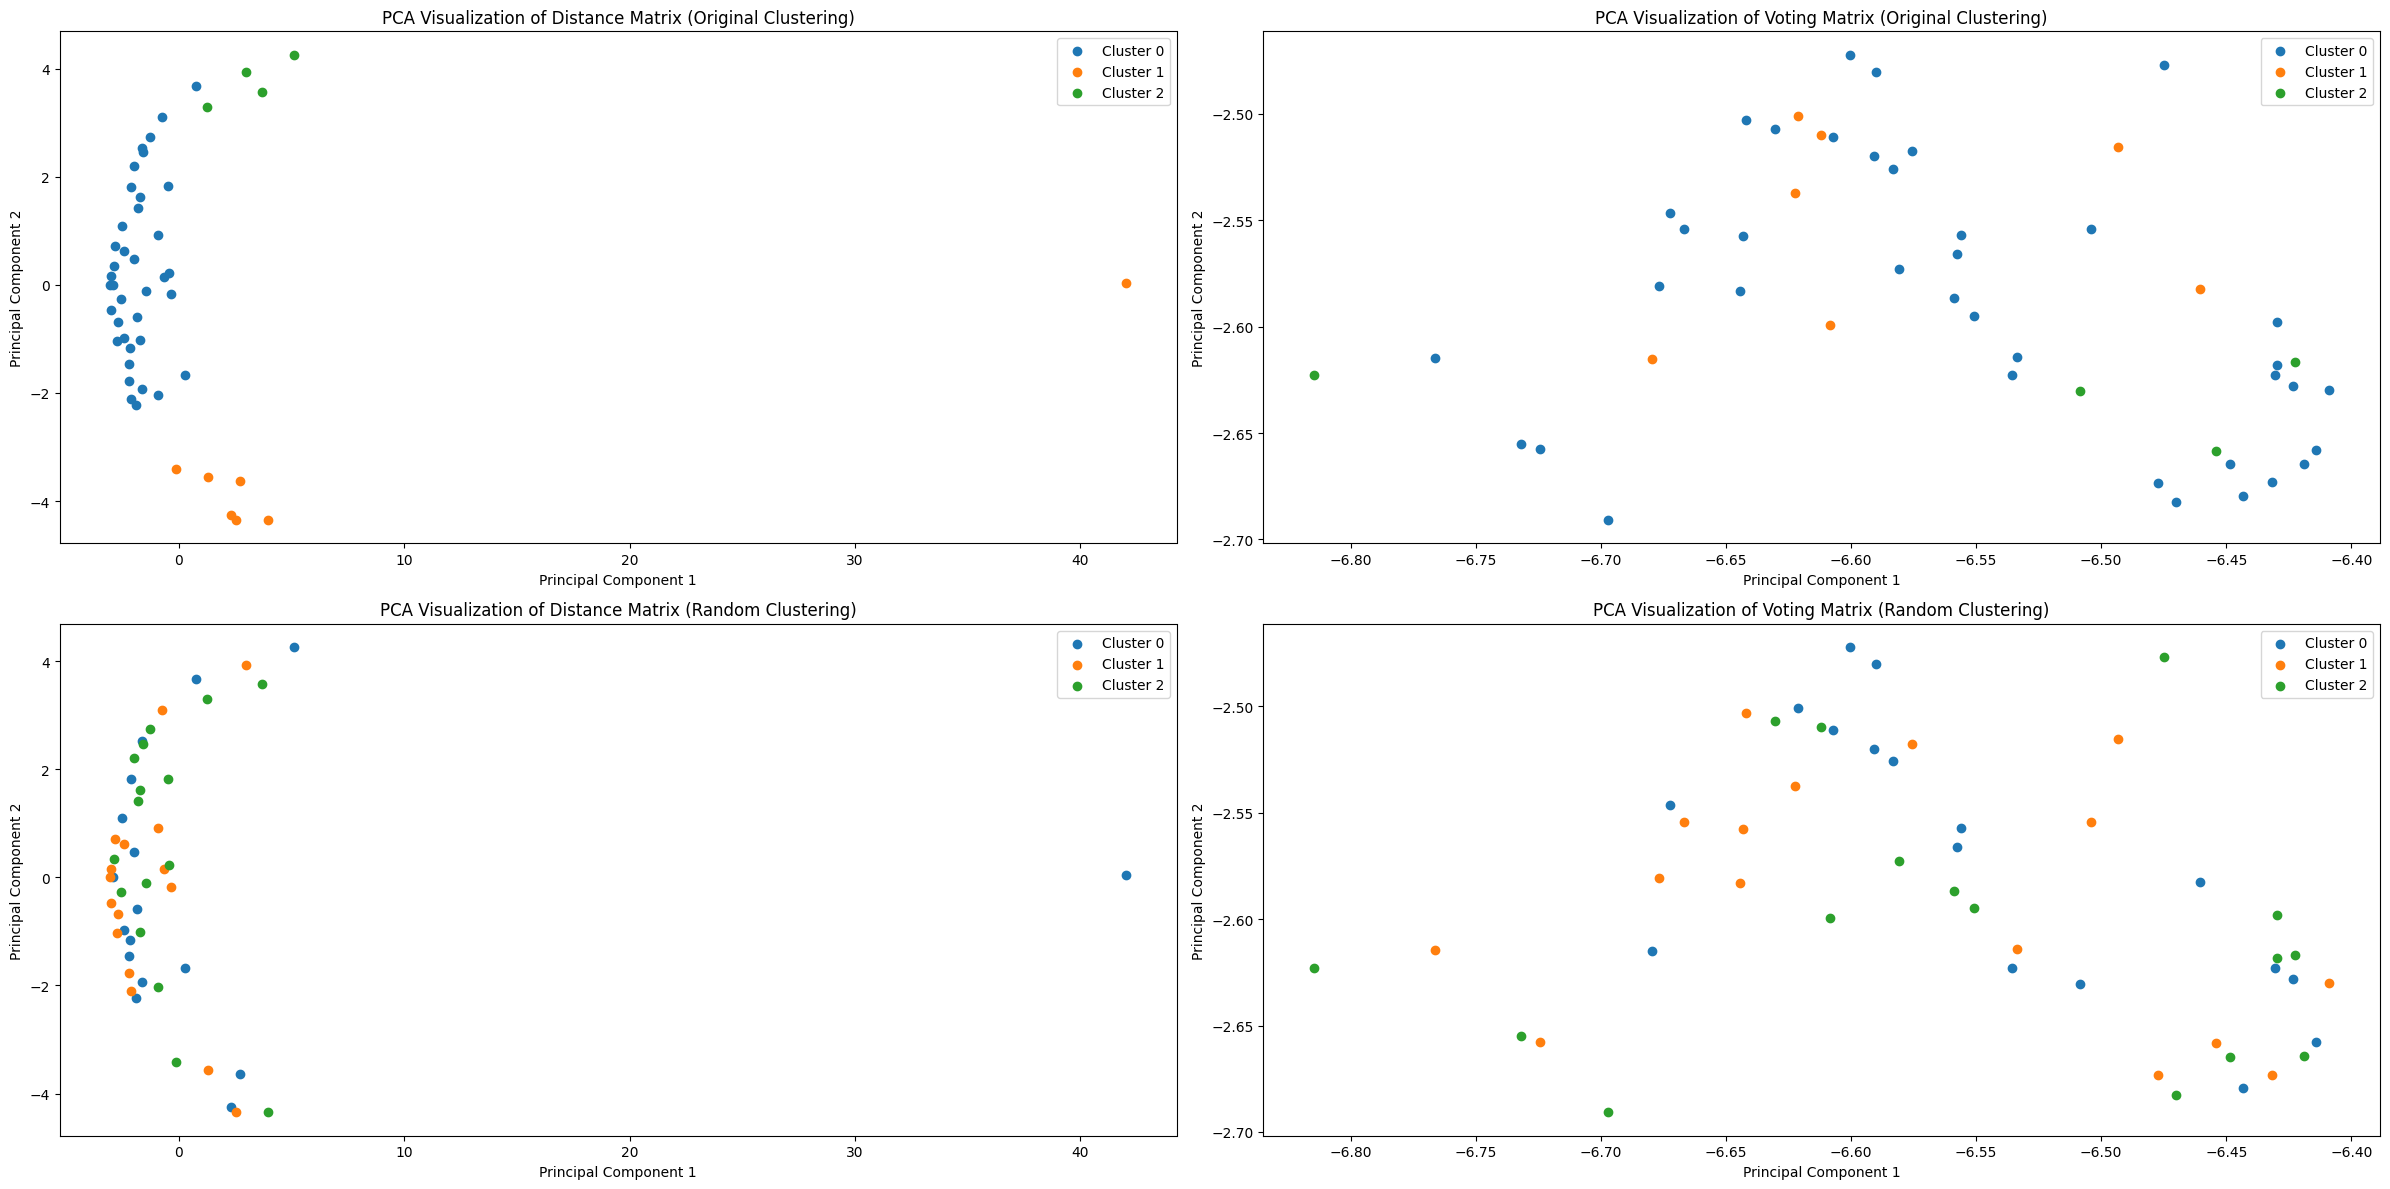

The silhouette score for Distance Matrix (Original) is: 0.42096030704694026
The silhouette score for Voting Matrix (Original) is: -0.07207696856993269
The silhouette score for Distance Matrix data (Random) is: -0.12656499255516349
The silhouette score for Voting Matrix data (Random) is: -0.03712891902967656


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


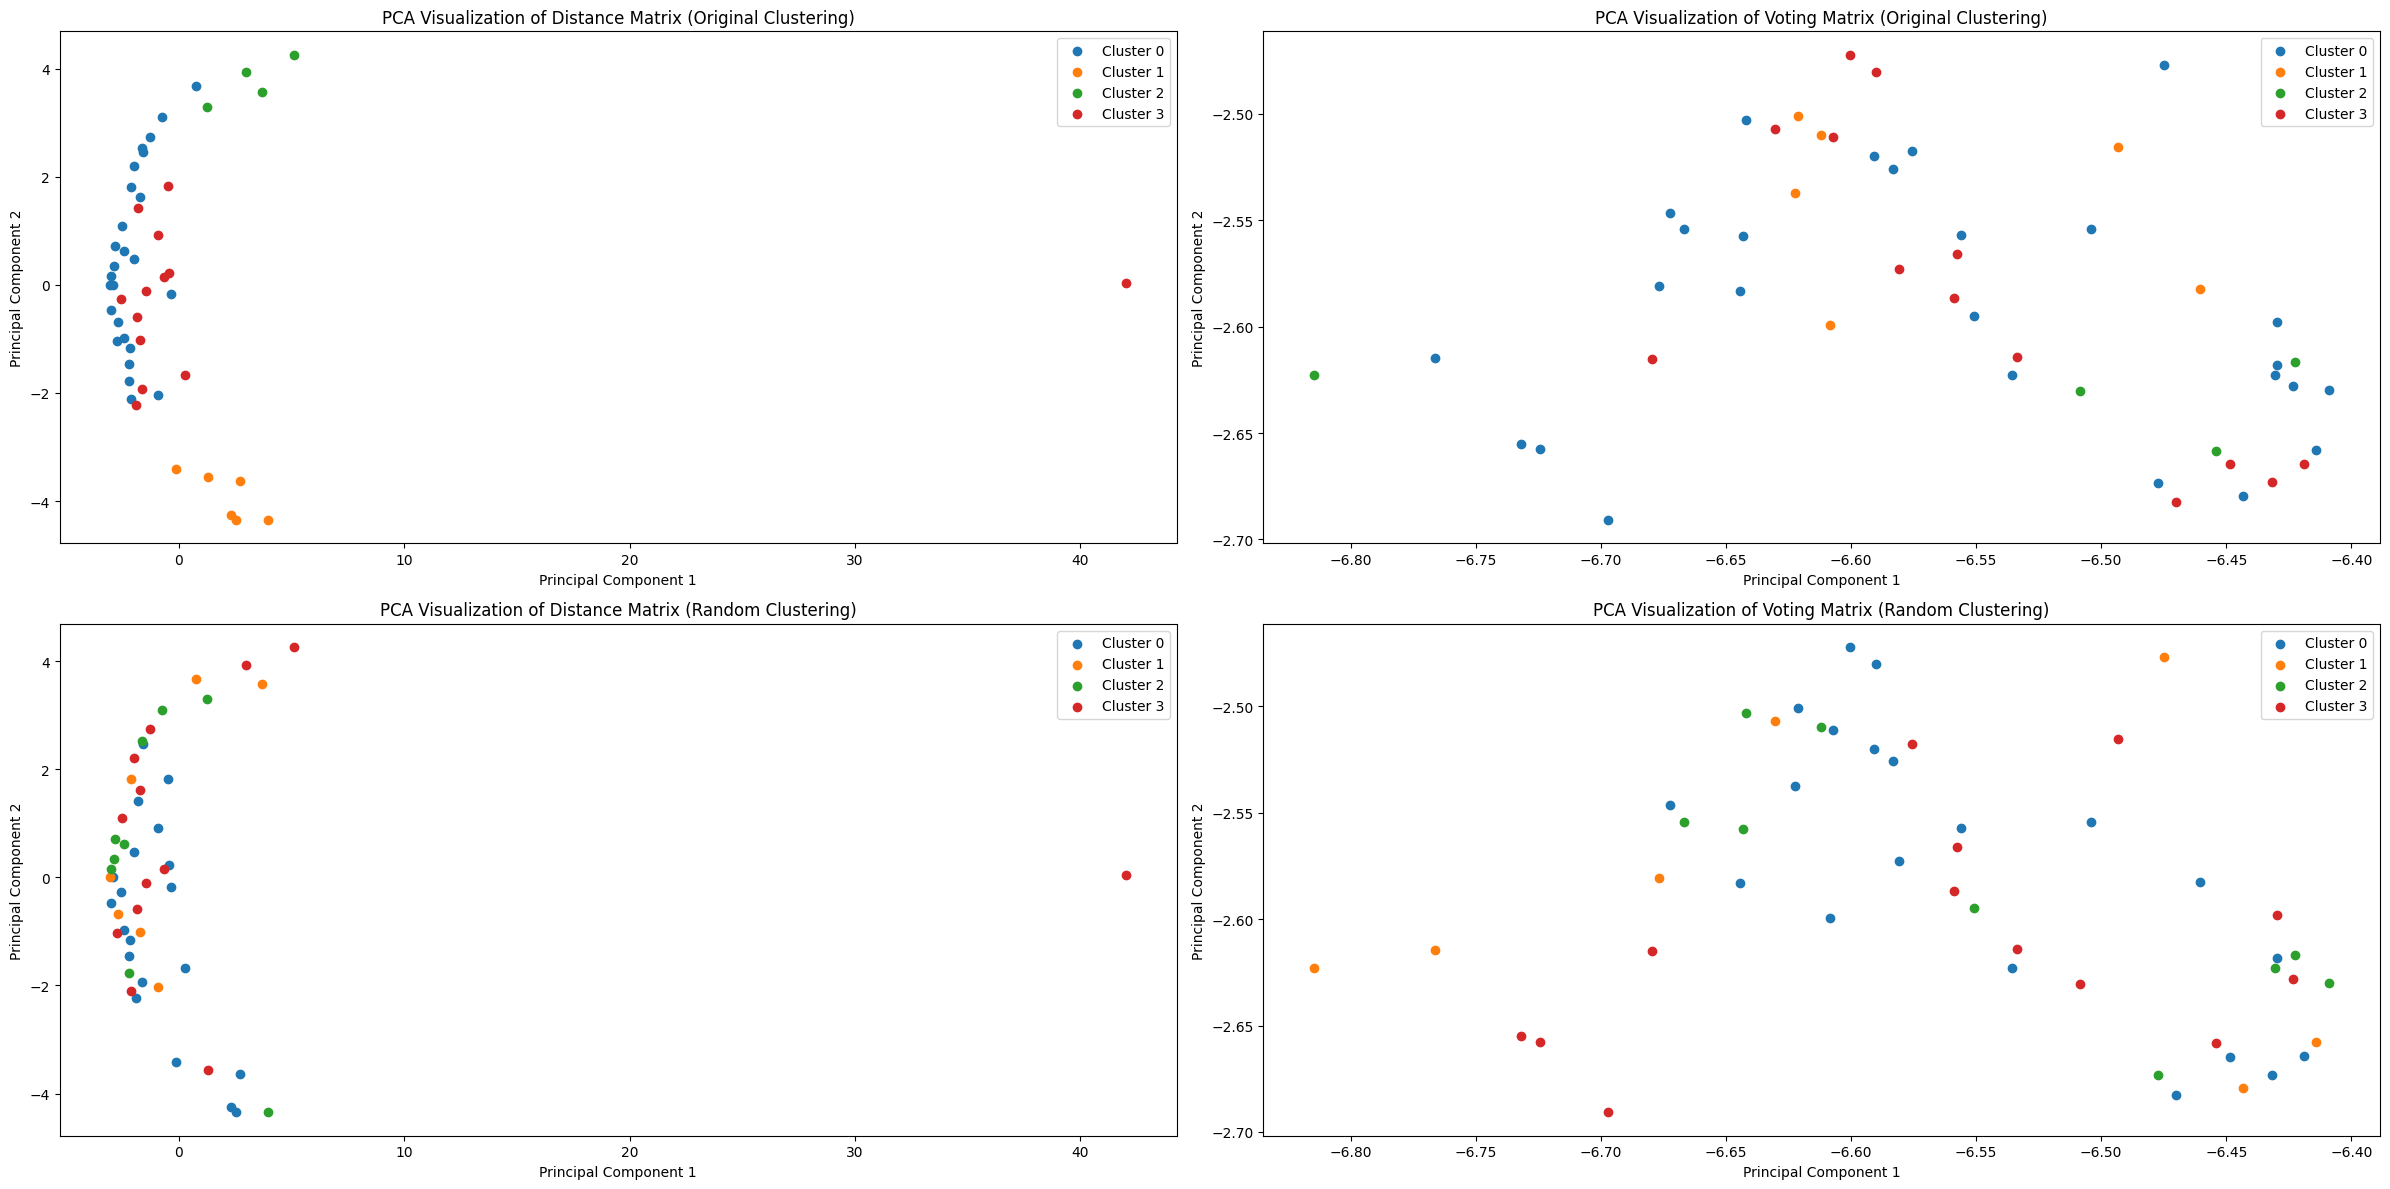

The silhouette score for Distance Matrix (Original) is: 0.3015845155402666
The silhouette score for Voting Matrix (Original) is: -0.04510545213656706
The silhouette score for Distance Matrix data (Random) is: -0.1445013860126644
The silhouette score for Voting Matrix data (Random) is: -0.05124584640257636


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


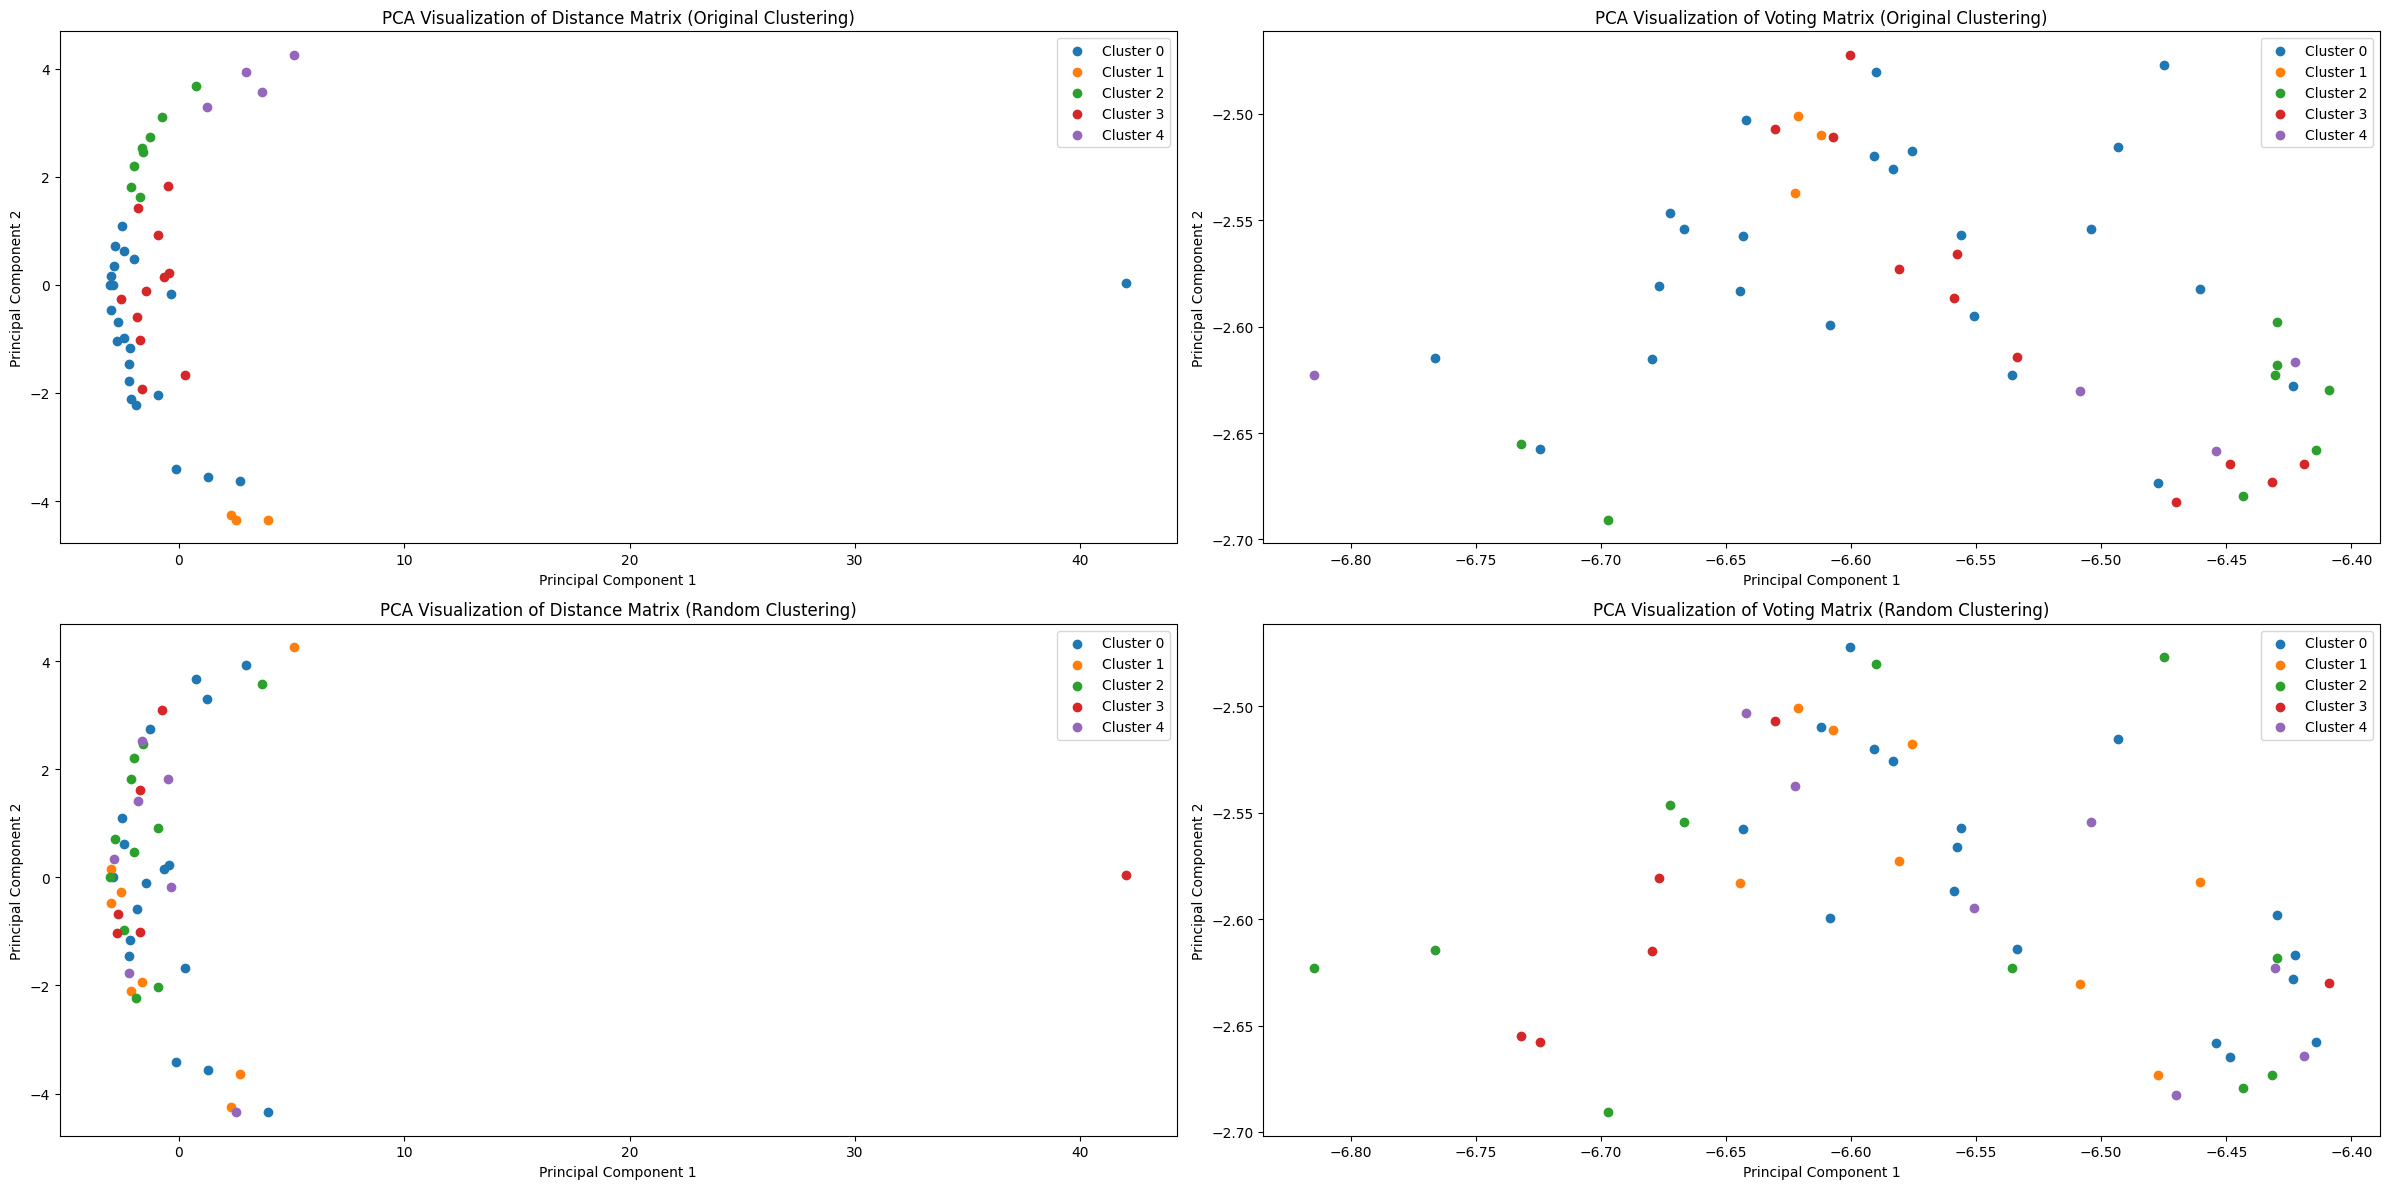

The silhouette score for Distance Matrix (Original) is: 0.15855320161478026
The silhouette score for Voting Matrix (Original) is: -0.08600993589598084
The silhouette score for Distance Matrix data (Random) is: -0.1758837804353761
The silhouette score for Voting Matrix data (Random) is: -0.09025039256759336


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


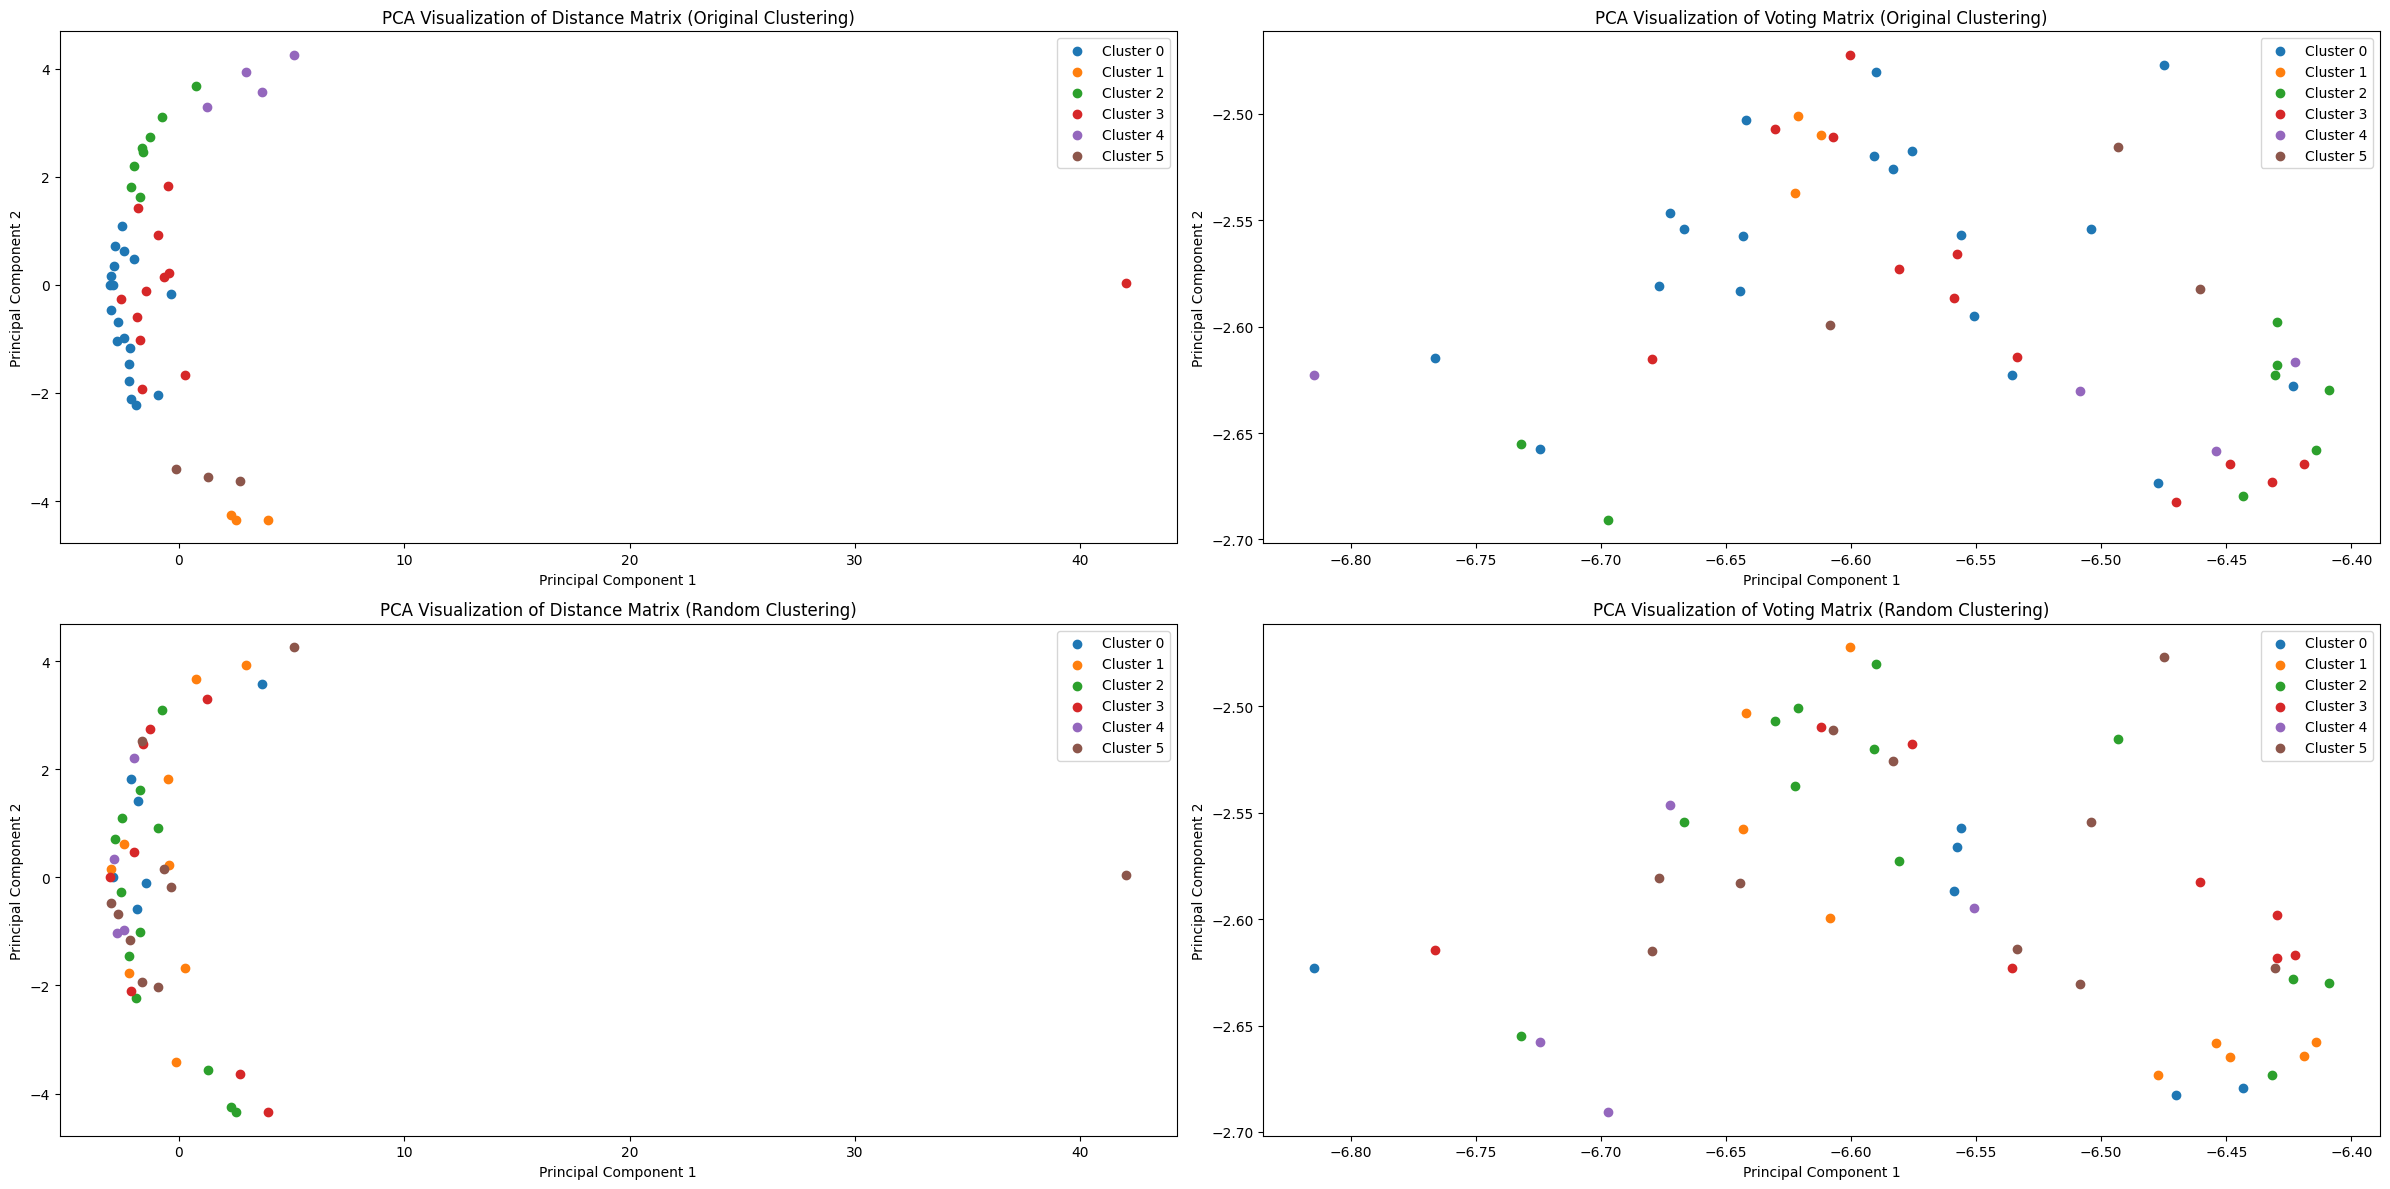

The silhouette score for Distance Matrix (Original) is: 0.2277230327024865
The silhouette score for Voting Matrix (Original) is: -0.08984475320540344
The silhouette score for Distance Matrix data (Random) is: -0.28487906839189225
The silhouette score for Voting Matrix data (Random) is: -0.10832194670445201


In [4]:
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_total, 6, method='SpectralClustering')

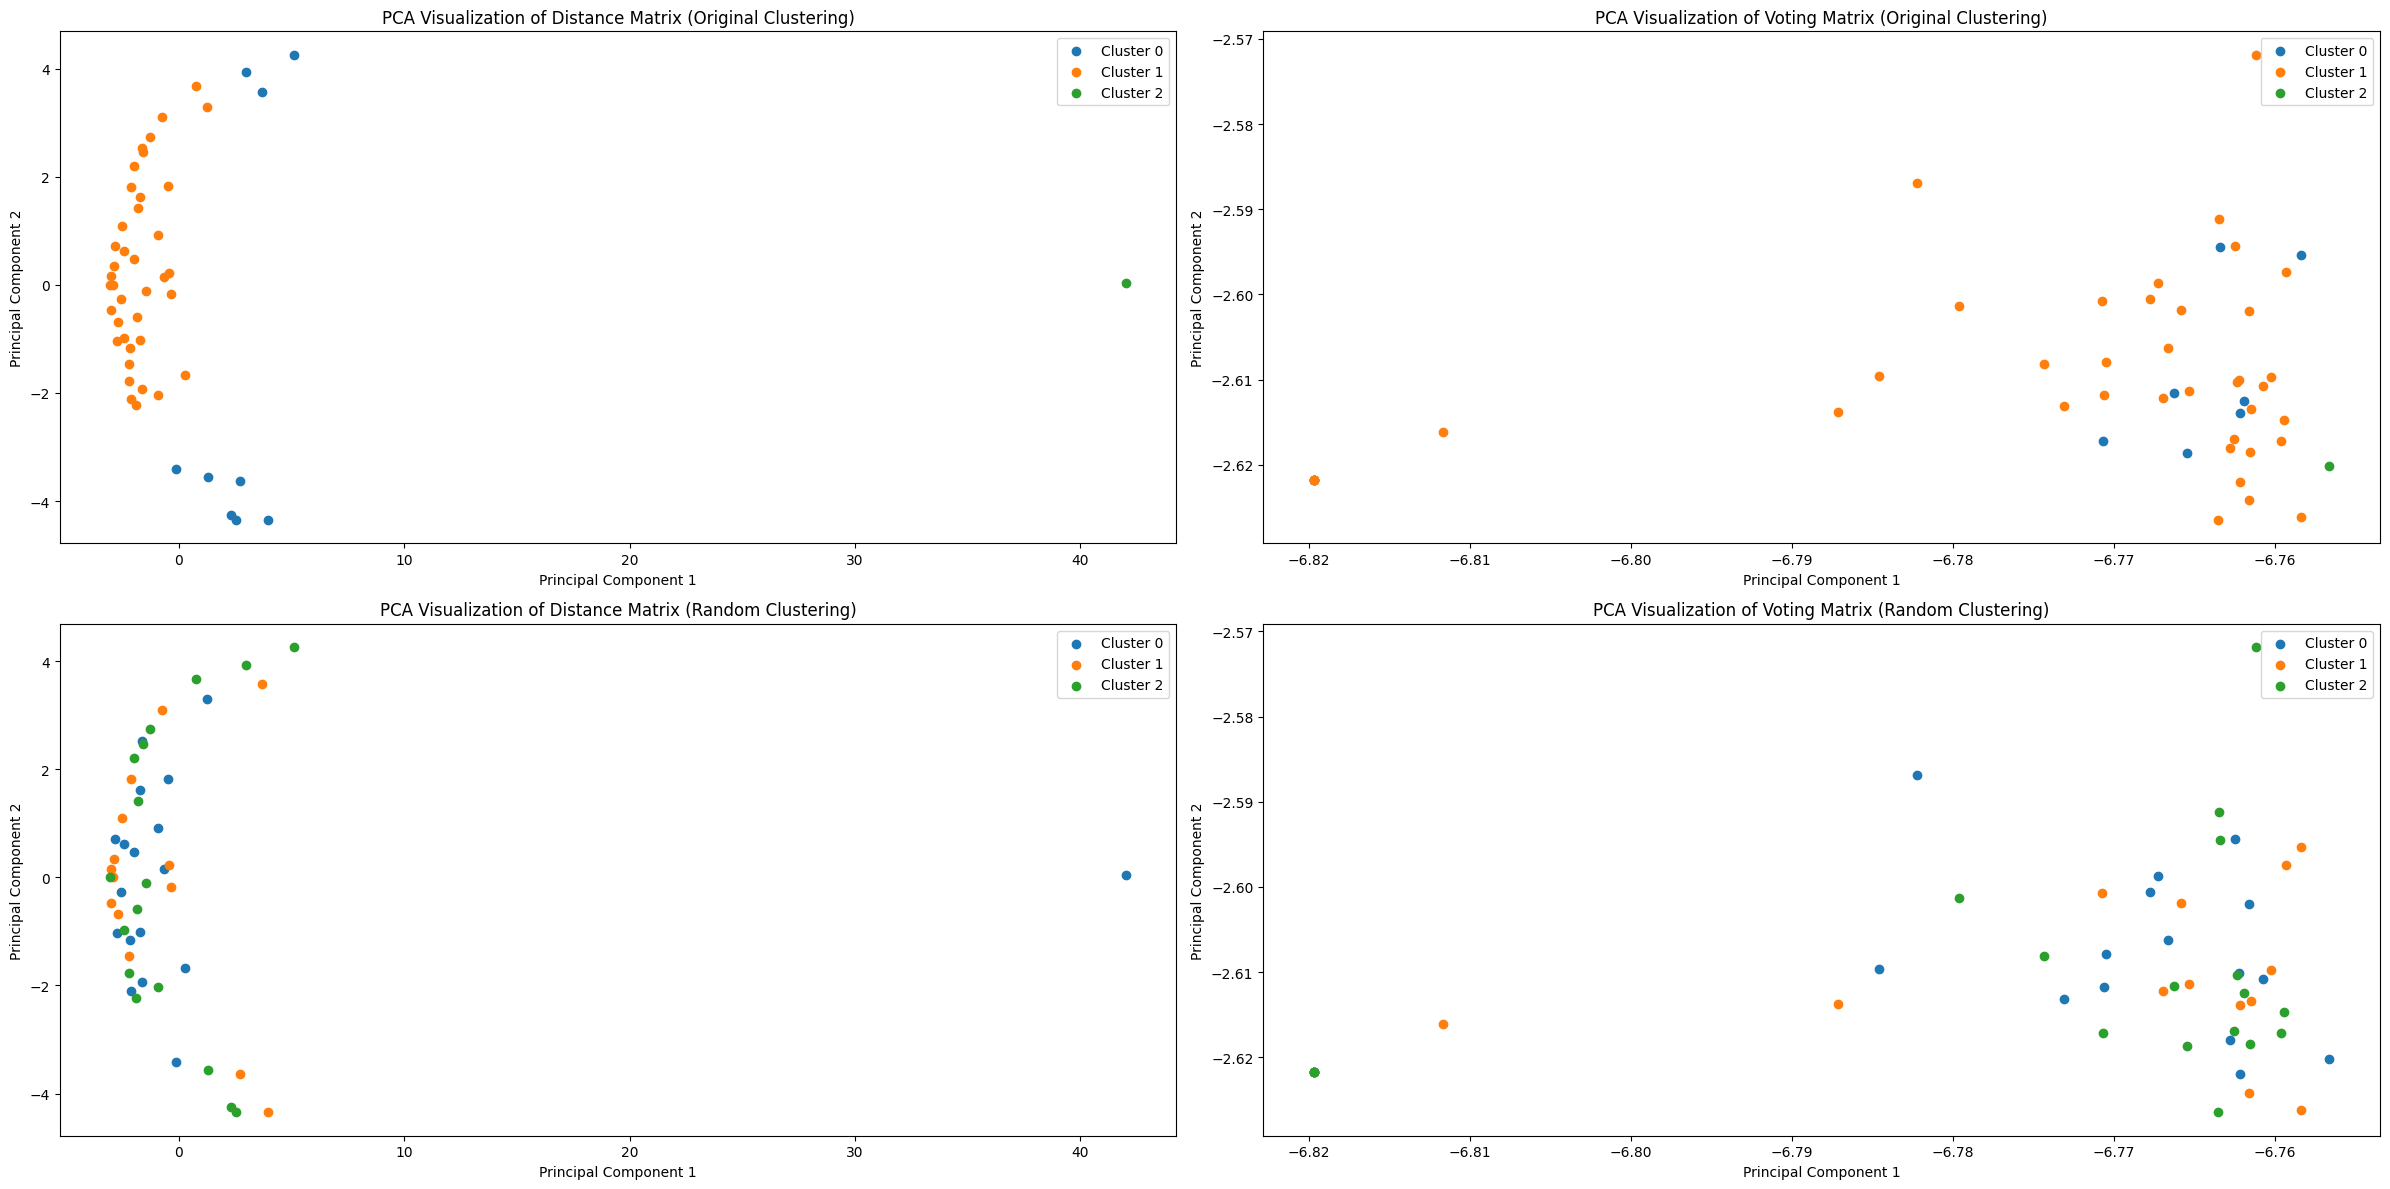

The silhouette score for Distance Matrix (Original) is: 0.43565657070273434
The silhouette score for Voting Matrix (Original) is: -0.07317183199907912
The silhouette score for Distance Matrix data (Random) is: -0.12477853994557306
The silhouette score for Voting Matrix data (Random) is: -0.026609536508944084


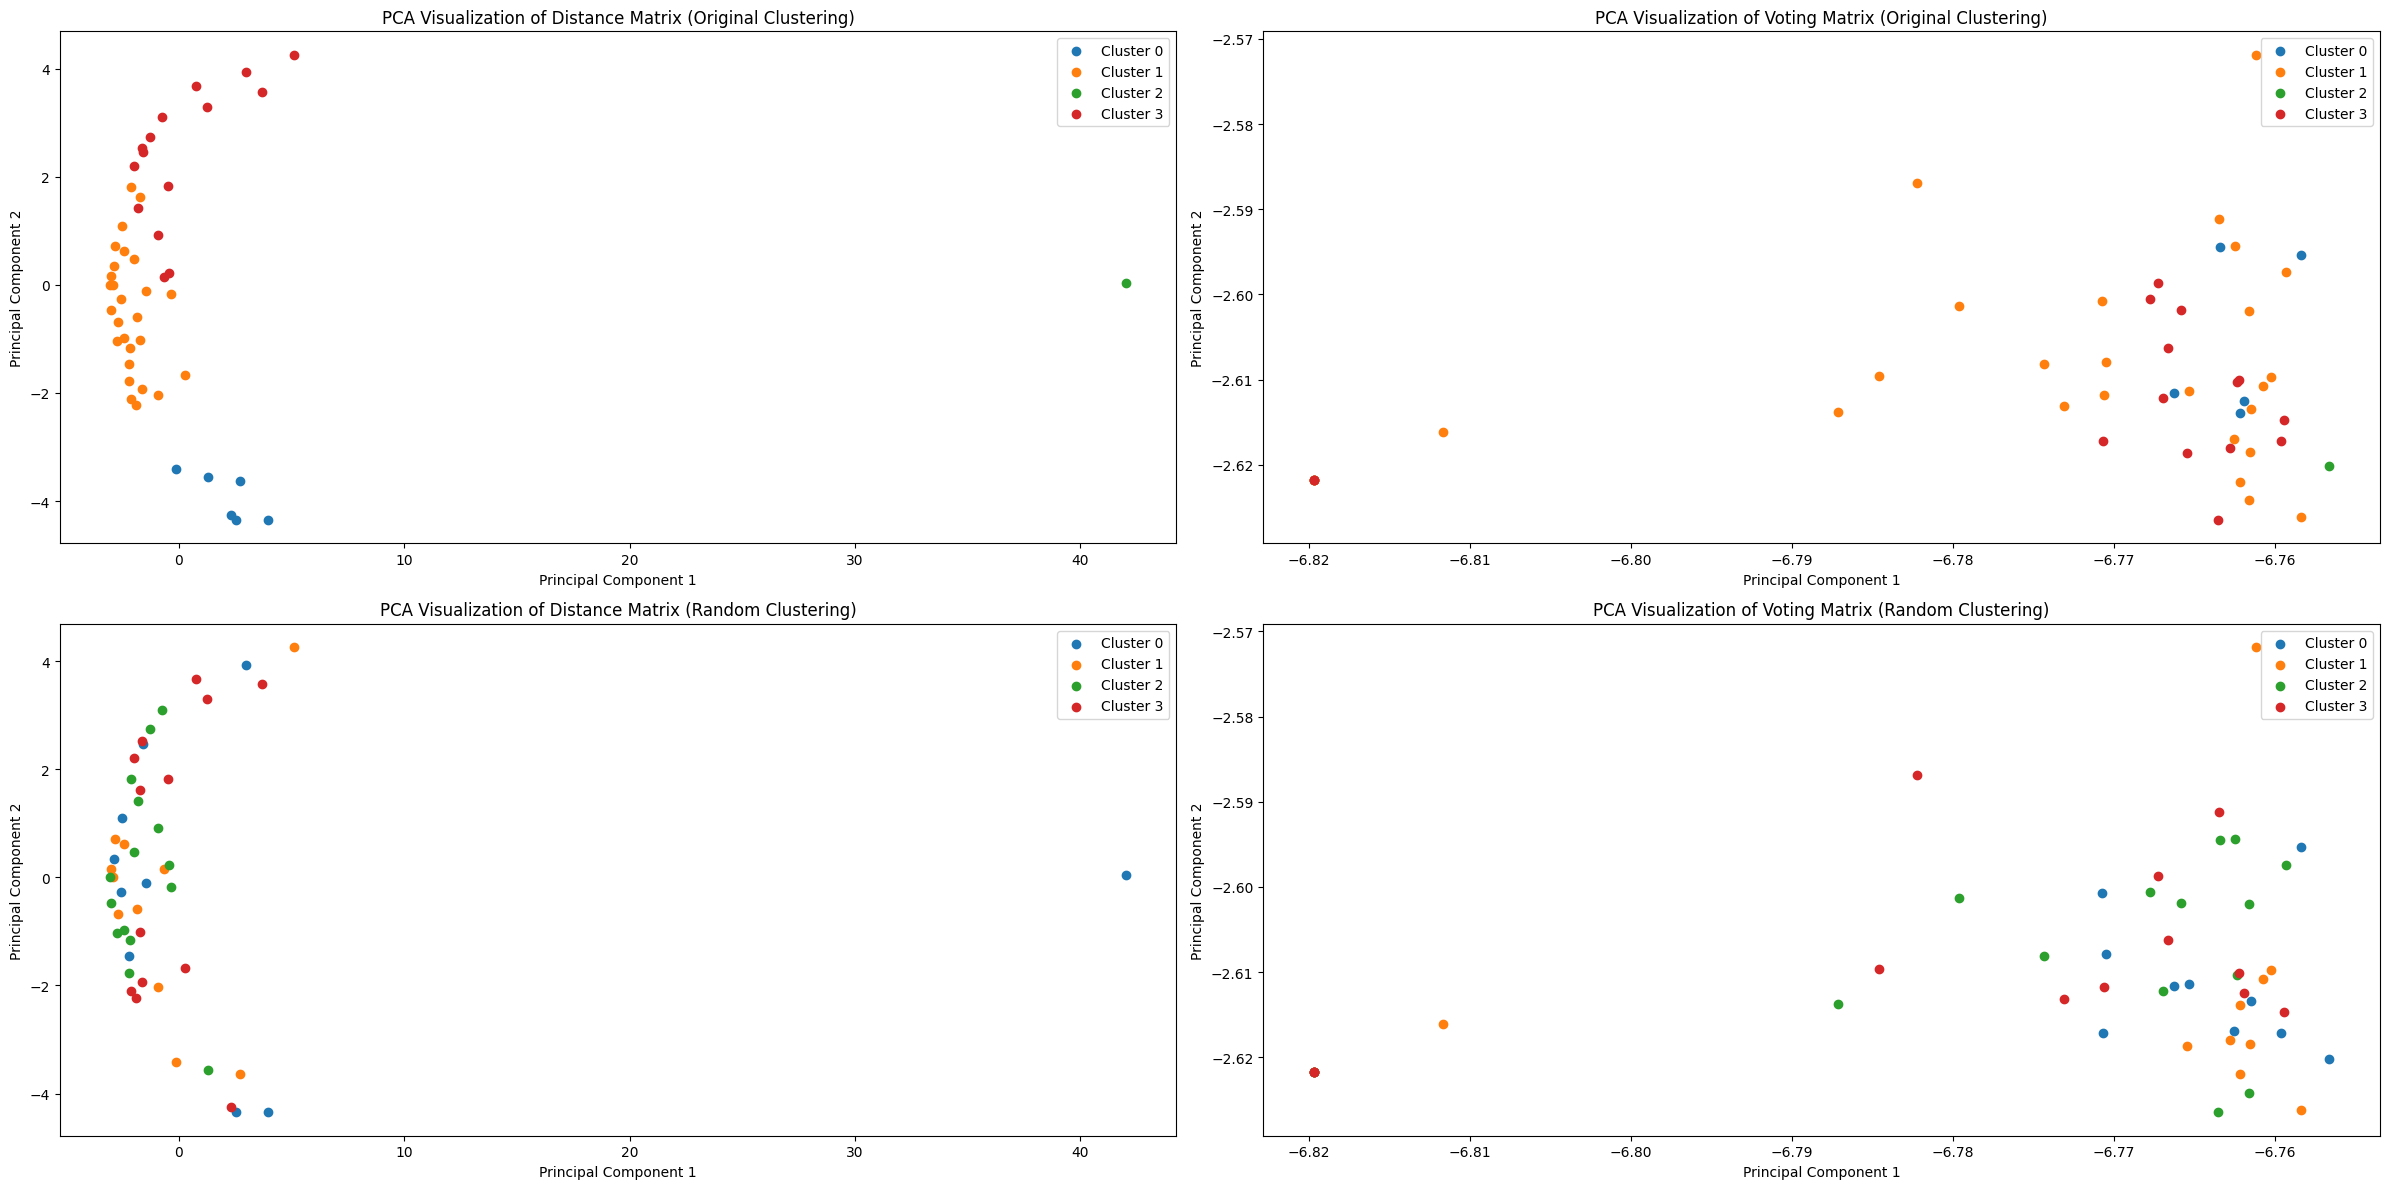

The silhouette score for Distance Matrix (Original) is: 0.34688942107354964
The silhouette score for Voting Matrix (Original) is: -0.06341753290798248
The silhouette score for Distance Matrix data (Random) is: -0.15104108270705258
The silhouette score for Voting Matrix data (Random) is: -0.054351931313245574


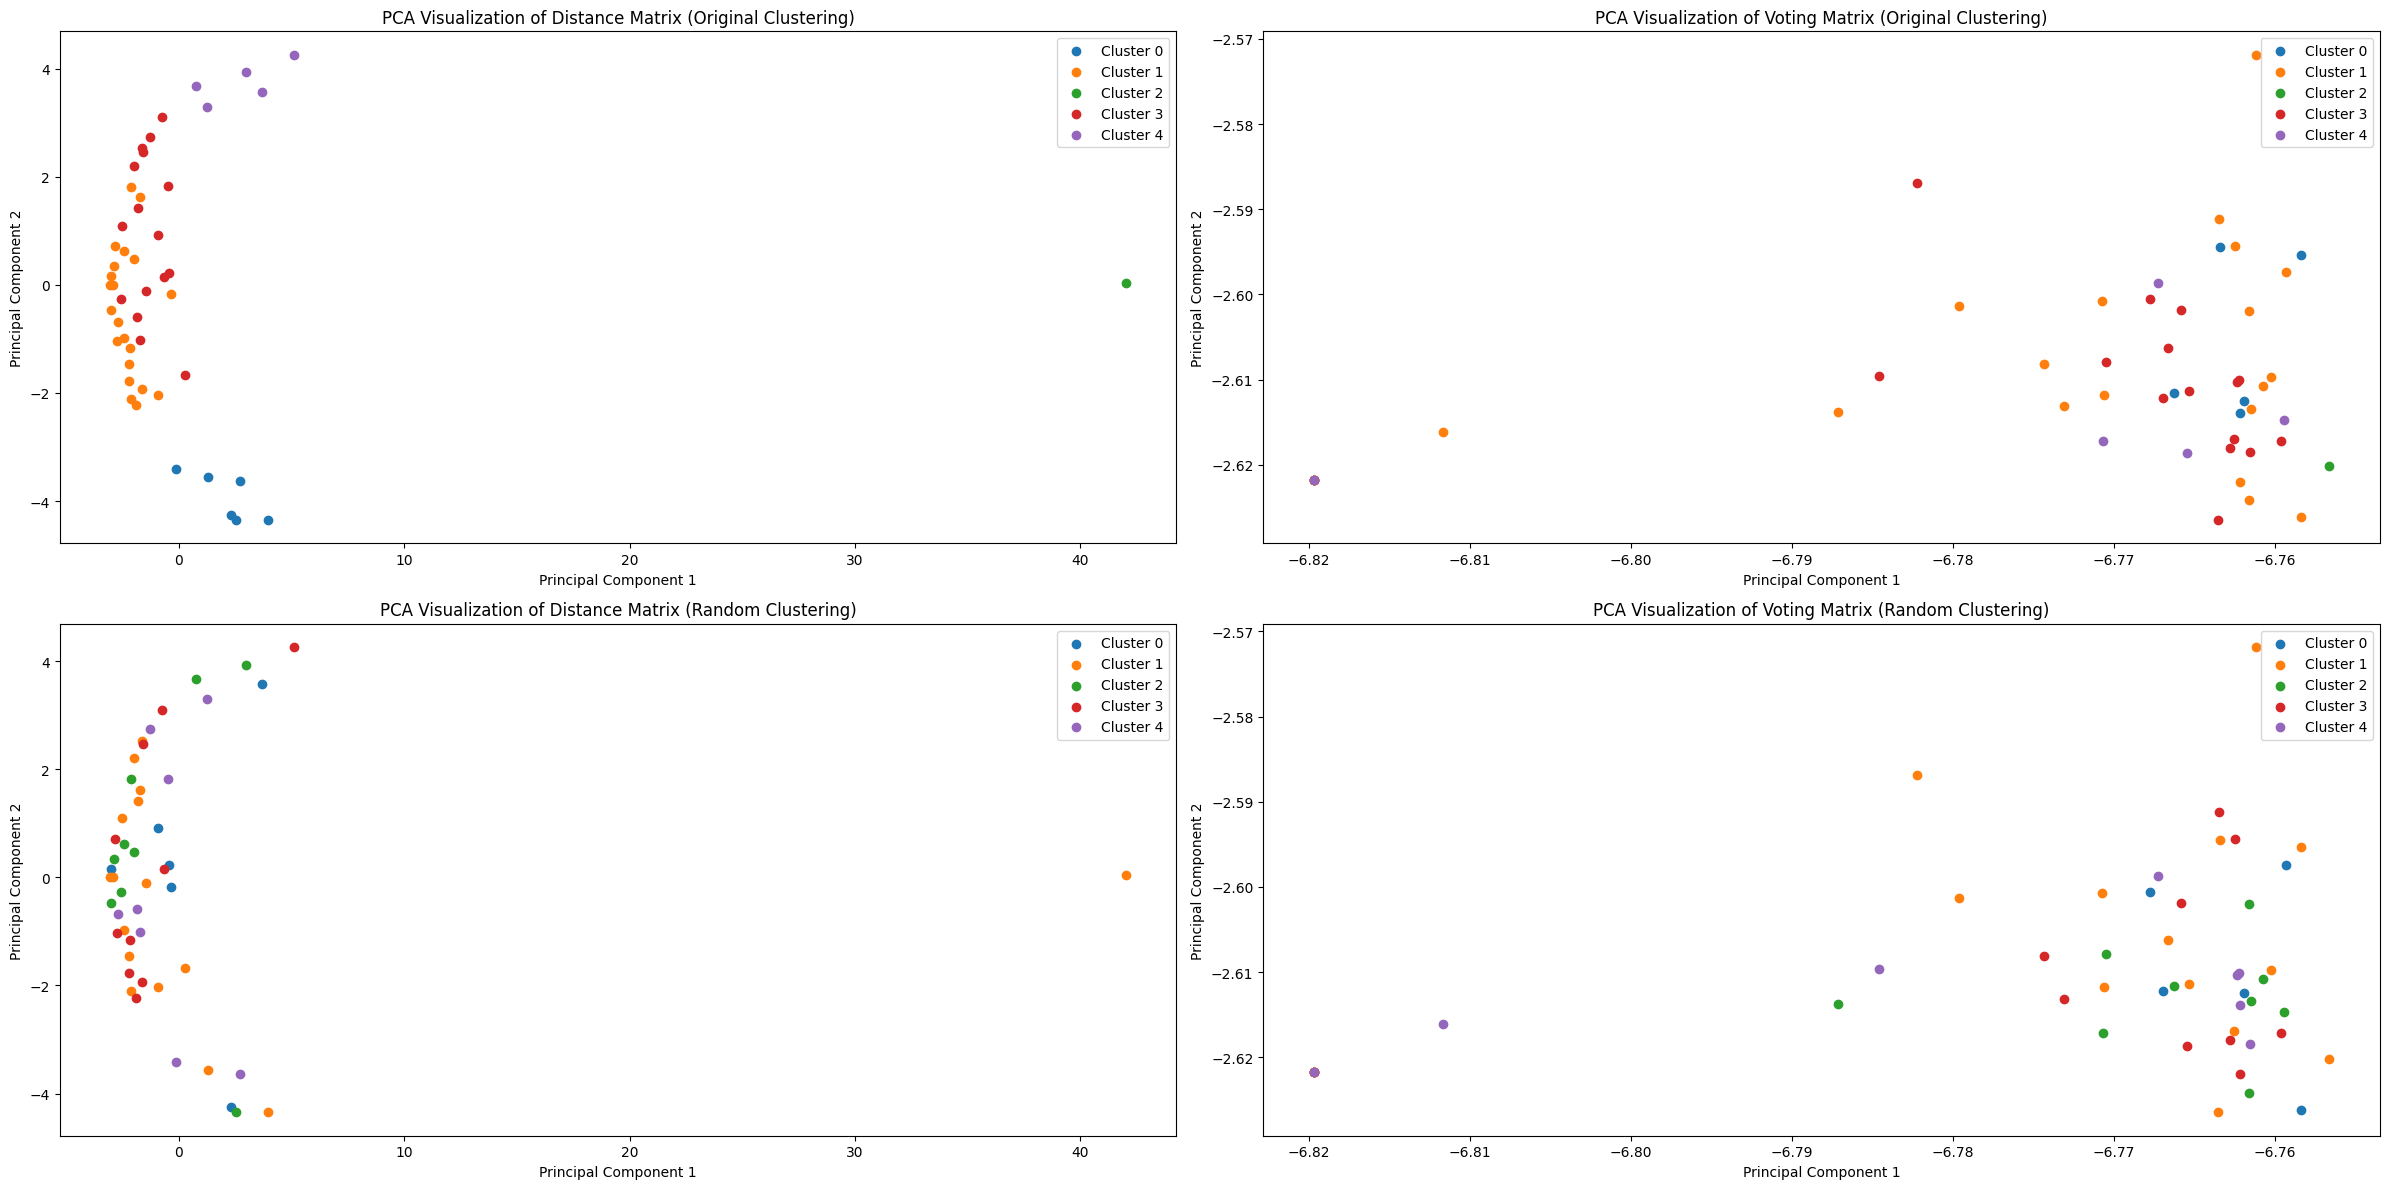

The silhouette score for Distance Matrix (Original) is: 0.36277287117431434
The silhouette score for Voting Matrix (Original) is: -0.08220180129721998
The silhouette score for Distance Matrix data (Random) is: -0.19810346423584124
The silhouette score for Voting Matrix data (Random) is: -0.07769361573286417


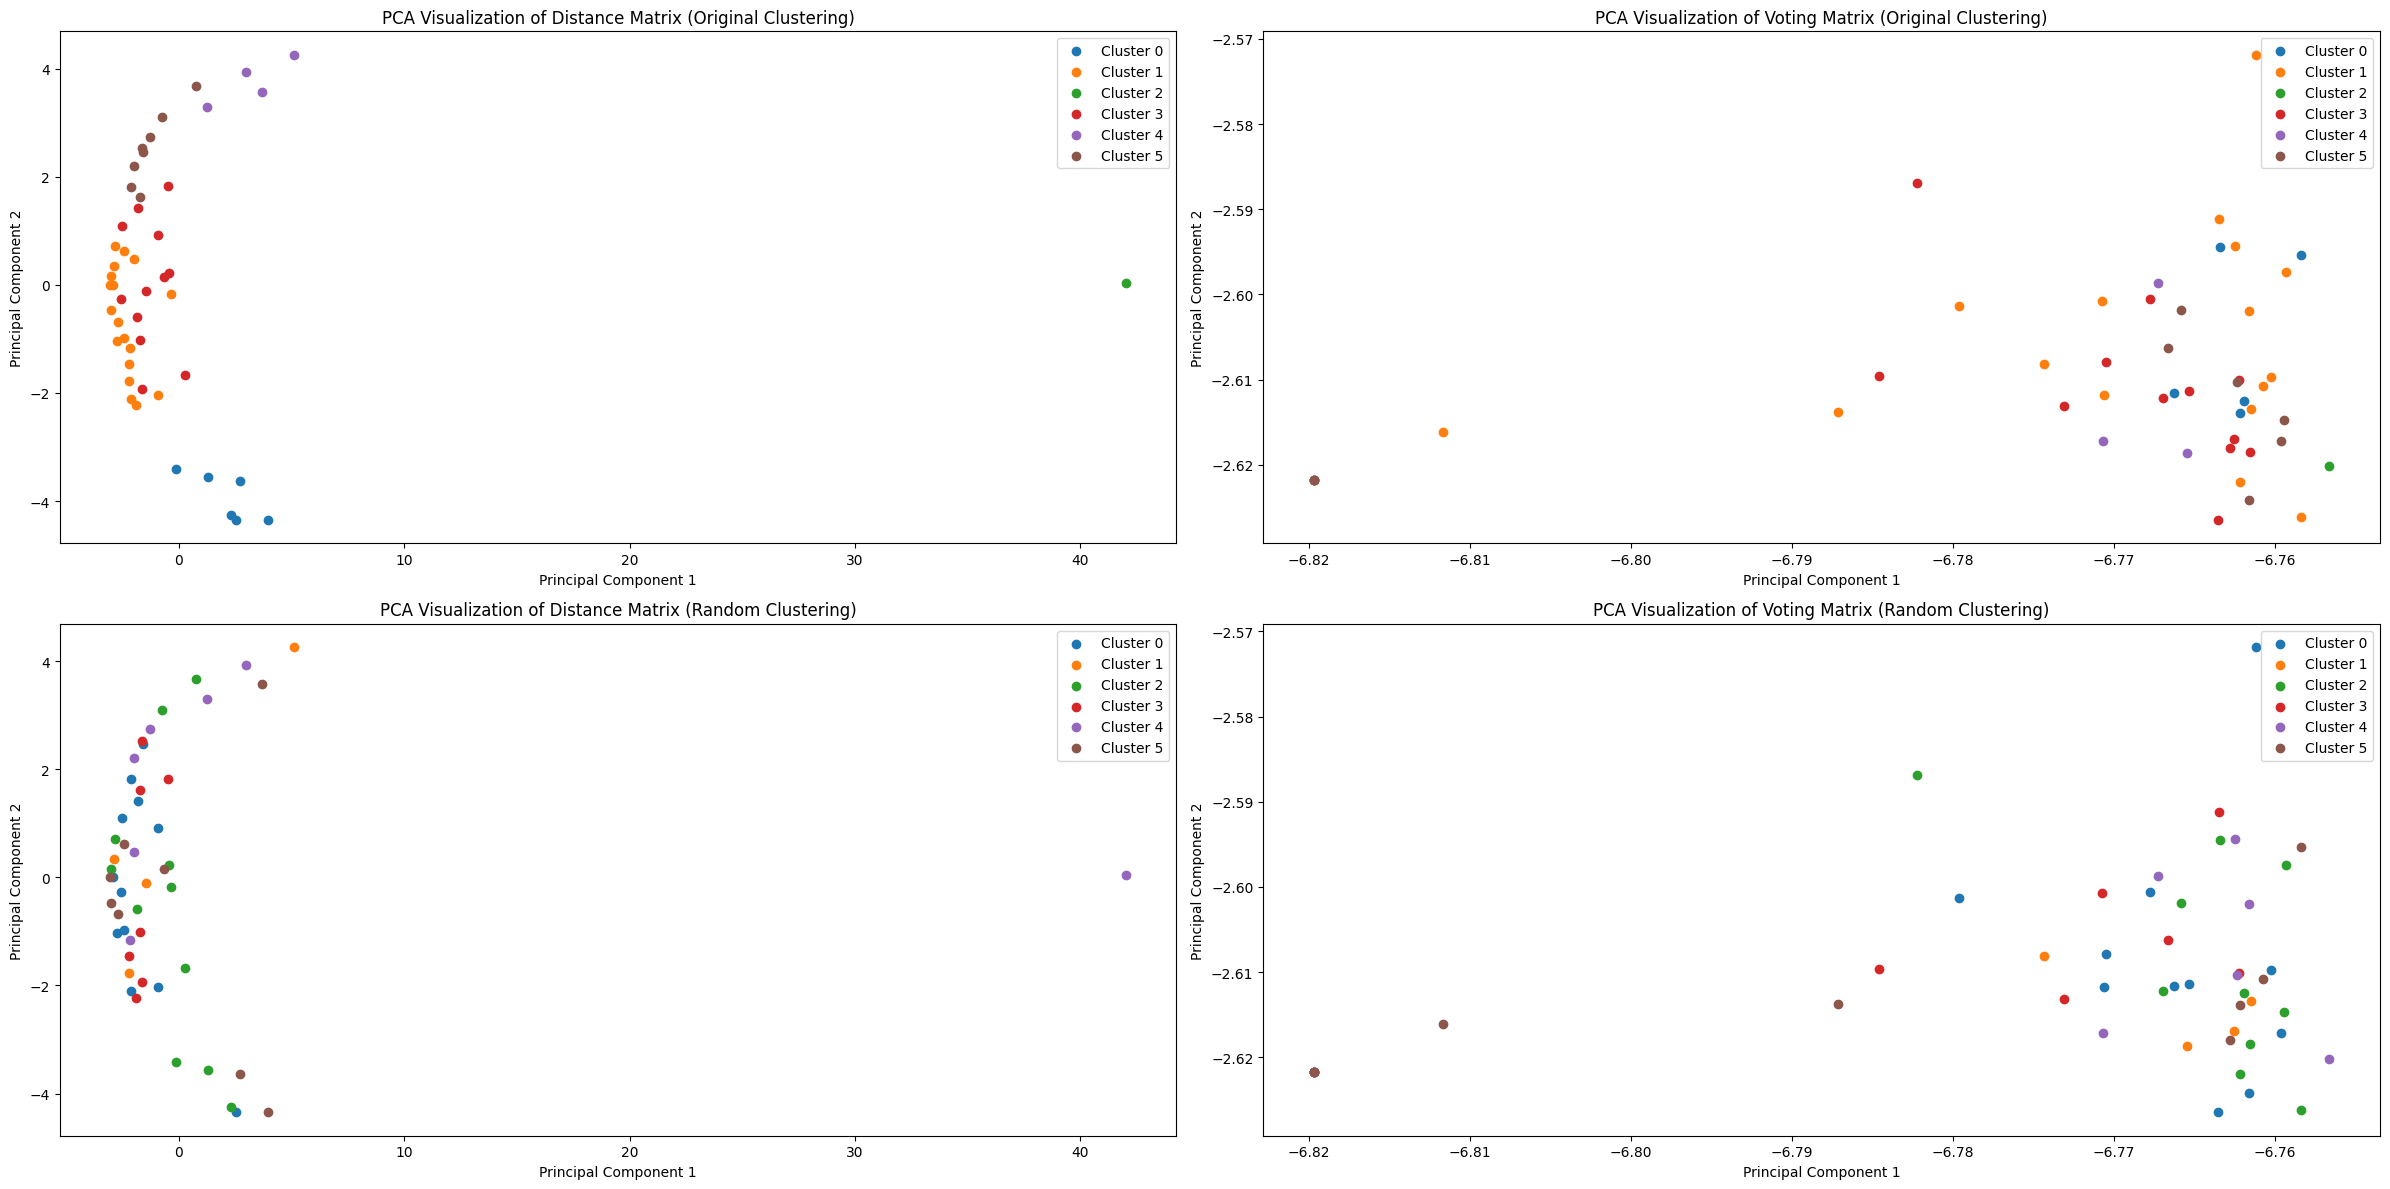

The silhouette score for Distance Matrix (Original) is: 0.4079721815423443
The silhouette score for Voting Matrix (Original) is: -0.09689396527727176
The silhouette score for Distance Matrix data (Random) is: -0.21087125232759538
The silhouette score for Voting Matrix data (Random) is: -0.10104220260726424


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


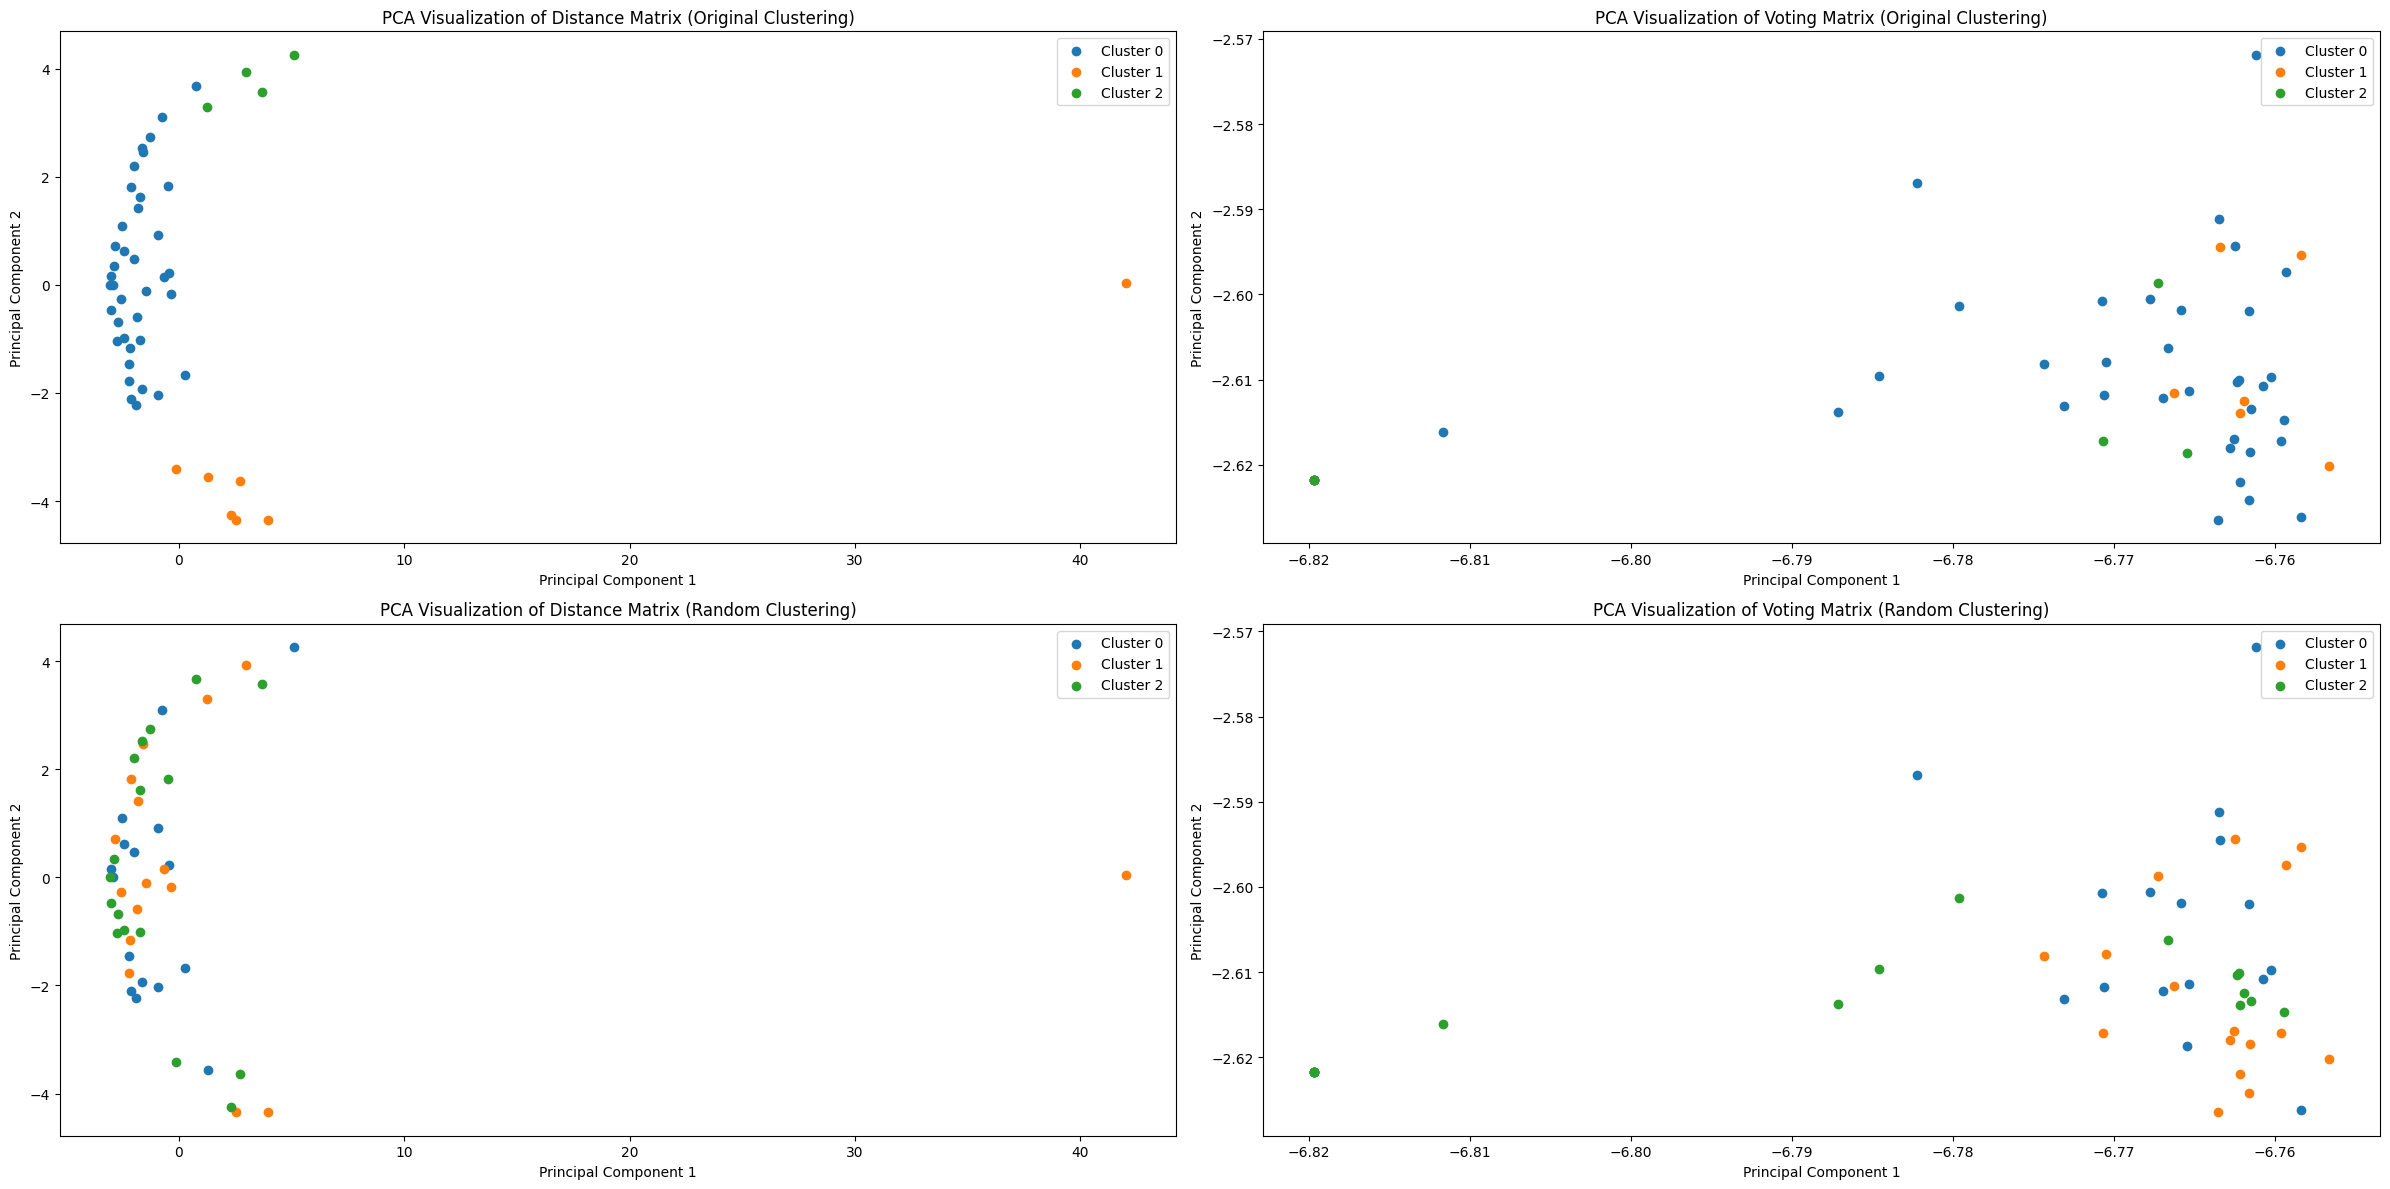

The silhouette score for Distance Matrix (Original) is: 0.42096030704694026
The silhouette score for Voting Matrix (Original) is: -0.038843634192187254
The silhouette score for Distance Matrix data (Random) is: -0.1417365156675644
The silhouette score for Voting Matrix data (Random) is: 0.03501644240865581


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


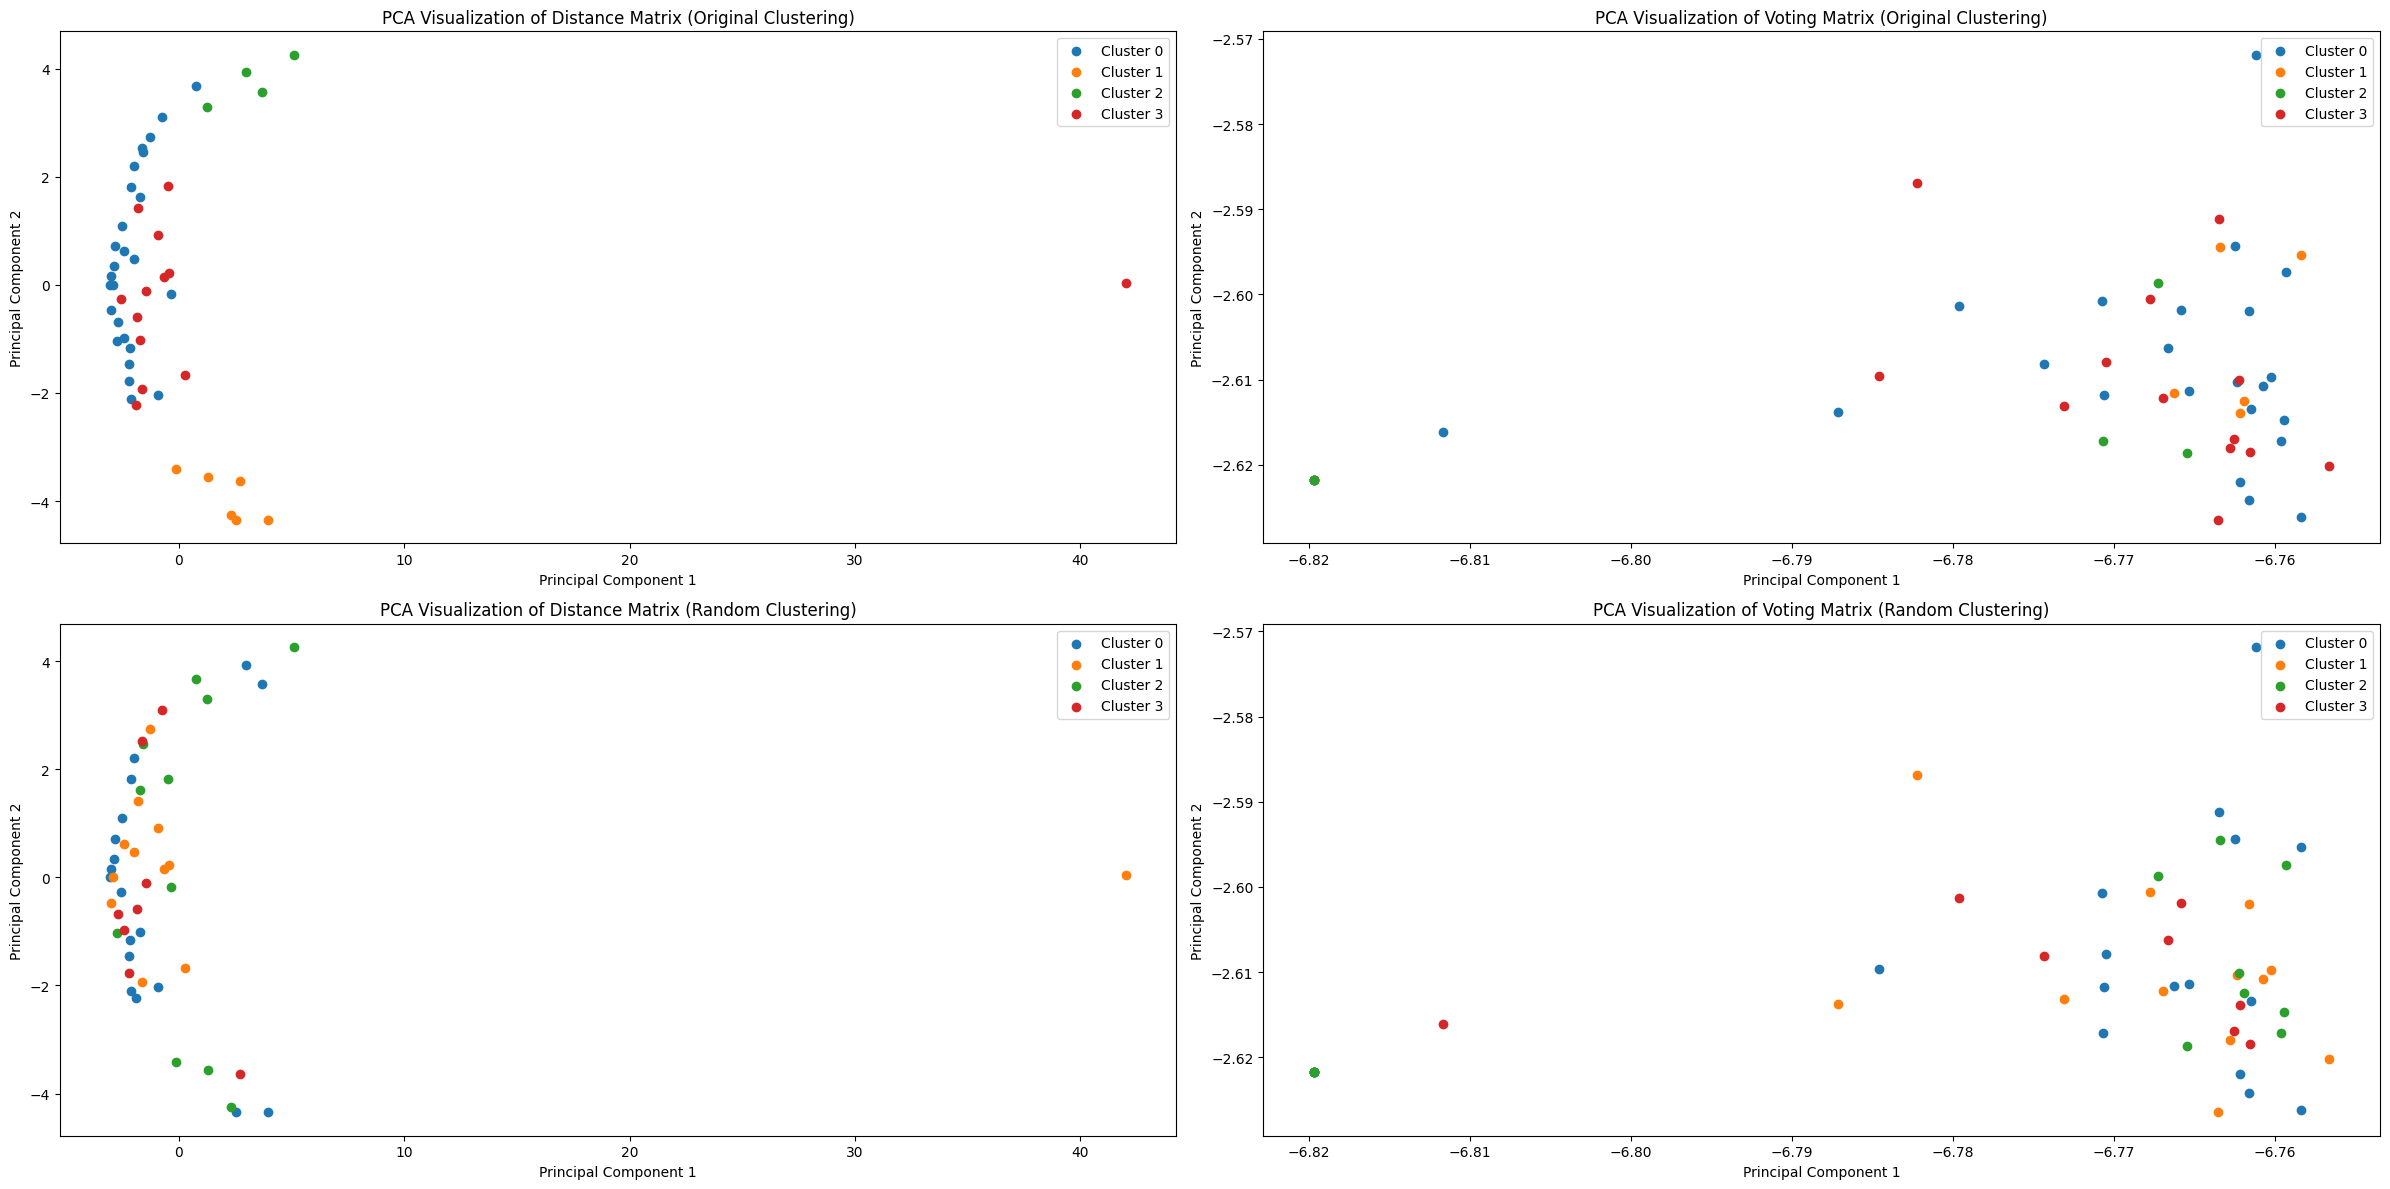

The silhouette score for Distance Matrix (Original) is: 0.3015845155402666
The silhouette score for Voting Matrix (Original) is: -0.06104971302074051
The silhouette score for Distance Matrix data (Random) is: -0.1754339952785944
The silhouette score for Voting Matrix data (Random) is: -0.049687345006083024


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


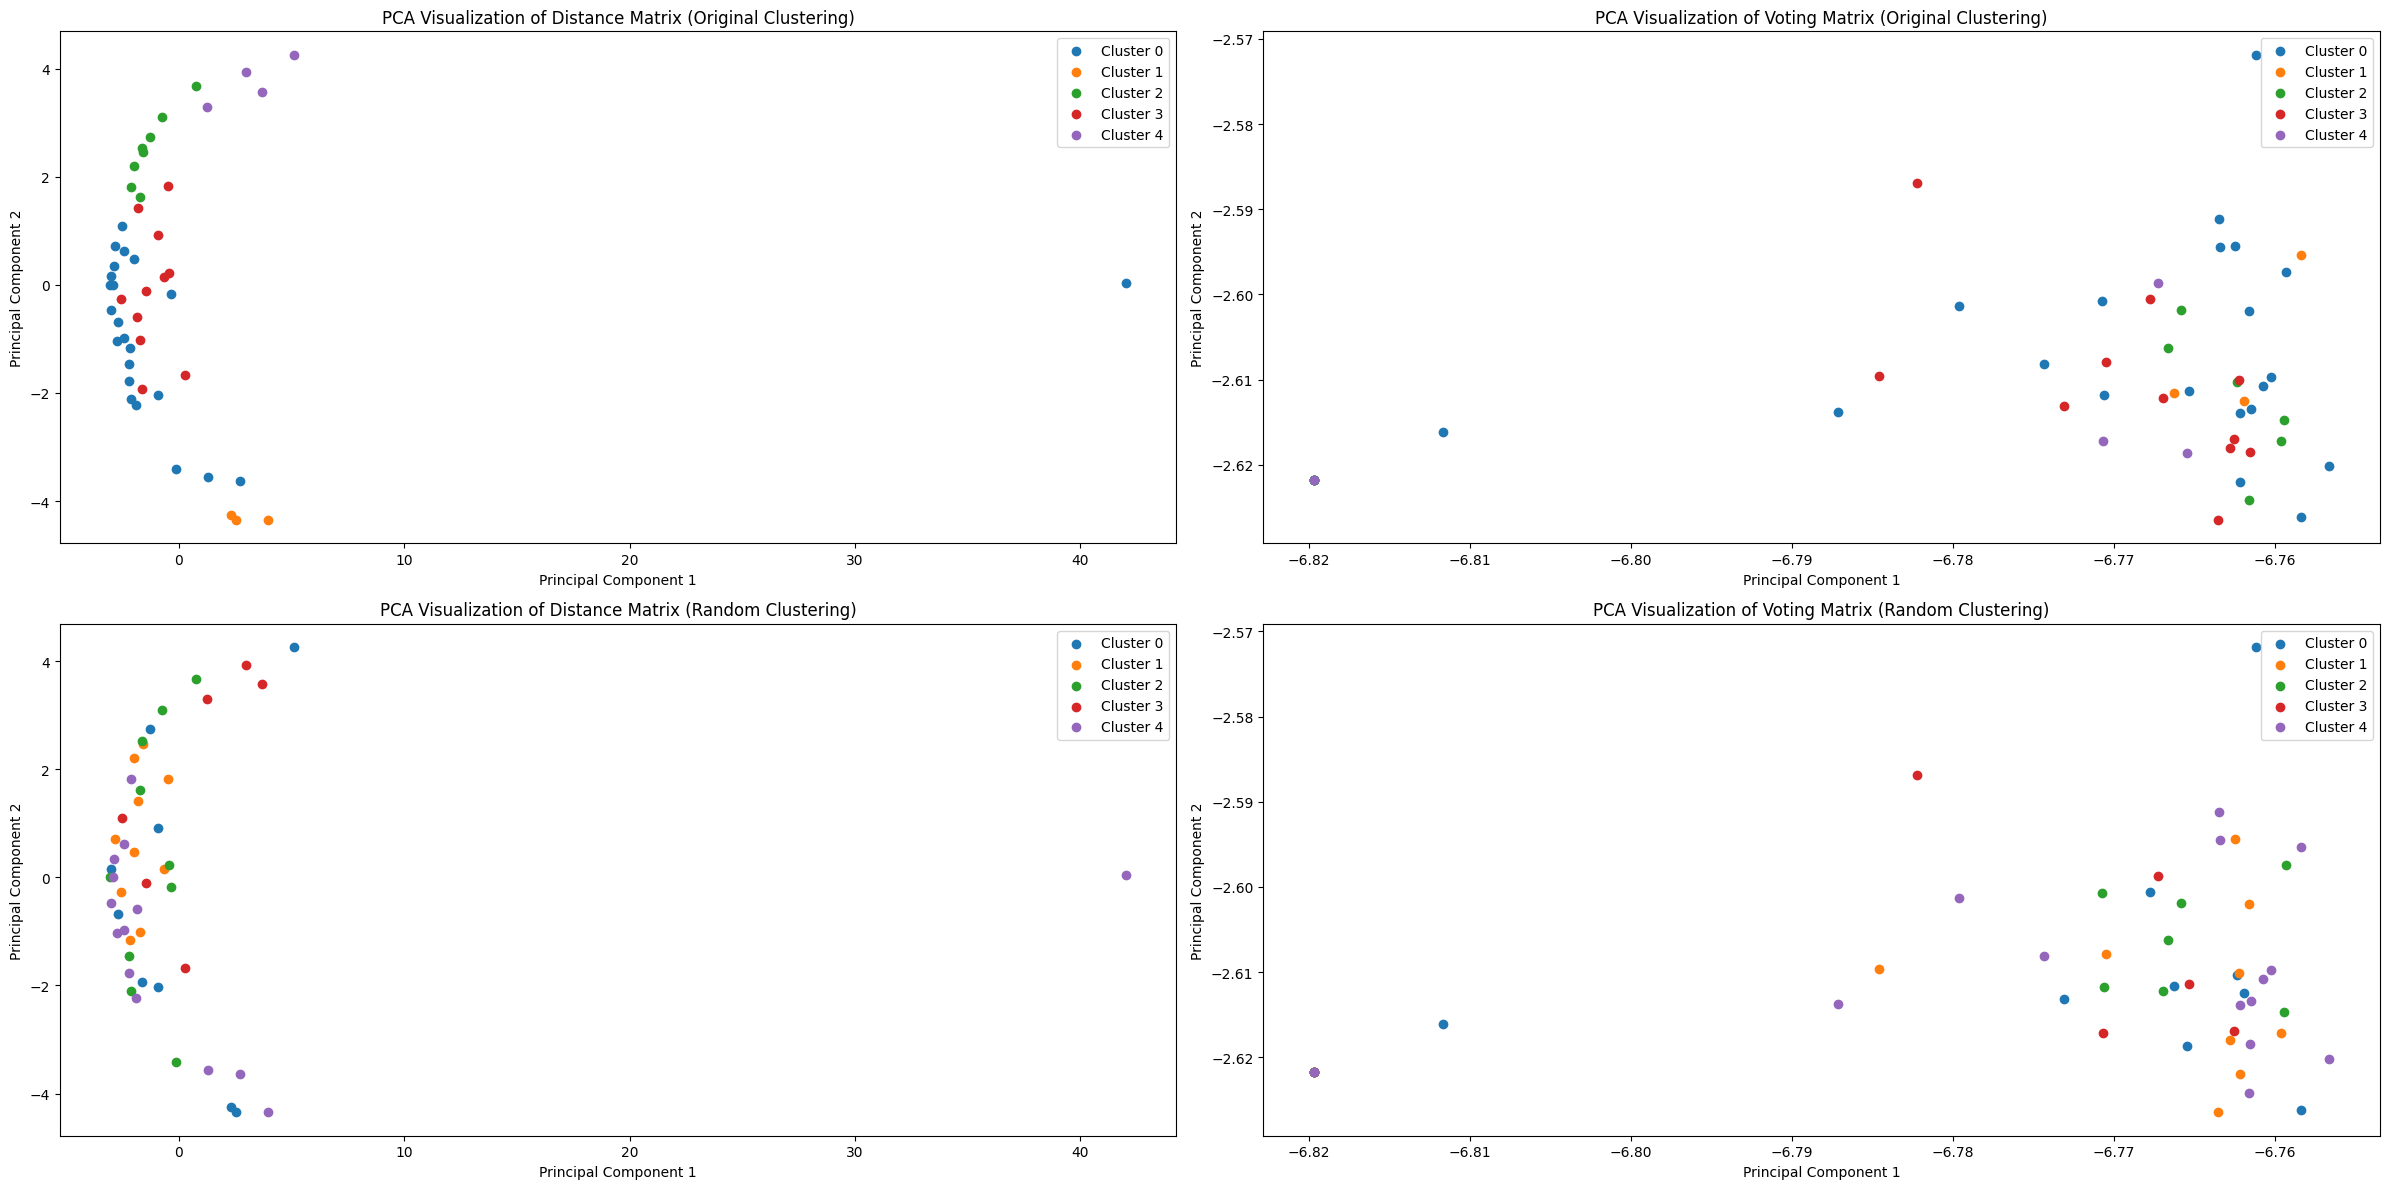

The silhouette score for Distance Matrix (Original) is: 0.15855320161478026
The silhouette score for Voting Matrix (Original) is: -0.07532693591657169
The silhouette score for Distance Matrix data (Random) is: -0.19511477047277076
The silhouette score for Voting Matrix data (Random) is: -0.0548561348319626


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


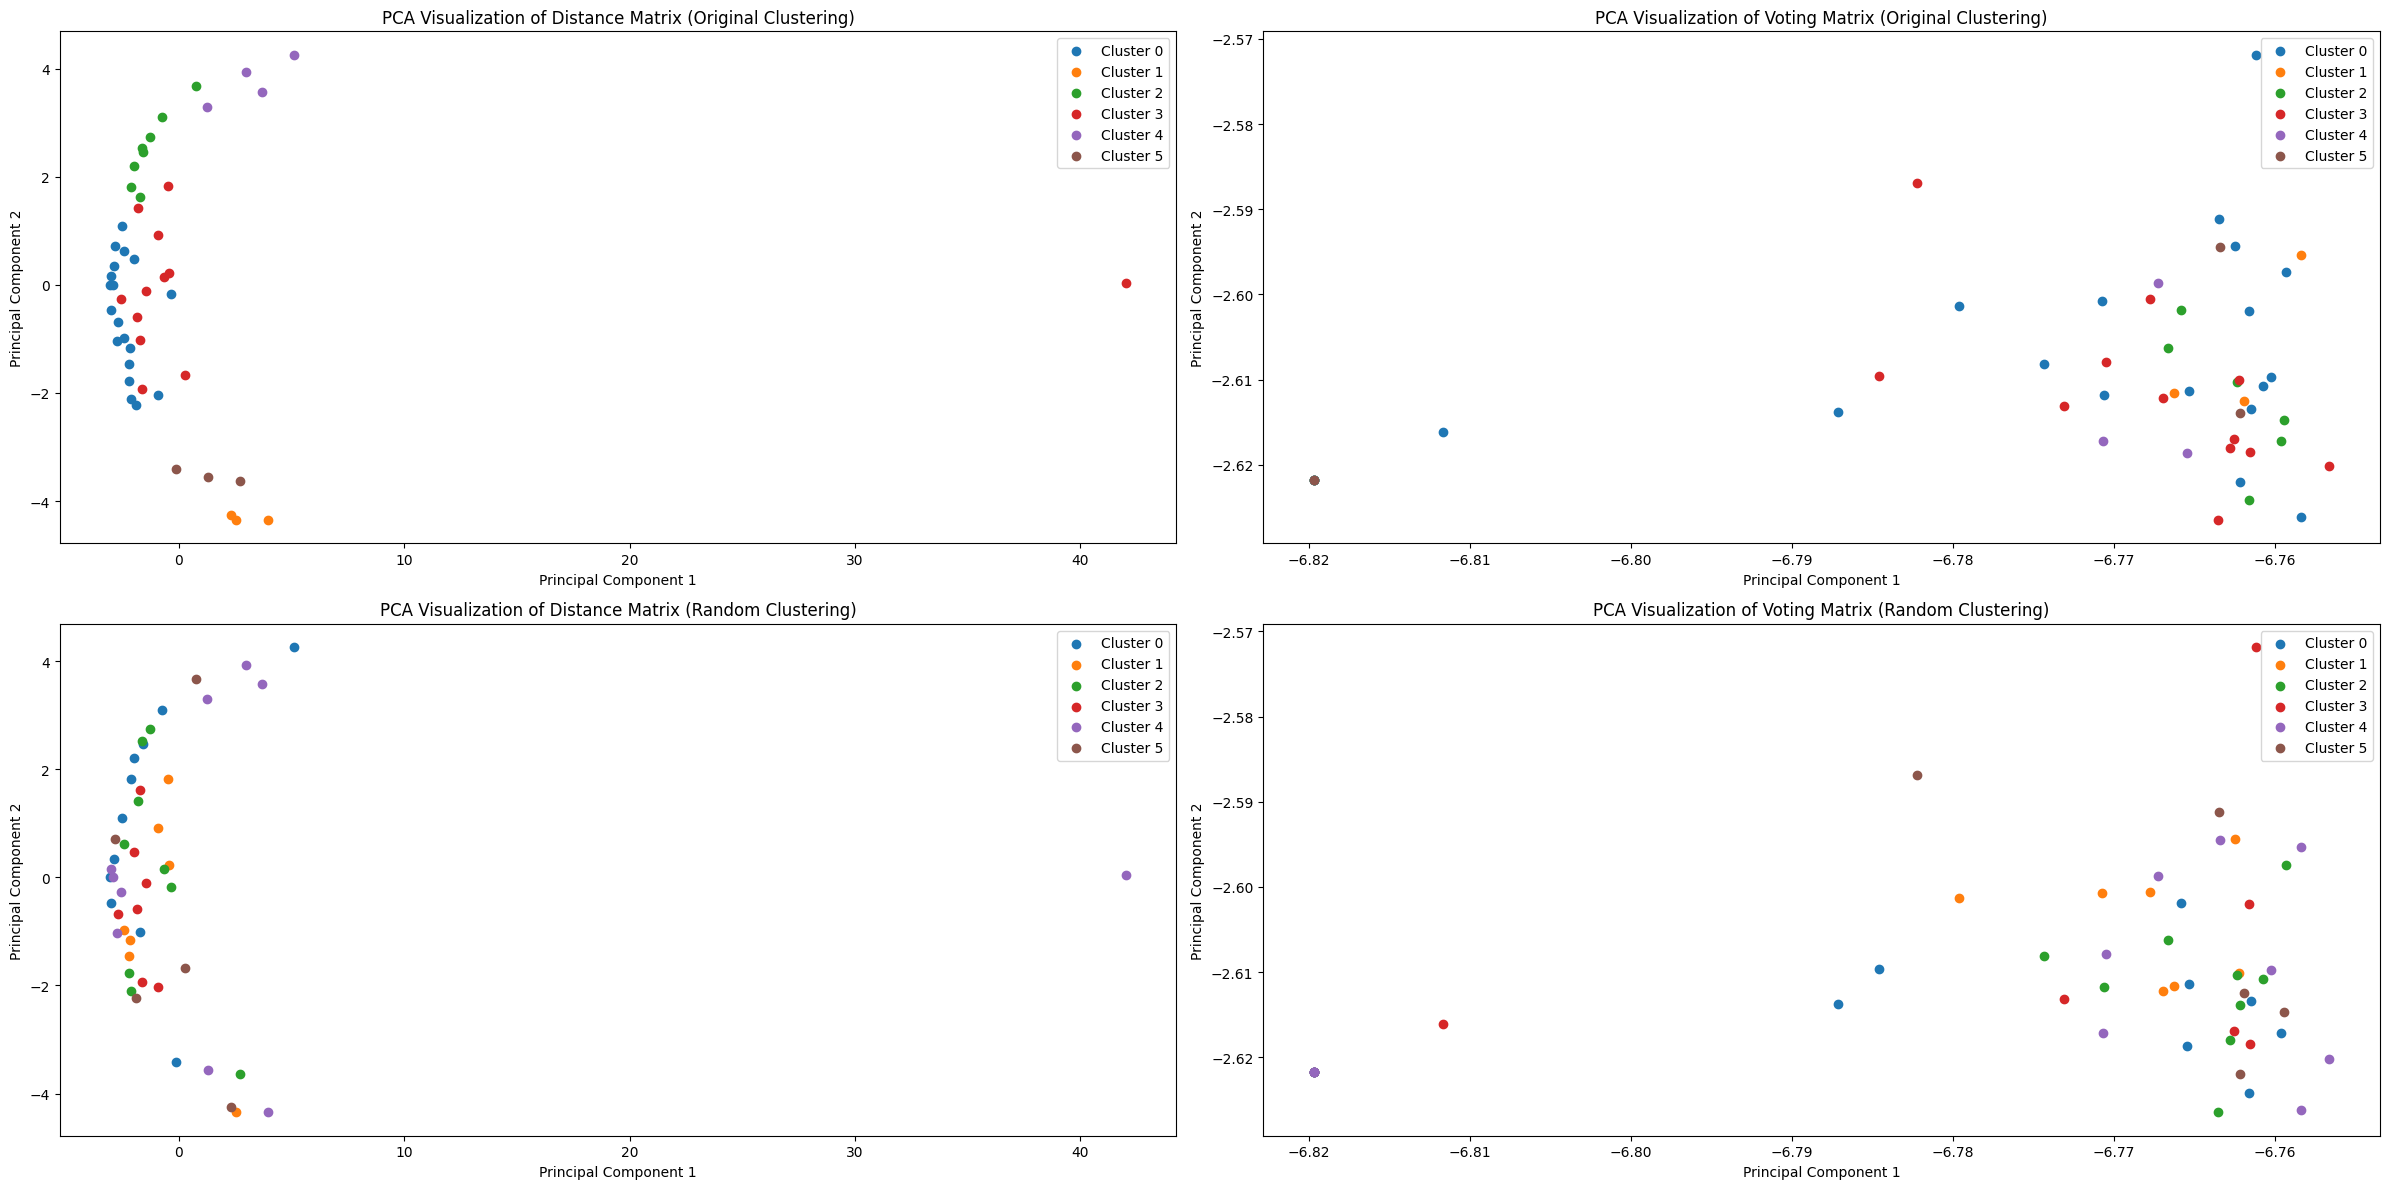

The silhouette score for Distance Matrix (Original) is: 0.2277230327024865
The silhouette score for Voting Matrix (Original) is: -0.08272009967971752
The silhouette score for Distance Matrix data (Random) is: -0.2095676500028469
The silhouette score for Voting Matrix data (Random) is: -0.08437701610460883


In [5]:
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_jury, 6, method='SpectralClustering')

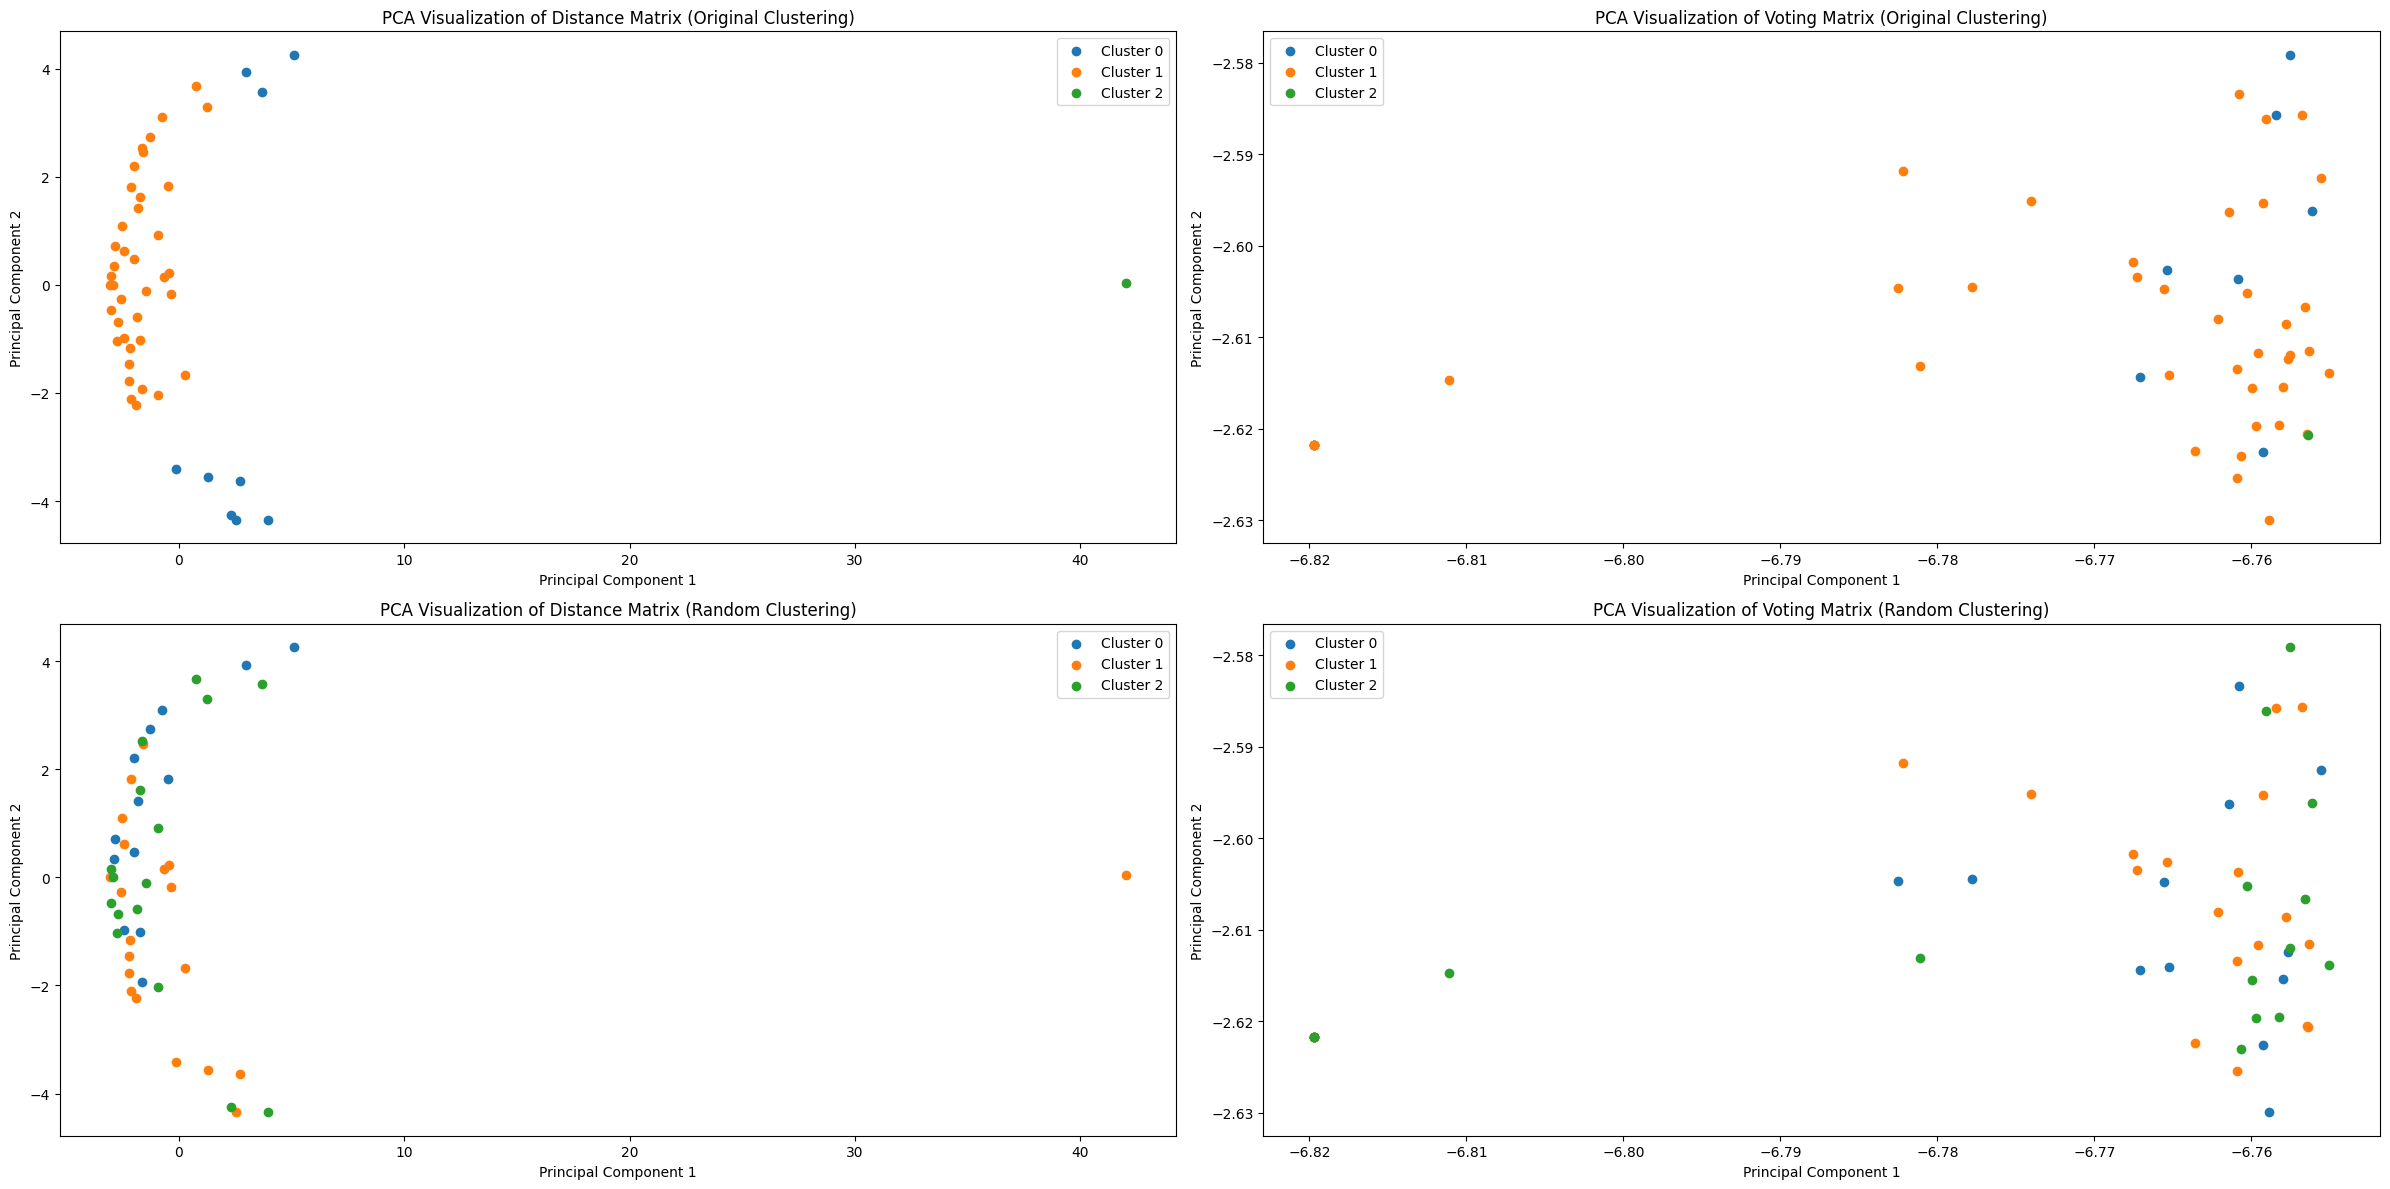

The silhouette score for Distance Matrix (Original) is: 0.43565657070273434
The silhouette score for Voting Matrix (Original) is: -0.13651550702319623
The silhouette score for Distance Matrix data (Random) is: -0.13369853934354006
The silhouette score for Voting Matrix data (Random) is: -0.024349156989543545


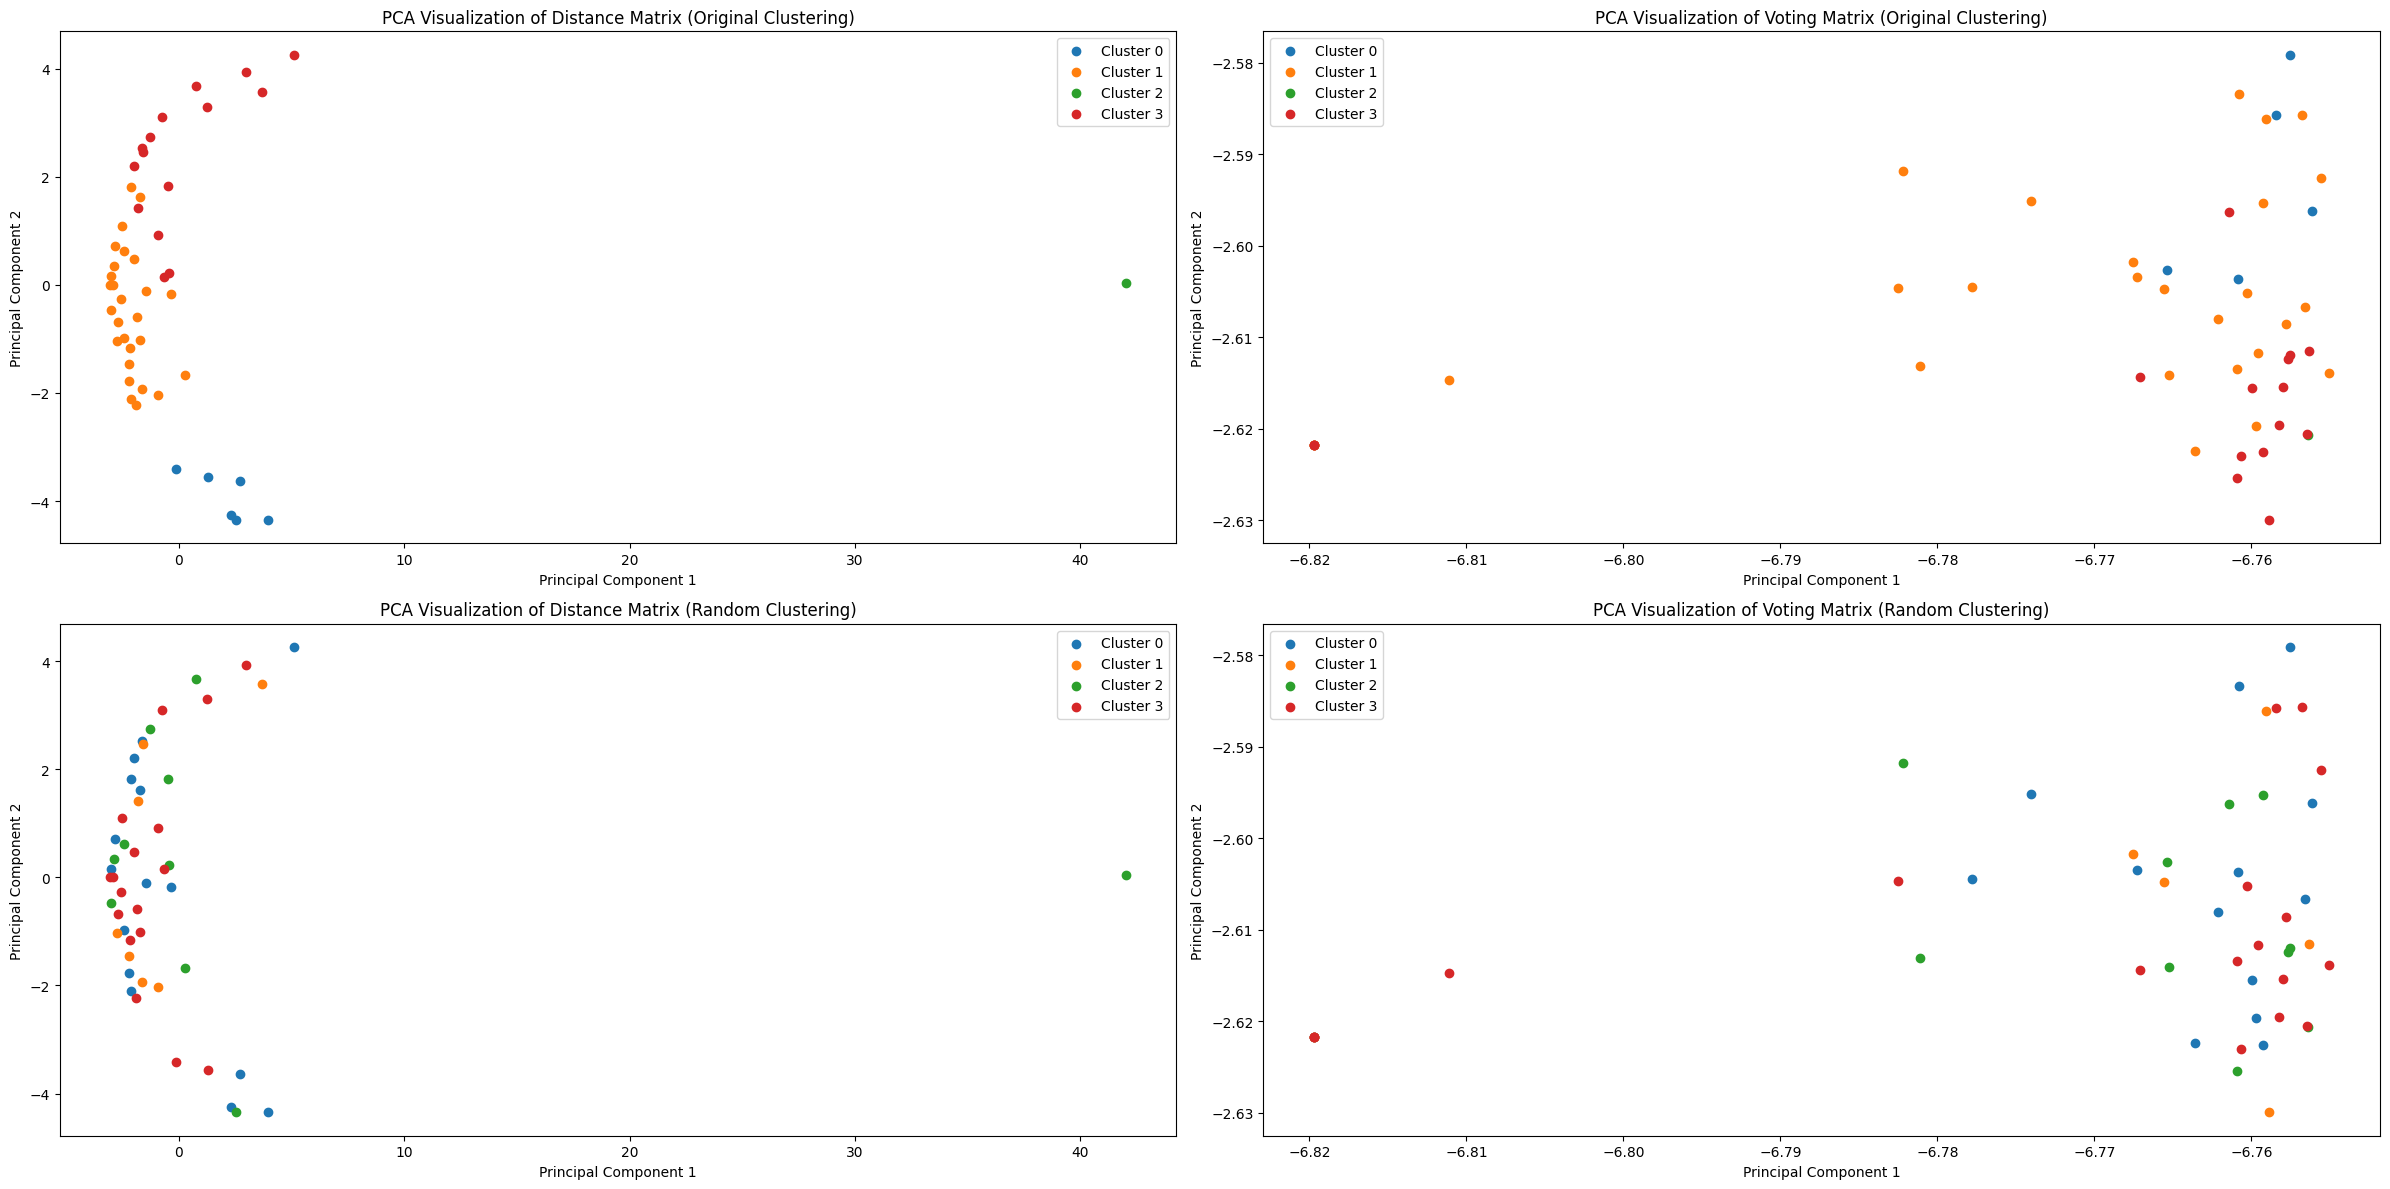

The silhouette score for Distance Matrix (Original) is: 0.34688942107354964
The silhouette score for Voting Matrix (Original) is: -0.11308286152220981
The silhouette score for Distance Matrix data (Random) is: -0.15578036410130794
The silhouette score for Voting Matrix data (Random) is: -0.05613102624260122


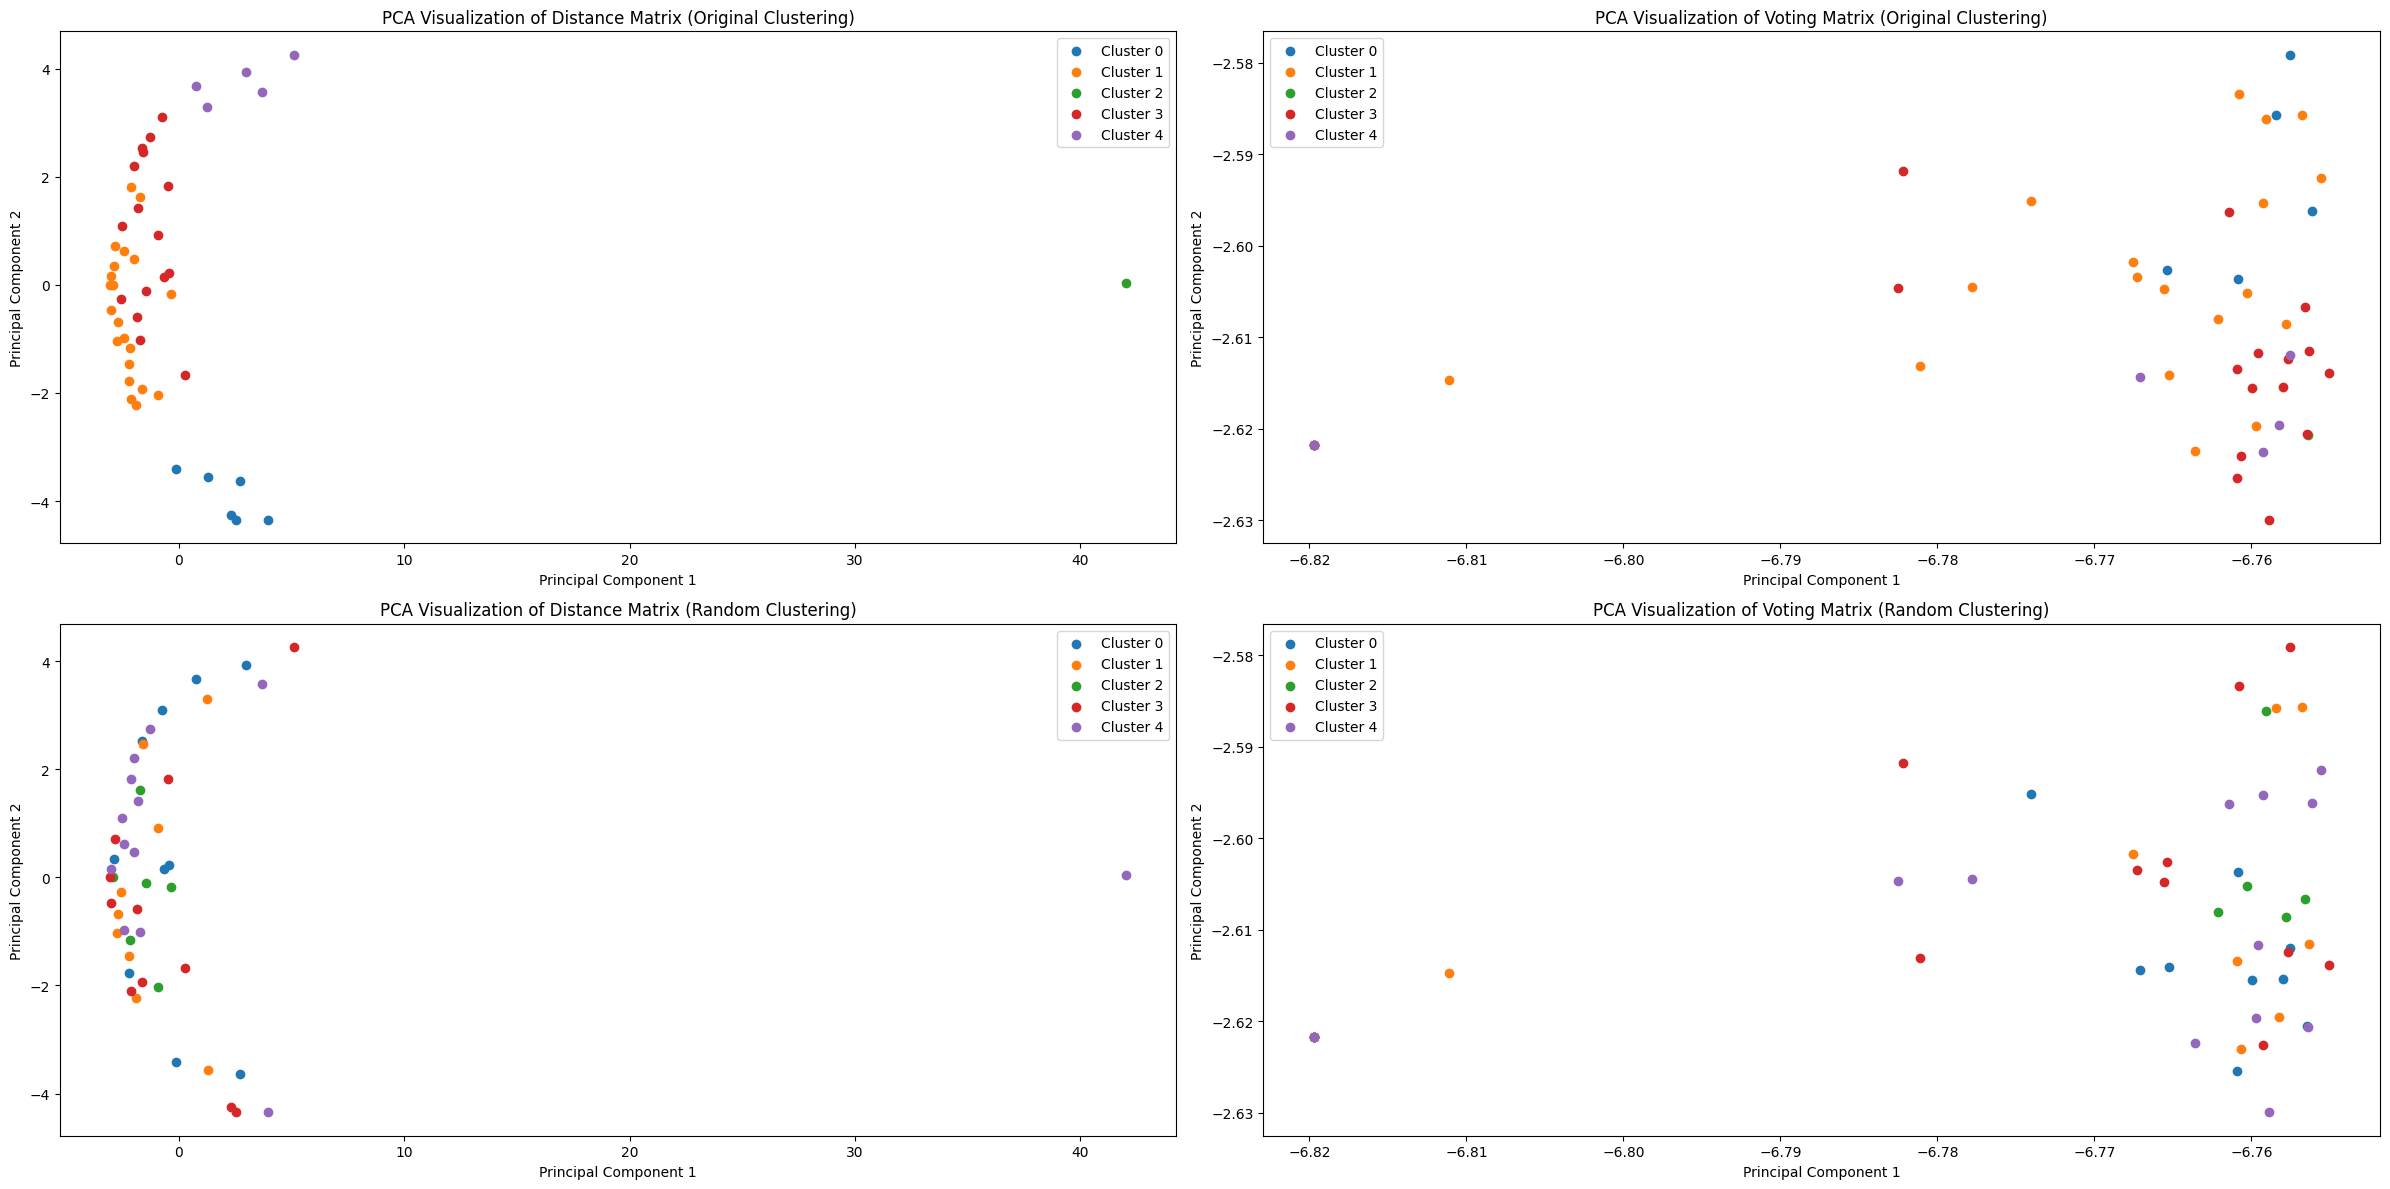

The silhouette score for Distance Matrix (Original) is: 0.36277287117431434
The silhouette score for Voting Matrix (Original) is: -0.12073481317857804
The silhouette score for Distance Matrix data (Random) is: -0.2190007326873808
The silhouette score for Voting Matrix data (Random) is: -0.04933319388364942


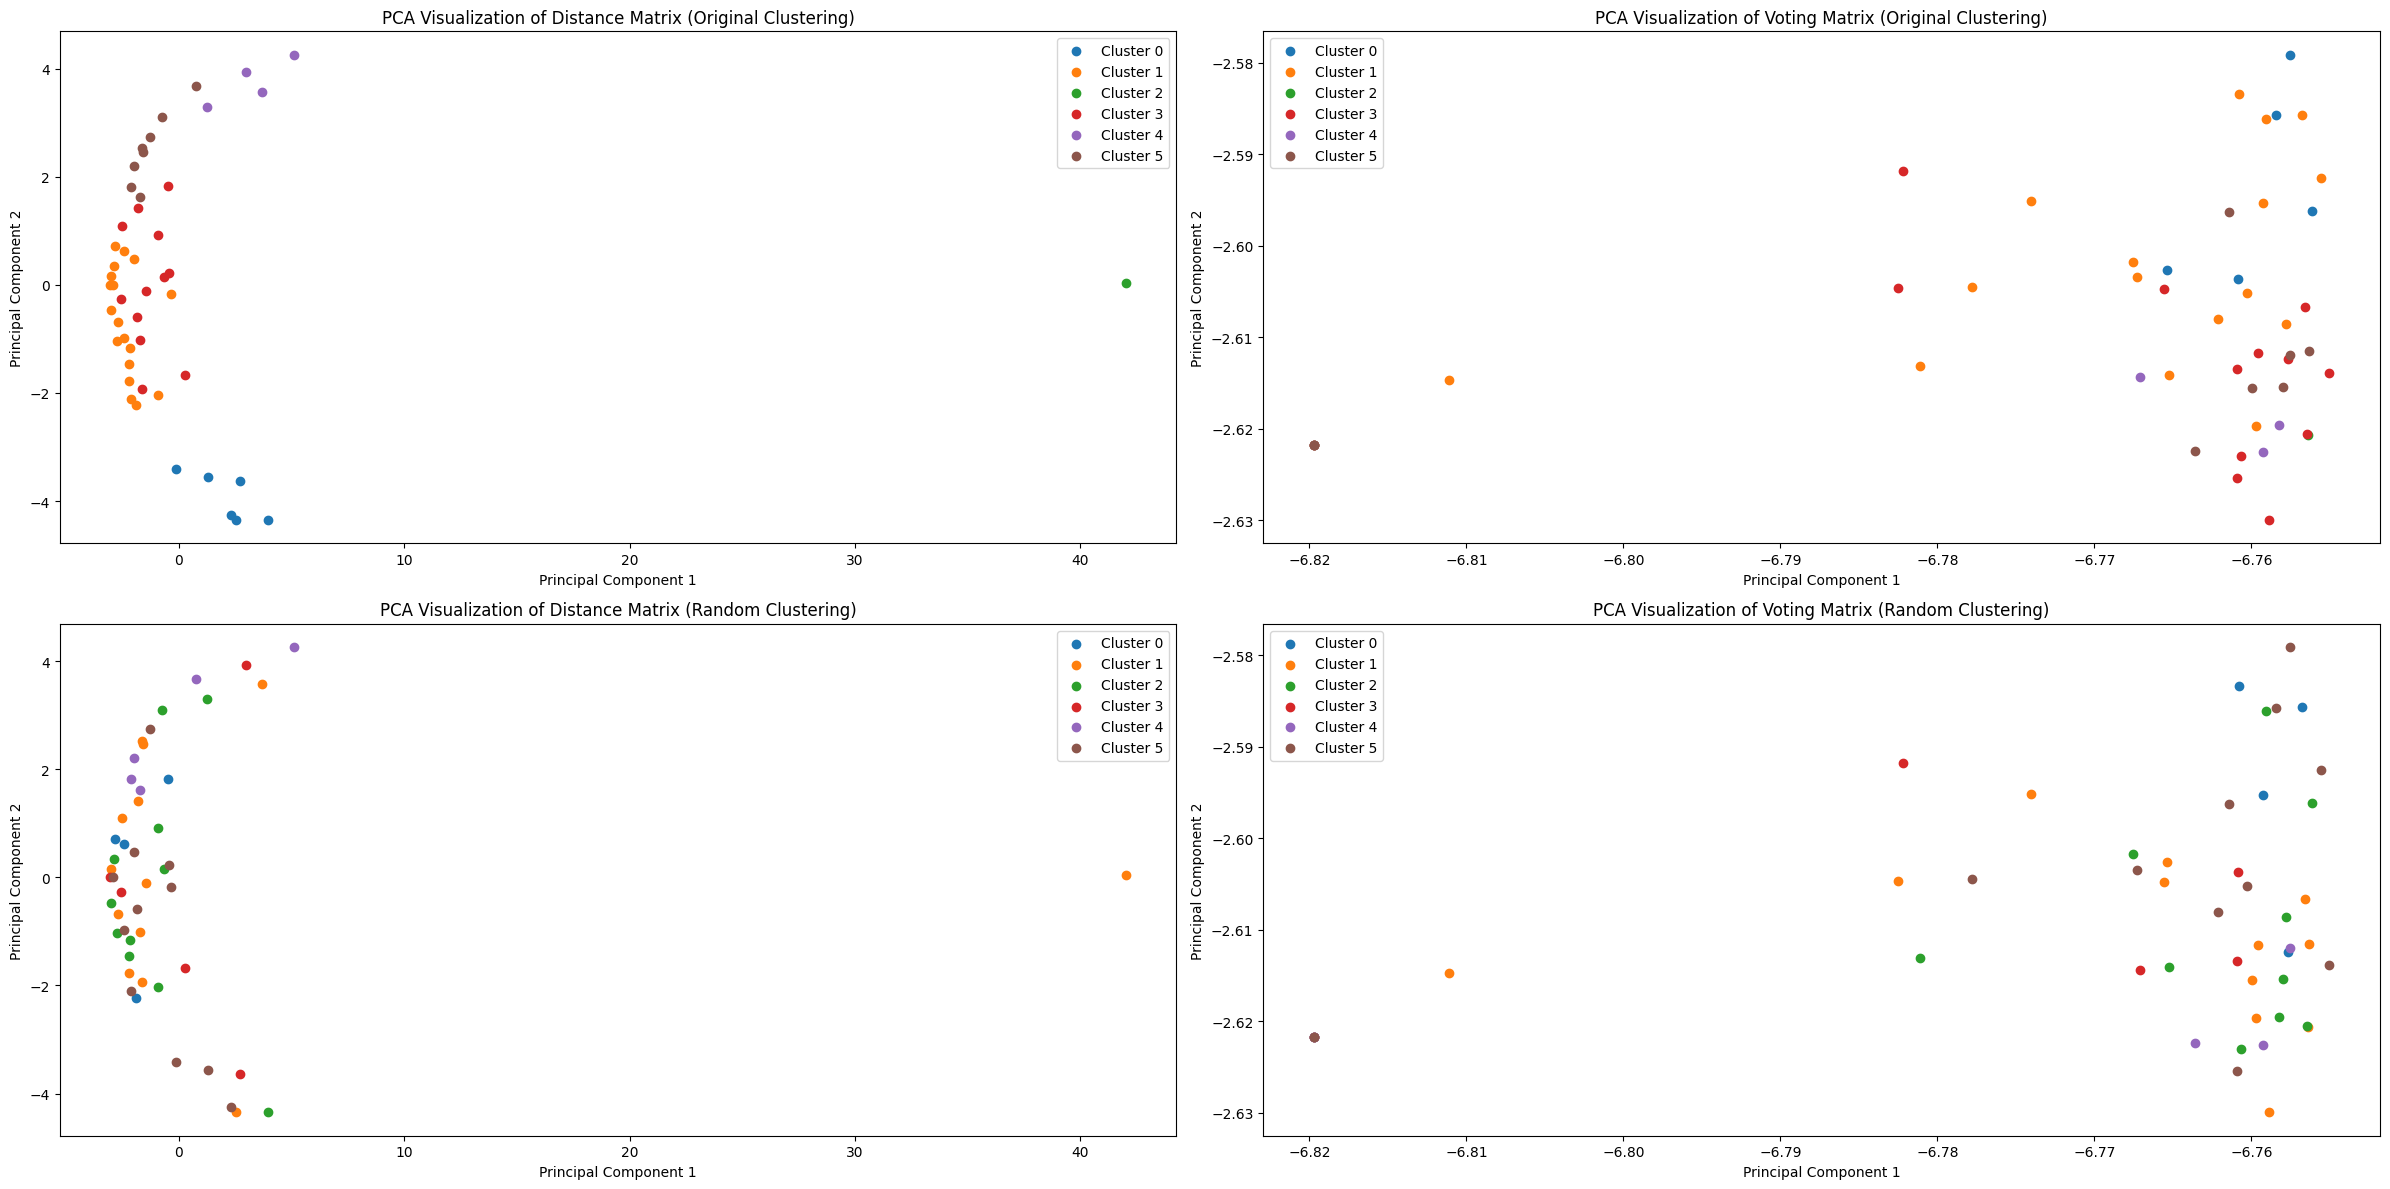

The silhouette score for Distance Matrix (Original) is: 0.4079721815423443
The silhouette score for Voting Matrix (Original) is: -0.12503876662690544
The silhouette score for Distance Matrix data (Random) is: -0.27135872994276367
The silhouette score for Voting Matrix data (Random) is: -0.08423889874362277


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


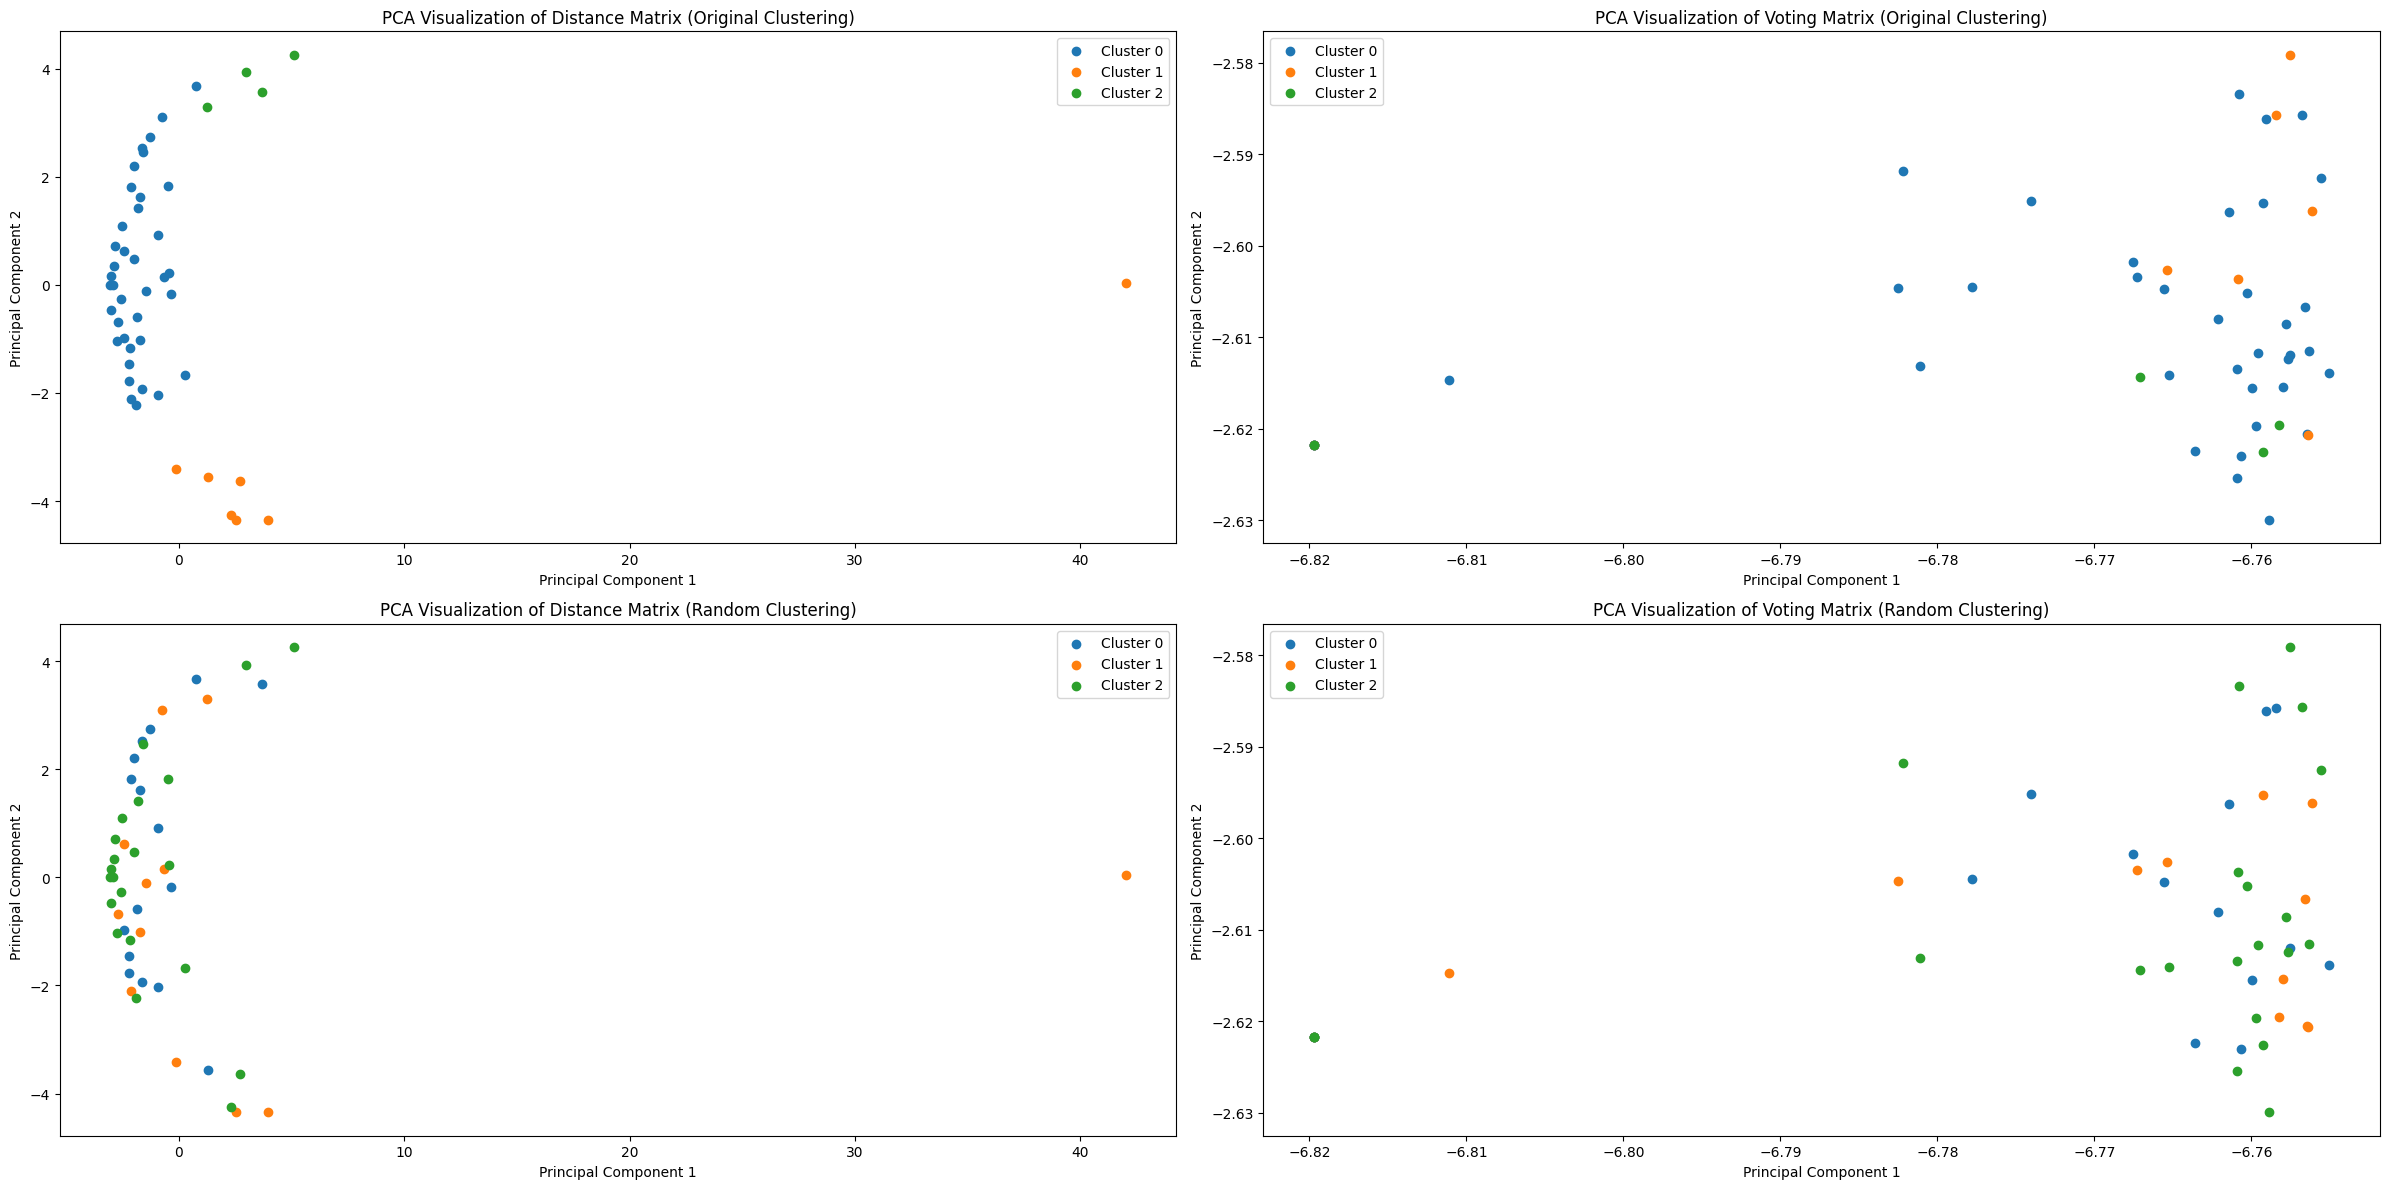

The silhouette score for Distance Matrix (Original) is: 0.42096030704694026
The silhouette score for Voting Matrix (Original) is: -0.055602108379247214
The silhouette score for Distance Matrix data (Random) is: -0.1021535197330571
The silhouette score for Voting Matrix data (Random) is: -0.030584598666758243


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


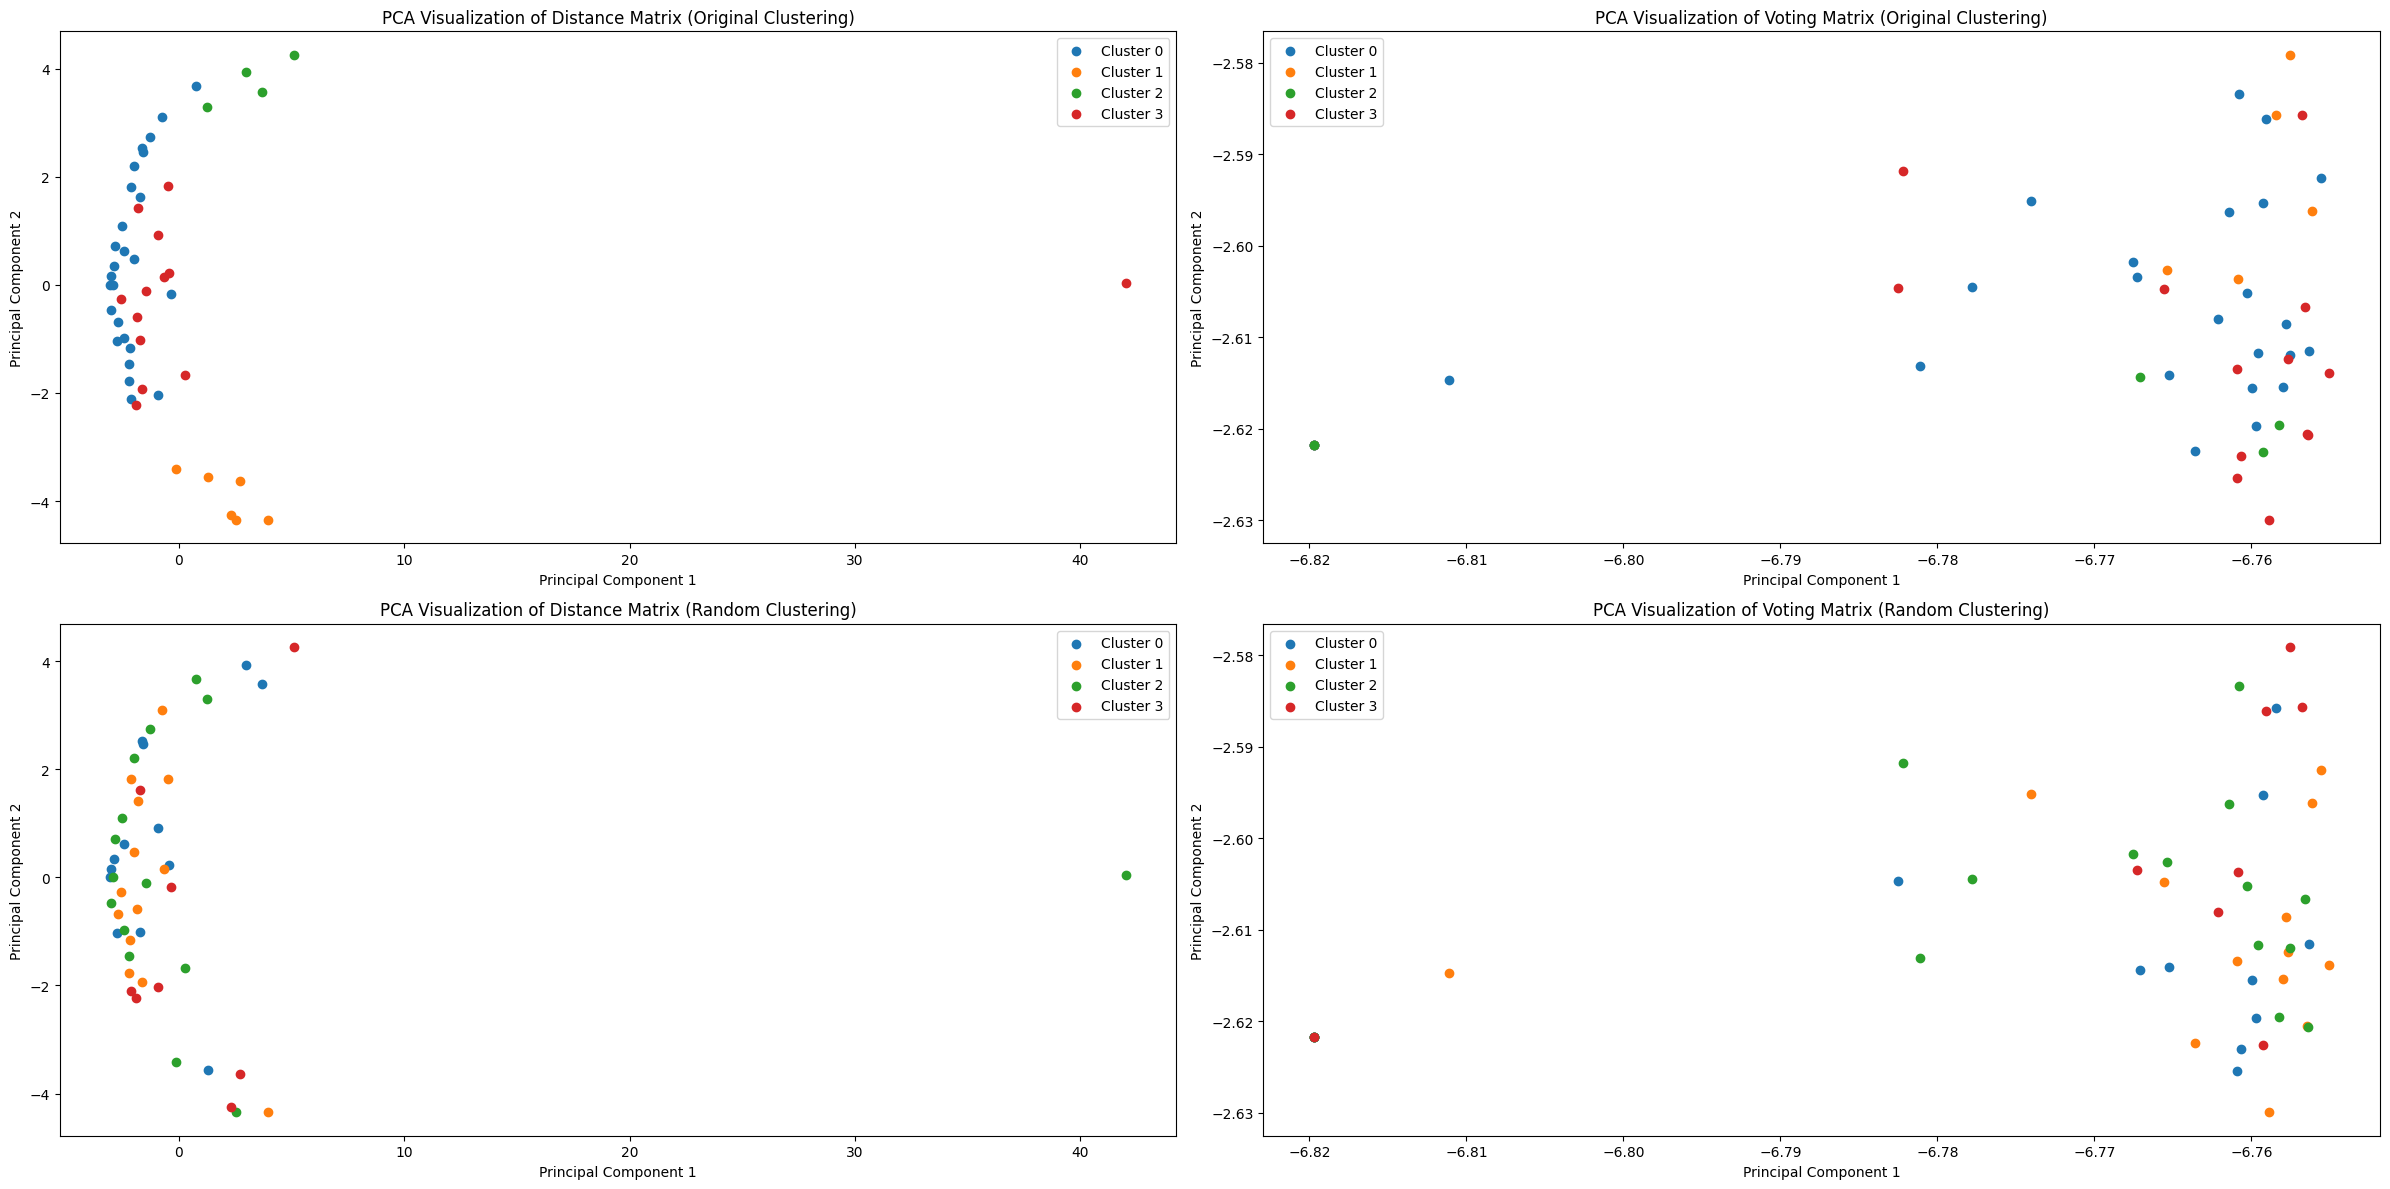

The silhouette score for Distance Matrix (Original) is: 0.3015845155402666
The silhouette score for Voting Matrix (Original) is: -0.043934440985513516
The silhouette score for Distance Matrix data (Random) is: -0.1780335546486048
The silhouette score for Voting Matrix data (Random) is: -0.05000890026795508


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


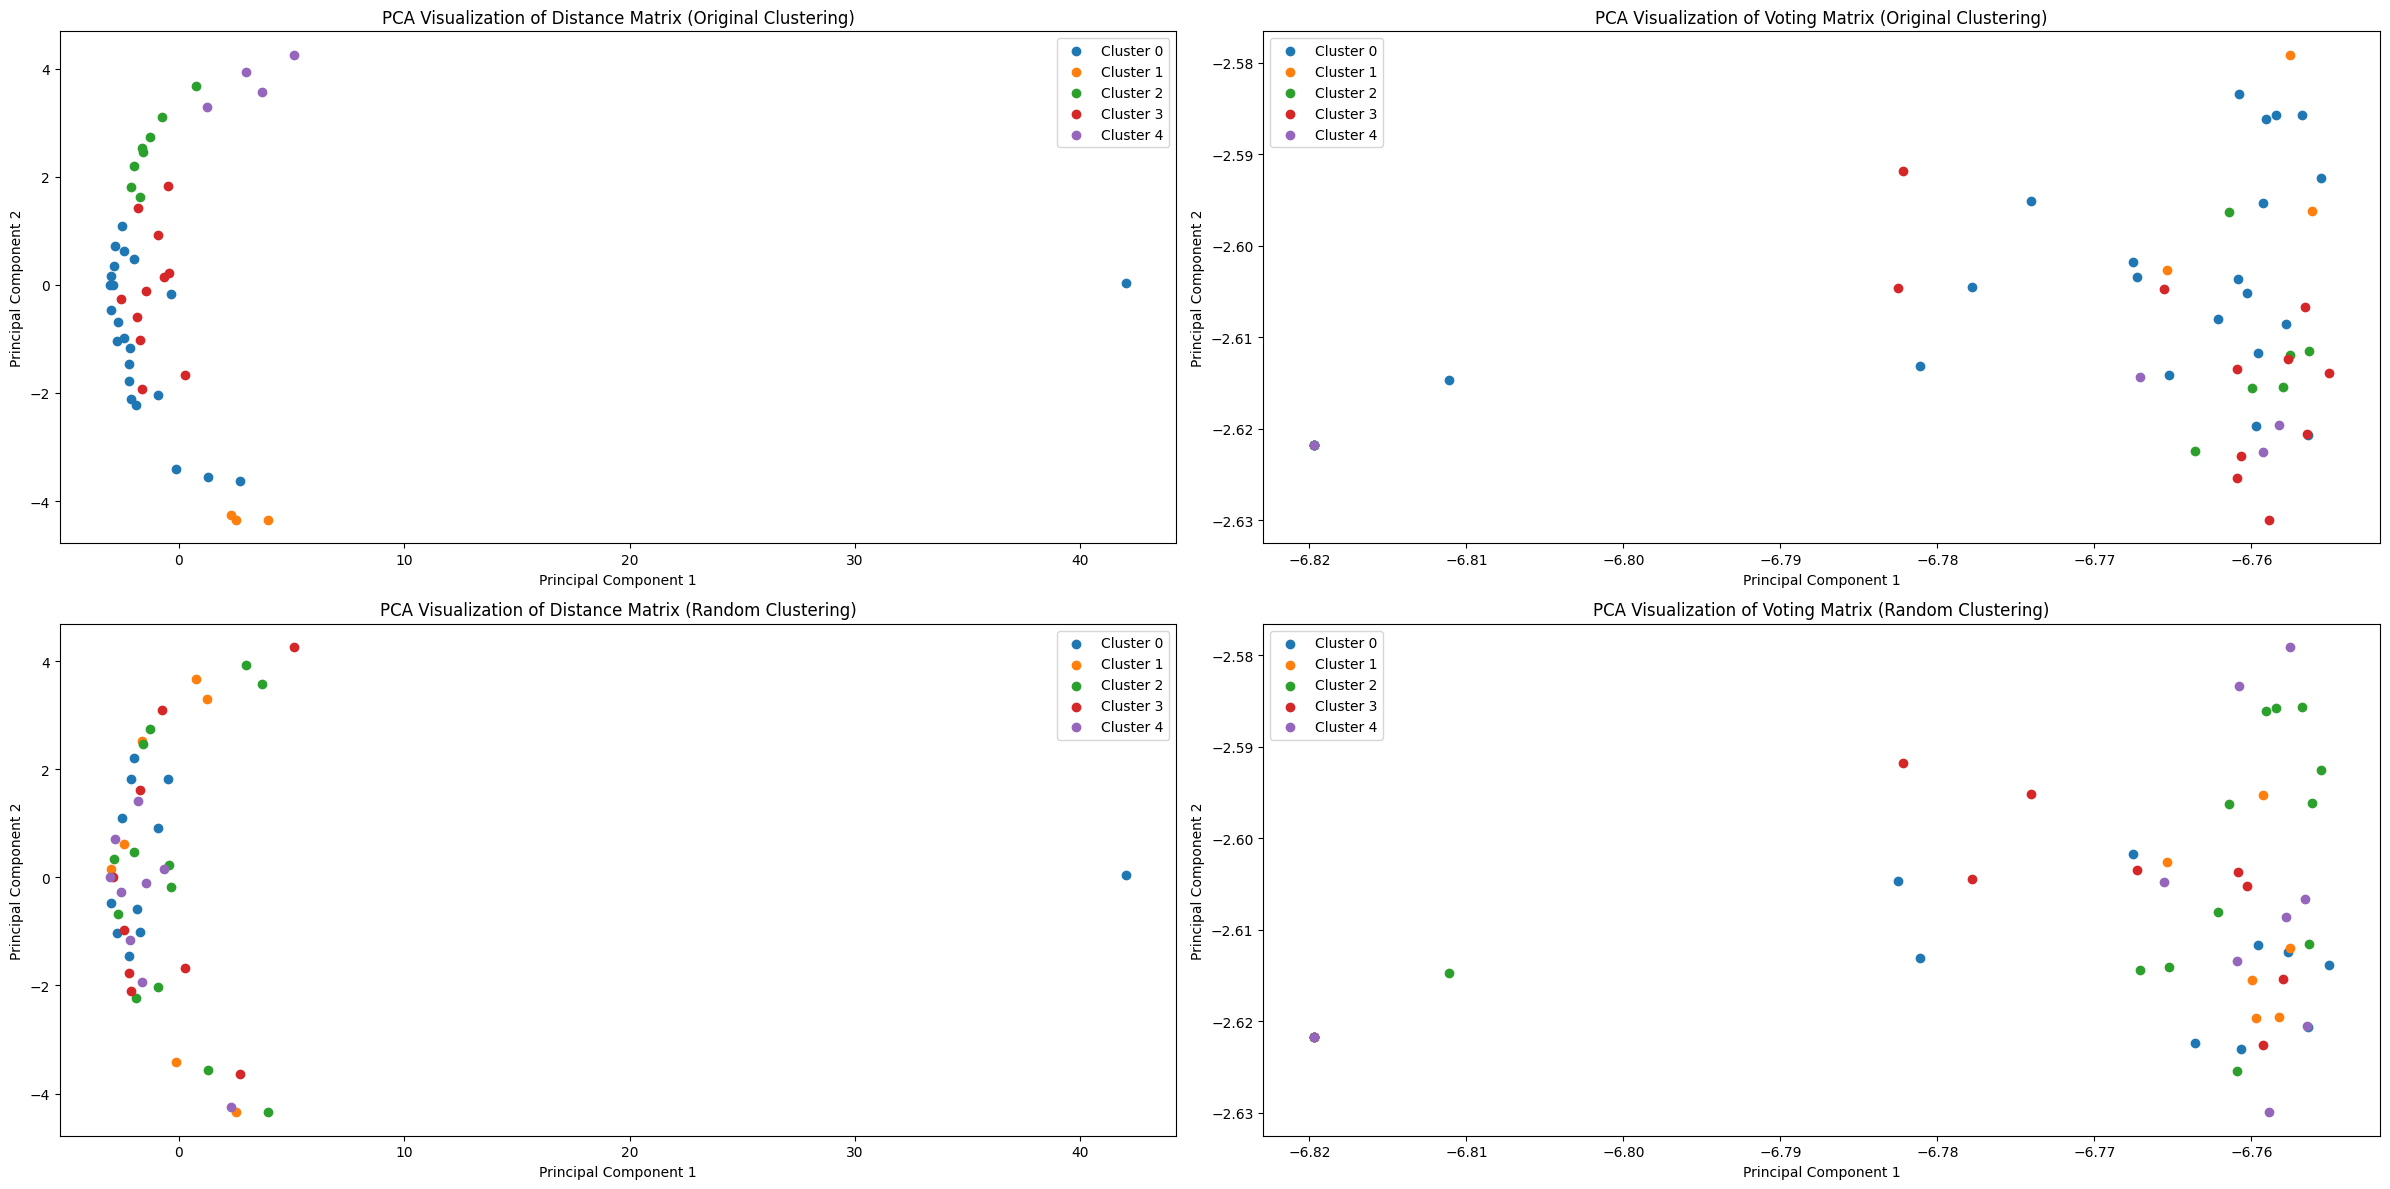

The silhouette score for Distance Matrix (Original) is: 0.15855320161478026
The silhouette score for Voting Matrix (Original) is: -0.05220274041450658
The silhouette score for Distance Matrix data (Random) is: -0.17746530490463924
The silhouette score for Voting Matrix data (Random) is: -0.06891862789943355


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


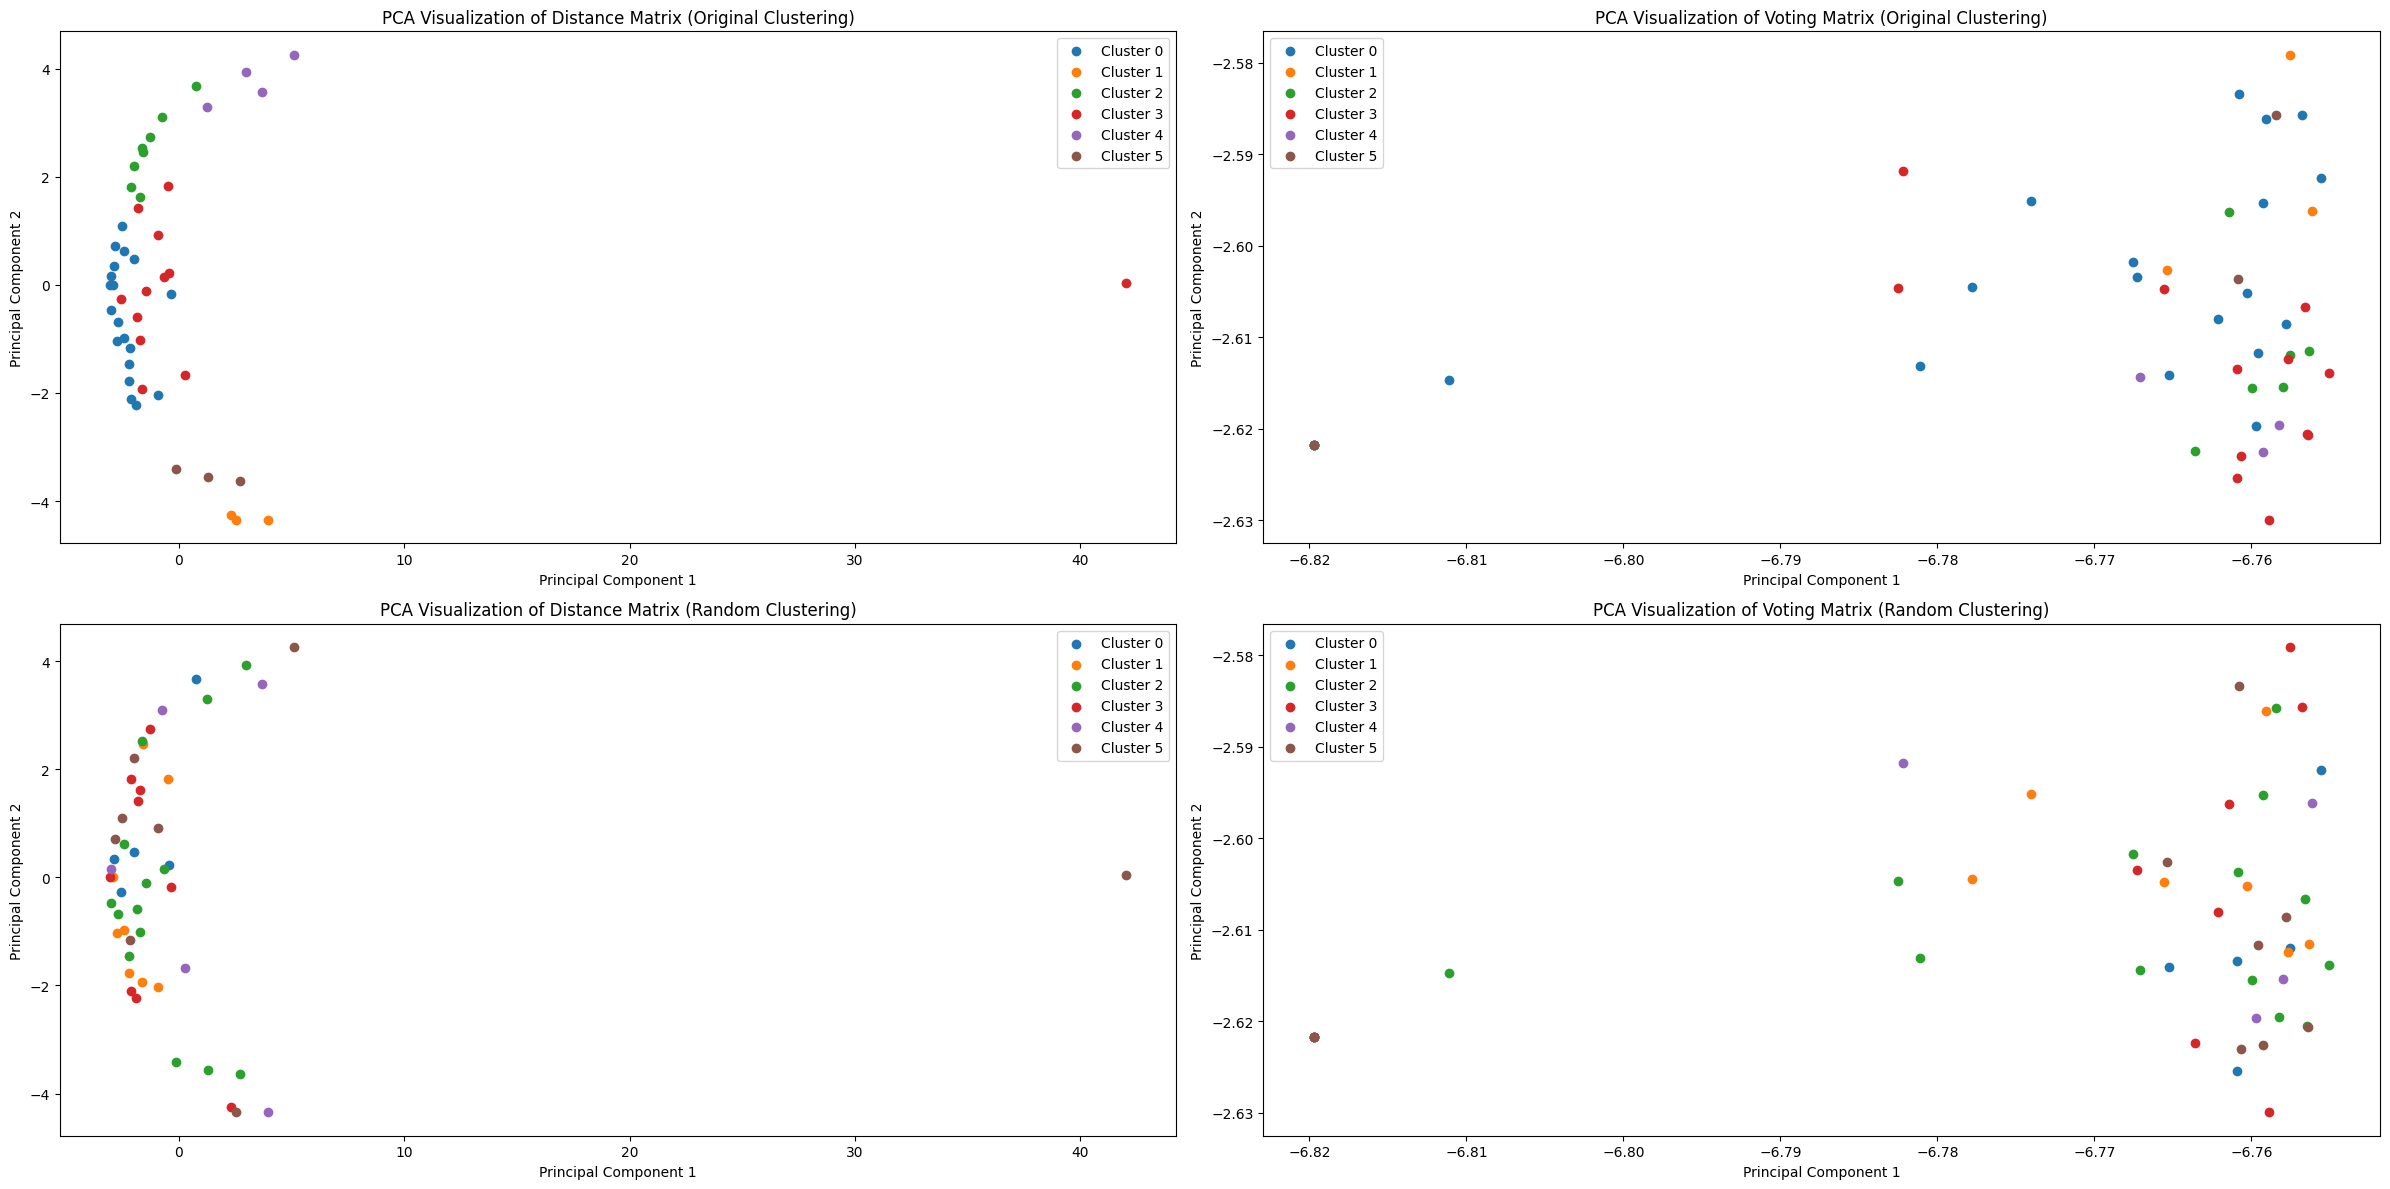

The silhouette score for Distance Matrix (Original) is: 0.2277230327024865
The silhouette score for Voting Matrix (Original) is: -0.06113875551021135
The silhouette score for Distance Matrix data (Random) is: -0.22849888069326615
The silhouette score for Voting Matrix data (Random) is: -0.07441552453267555


In [6]:
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(distance_matrix, votes_matrix_tele, 6, method='SpectralClustering')

## Analysis
We compared the silhouette score for V data (Original) with the silhouette score for V data (Random) and found no significant differences. This suggests that countries clustered together due to proximity do not exhibit notable similarities in voting behavior.

Regression and correlation analyses are particularly sensitive to the overall distribution patterns of data, especially in detecting linear trends. This enables them to detect even subtle linear associations between geographic distances and voting behaviors. On the other hand, cluster analysis requires the data to form relatively independent "clusters" in a multidimensional space, and is suitable for situations where there are clear separations within the data. If the differences between data points are not significant enough, or if the data distribution is too uniform, clustering may not effectively distinguish between different groups.